In [2]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings')

sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14148970777467497286
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 704829339087495813
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [3]:
past = 2
name = f"sgan_{past}-1_w"

Load dataset.

In [4]:
train, xval, test = src.load_datasets(past_frames=past)

Training data: (7500, 64, 64, 3)
Validation data: (1500, 64, 64, 3)
Test data: (1000, 64, 64, 3)


In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 2) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 2) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 2) 
Shape of test truth:  (1000, 64, 64, 1)


Make discriminator labels.

In [6]:
batch_size=16

In [7]:
# Adversarial ground truths
real = -np.ones((batch_size, 1))
fake = np.ones((batch_size, 1))
#Generator ground truths
#real, fake = src.noisy_d_labels(real, fake)

Make generator but don't compile.

In [8]:
generator = src.unet((64, 64, past), dropout=0, batchnorm=True, kernel_size=4, feature_mult=1)
discriminator = src.spatial_discriminator(condition_shape=(64, 64, past), dropout = 0.25, batchnorm=True, wgan=True)
discriminator.compile(loss=src.wasserstein_loss,
                      optimizer=keras.optimizers.RMSprop(lr=0.00005))

frame_t = keras.layers.Input(shape=(64, 64, past))
generated = generator(frame_t)
score = discriminator([frame_t, generated])
discriminator.trainable = False
for l in discriminator.layers: l.trainable = False
loss_weights=[0,1]
combined = keras.models.Model(inputs=[frame_t], outputs=[generated, score])
#combined.load_weights("C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/models/"+name+"/sgan_2-1_w_model.h5")

In [9]:
combined.compile(loss=[src.custom_loss(loss="l1"), src.wasserstein_loss],
                 optimizer=keras.optimizers.RMSprop(lr=0.00005),
                 loss_weights=loss_weights)

***Using L1 loss.***


In [10]:
log = {"g_loss":[],
       "d_loss":[],
       "g_metric":[],
       "d_metric":[],
       "d_loss_real":[],
       "d_loss_fake":[],
       "d_test_real":[],
       "d_test_fake":[]}

Train x epochs.

In [11]:
epochs = 5000
# random seed
RND = 777
np.random.seed(RND)

 0 [D loss: -0.008397407829761505] 
 0 [G loss: -0.01443127728998661, G obj.: 0.3170219361782074, G wgan.: -0.01443127728998661] 
 0 [real loss: -0.006666990928351879, fake loss: -0.010127823799848557]
 1 [D loss: -0.010761115700006485] 
 1 [G loss: -0.01850416325032711, G obj.: 0.33305567502975464, G wgan.: -0.01850416325032711] 
 1 [real loss: -0.01069588866084814, fake loss: -0.010826341807842255]
 2 [D loss: -0.010920582339167595] 
 2 [G loss: -0.01803051307797432, G obj.: 0.30639415979385376, G wgan.: -0.01803051307797432] 
 2 [real loss: -0.010685150511562824, fake loss: -0.01115601509809494]
 3 [D loss: -0.013110572472214699] 
 3 [G loss: -0.015681039541959763, G obj.: 0.32798323035240173, G wgan.: -0.015681039541959763] 
 3 [real loss: -0.014970371499657631, fake loss: -0.011250773444771767]
 4 [D loss: -0.011017022654414177] 
 4 [G loss: -0.018487991765141487, G obj.: 0.31973034143447876, G wgan.: -0.018487991765141487] 
 4 [real loss: -0.010619459673762321, fake loss: -0.0114

 36 [D loss: -0.013938995078206062] 
 36 [G loss: -0.028004862368106842, G obj.: 0.3199278712272644, G wgan.: -0.028004862368106842] 
 36 [real loss: -0.011762089096009731, fake loss: -0.016115901991724968]
 37 [D loss: -0.013278767466545105] 
 37 [G loss: -0.026329074054956436, G obj.: 0.3213934898376465, G wgan.: -0.026329074054956436] 
 37 [real loss: -0.009642303921282291, fake loss: -0.016915231943130493]
 38 [D loss: -0.013105640187859535] 
 38 [G loss: -0.02749708667397499, G obj.: 0.3103539049625397, G wgan.: -0.02749708667397499] 
 38 [real loss: -0.01059658918529749, fake loss: -0.015614690259099007]
 39 [D loss: -0.013675980269908905] 
 39 [G loss: -0.02773941308259964, G obj.: 0.32254791259765625, G wgan.: -0.02773941308259964] 
 39 [real loss: -0.01090323831886053, fake loss: -0.016448723152279854]
 40 [D loss: -0.012618877924978733] 
 40 [G loss: -0.02793985605239868, G obj.: 0.3205389082431793, G wgan.: -0.02793985605239868] 
 40 [real loss: -0.008577952161431313, fake l

 72 [D loss: -0.015025665983557701] 
 72 [G loss: -0.029840130358934402, G obj.: 0.3387397229671478, G wgan.: -0.029840130358934402] 
 72 [real loss: -0.009668201208114624, fake loss: -0.020383130759000778]
 73 [D loss: -0.013760292902588844] 
 73 [G loss: -0.030314480885863304, G obj.: 0.36412984132766724, G wgan.: -0.030314480885863304] 
 73 [real loss: -0.007269109599292278, fake loss: -0.020251475274562836]
 74 [D loss: -0.012677655555307865] 
 74 [G loss: -0.030197208747267723, G obj.: 0.3452843427658081, G wgan.: -0.030197208747267723] 
 74 [real loss: -0.005655824672430754, fake loss: -0.01969948597252369]
 75 [D loss: -0.012813101522624493] 
 75 [G loss: -0.031099744141101837, G obj.: 0.3496553897857666, G wgan.: -0.031099744141101837] 
 75 [real loss: -0.005407386925071478, fake loss: -0.02021881565451622]
 76 [D loss: -0.01201875414699316] 
 76 [G loss: -0.031950630247592926, G obj.: 0.35360875725746155, G wgan.: -0.031950630247592926] 
 76 [real loss: -0.004466244485229254, 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


 101 [D loss: -0.014947200194001198] 
 101 [G loss: -0.023451048880815506, G obj.: 0.33717450499534607, G wgan.: -0.023451048880815506] 
 101 [real loss: -0.007617342285811901, fake loss: -0.02227705717086792]
 102 [D loss: -0.0165490061044693] 
 102 [G loss: -0.02587750181555748, G obj.: 0.3553709089756012, G wgan.: -0.02587750181555748] 
 102 [real loss: -0.00963908713310957, fake loss: -0.023458924144506454]
 103 [D loss: -0.013568375259637833] 
 103 [G loss: -0.026977216824889183, G obj.: 0.3452051877975464, G wgan.: -0.026977216824889183] 
 103 [real loss: -0.0040968032553792, fake loss: -0.02303994819521904]
 104 [D loss: -0.014372585341334343] 
 104 [G loss: -0.02690291590988636, G obj.: 0.3250618875026703, G wgan.: -0.02690291590988636] 
 104 [real loss: -0.005902379751205444, fake loss: -0.02284279093146324]
 105 [D loss: -0.014684073626995087] 
 105 [G loss: -0.028100766241550446, G obj.: 0.3263123035430908, G wgan.: -0.028100766241550446] 
 105 [real loss: -0.006140127778053

 137 [D loss: -0.014254766516387463] 
 137 [G loss: -0.024141985923051834, G obj.: 0.33304324746131897, G wgan.: -0.024141985923051834] 
 137 [real loss: -0.004223883152008057, fake loss: -0.02428564988076687]
 138 [D loss: -0.01155256200581789] 
 138 [G loss: -0.023826610296964645, G obj.: 0.33448565006256104, G wgan.: -0.023826610296964645] 
 138 [real loss: 0.0004705574829131365, fake loss: -0.023575682193040848]
 139 [D loss: -0.014175759628415108] 
 139 [G loss: -0.023965364322066307, G obj.: 0.33043190836906433, G wgan.: -0.023965364322066307] 
 139 [real loss: -0.003993138670921326, fake loss: -0.02435838058590889]
 140 [D loss: -0.013475773856043816] 
 140 [G loss: -0.022887099534273148, G obj.: 0.31756994128227234, G wgan.: -0.022887099534273148] 
 140 [real loss: -0.0026743742637336254, fake loss: -0.02427717298269272]
 141 [D loss: -0.012511988170444965] 
 141 [G loss: -0.023359524086117744, G obj.: 0.3435109555721283, G wgan.: -0.023359524086117744] 
 141 [real loss: -0.001

 173 [D loss: -0.011390691623091698] 
 173 [G loss: -0.01621084474027157, G obj.: 0.3366060256958008, G wgan.: -0.01621084474027157] 
 173 [real loss: -0.0011724053183570504, fake loss: -0.021608978509902954]
 174 [D loss: -0.011495811864733696] 
 174 [G loss: -0.016815949231386185, G obj.: 0.3252922296524048, G wgan.: -0.016815949231386185] 
 174 [real loss: 0.0006411082576960325, fake loss: -0.023632731288671494]
 175 [D loss: -0.01086841244250536] 
 175 [G loss: -0.01668405905365944, G obj.: 0.32798007130622864, G wgan.: -0.01668405905365944] 
 175 [real loss: 0.0009628824191167951, fake loss: -0.022699708119034767]
 176 [D loss: -0.010740318335592747] 
 176 [G loss: -0.02005438134074211, G obj.: 0.32013577222824097, G wgan.: -0.02005438134074211] 
 176 [real loss: -0.0002511127386242151, fake loss: -0.021229524165391922]
 177 [D loss: -0.009261676110327244] 
 177 [G loss: -0.016854578629136086, G obj.: 0.32533368468284607, G wgan.: -0.016854578629136086] 
 177 [real loss: 0.0027620

 209 [D loss: -0.0030019767582416534] 
 209 [G loss: -0.013618769124150276, G obj.: 0.31466734409332275, G wgan.: -0.013618769124150276] 
 209 [real loss: 0.012116074562072754, fake loss: -0.01812002807855606]
 210 [D loss: -0.007710005156695843] 
 210 [G loss: -0.012856436893343925, G obj.: 0.3380874991416931, G wgan.: -0.012856436893343925] 
 210 [real loss: 0.003659512847661972, fake loss: -0.019079523161053658]
 211 [D loss: -0.00578666664659977] 
 211 [G loss: -0.01270008459687233, G obj.: 0.34087979793548584, G wgan.: -0.01270008459687233] 
 211 [real loss: 0.004447760060429573, fake loss: -0.016021093353629112]
 212 [D loss: -0.00659289350733161] 
 212 [G loss: -0.01260277722030878, G obj.: 0.3317897915840149, G wgan.: -0.01260277722030878] 
 212 [real loss: 0.007345878519117832, fake loss: -0.02053166553378105]
 213 [D loss: -0.0043042246252298355] 
 213 [G loss: -0.012326212599873543, G obj.: 0.330063134431839, G wgan.: -0.012326212599873543] 
 213 [real loss: 0.00874085351824

 245 [D loss: -0.004083081614226103] 
 245 [G loss: 0.019358297809958458, G obj.: 0.3346913456916809, G wgan.: 0.019358297809958458] 
 245 [real loss: 0.008929294534027576, fake loss: -0.017095457762479782]
 246 [D loss: -0.005361032672226429] 
 246 [G loss: 0.017209134995937347, G obj.: 0.32107430696487427, G wgan.: 0.017209134995937347] 
 246 [real loss: 0.008008869364857674, fake loss: -0.01873093470931053]
 247 [D loss: -0.0066187274642288685] 
 247 [G loss: 0.01871870830655098, G obj.: 0.34408941864967346, G wgan.: 0.01871870830655098] 
 247 [real loss: 0.0035849970299750566, fake loss: -0.01682245172560215]
 248 [D loss: -0.0070277187041938305] 
 248 [G loss: 0.021385107189416885, G obj.: 0.3297397494316101, G wgan.: 0.021385107189416885] 
 248 [real loss: 0.004238332621753216, fake loss: -0.018293770030140877]
 249 [D loss: -0.00526534765958786] 
 249 [G loss: 0.01910700835287571, G obj.: 0.3323756456375122, G wgan.: 0.01910700835287571] 
 249 [real loss: 0.007039327174425125, f

 281 [D loss: -0.0217653326690197] 
 281 [G loss: -0.012942014262080193, G obj.: 0.37546515464782715, G wgan.: -0.012942014262080193] 
 281 [real loss: -0.04360923916101456, fake loss: 7.8574288636446e-05]
 282 [D loss: -0.02076176181435585] 
 282 [G loss: -0.016316533088684082, G obj.: 0.3894653916358948, G wgan.: -0.016316533088684082] 
 282 [real loss: -0.04585076496005058, fake loss: 0.0043272399343550205]
 283 [D loss: -0.021782048046588898] 
 283 [G loss: -0.02432246133685112, G obj.: 0.35700398683547974, G wgan.: -0.02432246133685112] 
 283 [real loss: -0.046502090990543365, fake loss: 0.002937993034720421]
 284 [D loss: -0.02231479622423649] 
 284 [G loss: -0.022966474294662476, G obj.: 0.3784549832344055, G wgan.: -0.022966474294662476] 
 284 [real loss: -0.05726134032011032, fake loss: 0.01263174694031477]
 285 [D loss: -0.022145330905914307] 
 285 [G loss: -0.02823871374130249, G obj.: 0.39698708057403564, G wgan.: -0.02823871374130249] 
 285 [real loss: -0.05081230401992798

 317 [D loss: -0.02410079352557659] 
 317 [G loss: -0.04688425362110138, G obj.: 0.40875786542892456, G wgan.: -0.04688425362110138] 
 317 [real loss: -0.07293152809143066, fake loss: 0.02472994104027748]
 318 [D loss: -0.018433721736073494] 
 318 [G loss: -0.0472588837146759, G obj.: 0.41035616397857666, G wgan.: -0.0472588837146759] 
 318 [real loss: -0.06922361254692078, fake loss: 0.03235616907477379]
 319 [D loss: -0.023179907351732254] 
 319 [G loss: -0.05042365938425064, G obj.: 0.40166717767715454, G wgan.: -0.05042365938425064] 
 319 [real loss: -0.07255153357982635, fake loss: 0.026191718876361847]
 320 [D loss: -0.030183356255292892] 
 320 [G loss: -0.04672674089670181, G obj.: 0.42986321449279785, G wgan.: -0.04672674089670181] 
 320 [real loss: -0.07272519171237946, fake loss: 0.01235847920179367]
 321 [D loss: -0.02535228803753853] 
 321 [G loss: -0.050666552037000656, G obj.: 0.413362592458725, G wgan.: -0.050666552037000656] 
 321 [real loss: -0.07138721644878387, fake 

 353 [D loss: -0.021719234064221382] 
 353 [G loss: -0.055421046912670135, G obj.: 0.4469519853591919, G wgan.: -0.055421046912670135] 
 353 [real loss: -0.07788433134555817, fake loss: 0.0344458632171154]
 354 [D loss: -0.019897468388080597] 
 354 [G loss: -0.060720957815647125, G obj.: 0.42559874057769775, G wgan.: -0.060720957815647125] 
 354 [real loss: -0.07576246559619904, fake loss: 0.03596752882003784]
 355 [D loss: -0.017829788848757744] 
 355 [G loss: -0.06753760576248169, G obj.: 0.4279796779155731, G wgan.: -0.06753760576248169] 
 355 [real loss: -0.07396820187568665, fake loss: 0.03830862417817116]
 356 [D loss: -0.013862255960702896] 
 356 [G loss: -0.05747441202402115, G obj.: 0.44240516424179077, G wgan.: -0.05747441202402115] 
 356 [real loss: -0.0730849951505661, fake loss: 0.04536048322916031]
 357 [D loss: -0.01801535114645958] 
 357 [G loss: -0.05953862518072128, G obj.: 0.41698282957077026, G wgan.: -0.05953862518072128] 
 357 [real loss: -0.07597573846578598, fak

 389 [D loss: -0.010828936472535133] 
 389 [G loss: -0.05670052394270897, G obj.: 0.4589291214942932, G wgan.: -0.05670052394270897] 
 389 [real loss: -0.07763084024190903, fake loss: 0.05597296729683876]
 390 [D loss: -0.009260432794690132] 
 390 [G loss: -0.06536459922790527, G obj.: 0.4616727828979492, G wgan.: -0.06536459922790527] 
 390 [real loss: -0.07634520530700684, fake loss: 0.05782433971762657]
 391 [D loss: -0.009366735816001892] 
 391 [G loss: -0.06250572204589844, G obj.: 0.4316502809524536, G wgan.: -0.06250572204589844] 
 391 [real loss: -0.0799722671508789, fake loss: 0.06123879551887512]
 392 [D loss: -0.013120032846927643] 
 392 [G loss: -0.05834373086690903, G obj.: 0.4703049063682556, G wgan.: -0.05834373086690903] 
 392 [real loss: -0.07788857817649841, fake loss: 0.05164851248264313]
 393 [D loss: -0.0060877203941345215] 
 393 [G loss: -0.05597921460866928, G obj.: 0.4628293216228485, G wgan.: -0.05597921460866928] 
 393 [real loss: -0.07808654755353928, fake lo

 425 [D loss: -0.011340873315930367] 
 425 [G loss: -0.05661563202738762, G obj.: 0.412519633769989, G wgan.: -0.05661563202738762] 
 425 [real loss: -0.0804966539144516, fake loss: 0.057814907282590866]
 426 [D loss: -0.010956386104226112] 
 426 [G loss: -0.05276355892419815, G obj.: 0.4108128547668457, G wgan.: -0.05276355892419815] 
 426 [real loss: -0.07995176315307617, fake loss: 0.05803899094462395]
 427 [D loss: -0.010088052600622177] 
 427 [G loss: -0.05885060504078865, G obj.: 0.396981418132782, G wgan.: -0.05885060504078865] 
 427 [real loss: -0.08188535273075104, fake loss: 0.06170924752950668]
 428 [D loss: -0.007134385406970978] 
 428 [G loss: -0.062150247395038605, G obj.: 0.4173180162906647, G wgan.: -0.062150247395038605] 
 428 [real loss: -0.07870606333017349, fake loss: 0.06443729251623154]
 429 [D loss: -0.014231707900762558] 
 429 [G loss: -0.05255231261253357, G obj.: 0.4002889394760132, G wgan.: -0.05255231261253357] 
 429 [real loss: -0.08181407302618027, fake lo

 461 [D loss: -0.002169109880924225] 
 461 [G loss: -0.06517350673675537, G obj.: 0.31951671838760376, G wgan.: -0.06517350673675537] 
 461 [real loss: -0.07368956506252289, fake loss: 0.06935134530067444]
 462 [D loss: -0.0007097423076629639] 
 462 [G loss: -0.06666865944862366, G obj.: 0.3064032196998596, G wgan.: -0.06666865944862366] 
 462 [real loss: -0.07297436892986298, fake loss: 0.07155488431453705]
 463 [D loss: -0.0031453296542167664] 
 463 [G loss: -0.0644168108701706, G obj.: 0.32165616750717163, G wgan.: -0.0644168108701706] 
 463 [real loss: -0.07437185943126678, fake loss: 0.06808120012283325]
 464 [D loss: -0.005613325163722038] 
 464 [G loss: -0.06443862617015839, G obj.: 0.29739314317703247, G wgan.: -0.06443862617015839] 
 464 [real loss: -0.07270088791847229, fake loss: 0.061474237591028214]
 465 [D loss: -0.0006870627403259277] 
 465 [G loss: -0.06708590686321259, G obj.: 0.31812453269958496, G wgan.: -0.06708590686321259] 
 465 [real loss: -0.0744781494140625, fa

 497 [D loss: -0.0037609003484249115] 
 497 [G loss: -0.0669463649392128, G obj.: 0.27417635917663574, G wgan.: -0.0669463649392128] 
 497 [real loss: -0.06494732201099396, fake loss: 0.057425521314144135]
 498 [D loss: -0.004189789295196533] 
 498 [G loss: -0.06830312311649323, G obj.: 0.2798437774181366, G wgan.: -0.06830312311649323] 
 498 [real loss: -0.06315240263938904, fake loss: 0.05477282404899597]
 499 [D loss: -0.0036812368780374527] 
 499 [G loss: -0.06415480375289917, G obj.: 0.283555805683136, G wgan.: -0.06415480375289917] 
 499 [real loss: -0.06061706691980362, fake loss: 0.053254593163728714]
 500 [D loss: -0.002585703507065773] 
 500 [G loss: -0.06249389797449112, G obj.: 0.2705819606781006, G wgan.: -0.06249389797449112] 
 500 [real loss: -0.06007429584860802, fake loss: 0.05490288883447647]
 501 [D loss: -0.001959221437573433] 
 501 [G loss: -0.06269346177577972, G obj.: 0.27506589889526367, G wgan.: -0.06269346177577972] 
 501 [real loss: -0.06202908977866173, fake

 533 [D loss: -0.004122063517570496] 
 533 [G loss: -0.06985941529273987, G obj.: 0.26624974608421326, G wgan.: -0.06985941529273987] 
 533 [real loss: -0.06546691060066223, fake loss: 0.05722278356552124]
 534 [D loss: -0.006494389846920967] 
 534 [G loss: -0.07241617143154144, G obj.: 0.26662856340408325, G wgan.: -0.07241617143154144] 
 534 [real loss: -0.06295928359031677, fake loss: 0.04997050389647484]
 535 [D loss: -0.0047854408621788025] 
 535 [G loss: -0.06848765909671783, G obj.: 0.26277369260787964, G wgan.: -0.06848765909671783] 
 535 [real loss: -0.062380000948905945, fake loss: 0.05280911922454834]
 536 [D loss: -0.006377425044775009] 
 536 [G loss: -0.07415714114904404, G obj.: 0.2664321959018707, G wgan.: -0.07415714114904404] 
 536 [real loss: -0.058872513473033905, fake loss: 0.04611766338348389]
 537 [D loss: -0.0034625642001628876] 
 537 [G loss: -0.07510882616043091, G obj.: 0.2675587236881256, G wgan.: -0.07510882616043091] 
 537 [real loss: -0.05809441953897476, 

 569 [D loss: -0.0031690113246440887] 
 569 [G loss: -0.08356574177742004, G obj.: 0.29347848892211914, G wgan.: -0.08356574177742004] 
 569 [real loss: -0.06005074456334114, fake loss: 0.05371272191405296]
 570 [D loss: -0.0030930787324905396] 
 570 [G loss: -0.08423962444067001, G obj.: 0.28431424498558044, G wgan.: -0.08423962444067001] 
 570 [real loss: -0.05938224866986275, fake loss: 0.05319609120488167]
 571 [D loss: -0.004687082022428513] 
 571 [G loss: -0.08396253734827042, G obj.: 0.2966727912425995, G wgan.: -0.08396253734827042] 
 571 [real loss: -0.05748995766043663, fake loss: 0.048115793615579605]
 572 [D loss: -5.256757140159607e-05] 
 572 [G loss: -0.08167442679405212, G obj.: 0.2780138850212097, G wgan.: -0.08167442679405212] 
 572 [real loss: -0.056128256022930145, fake loss: 0.05602312088012695]
 573 [D loss: -0.00039714761078357697] 
 573 [G loss: -0.08235228061676025, G obj.: 0.2920582592487335, G wgan.: -0.08235228061676025] 
 573 [real loss: -0.05439133197069168

 605 [D loss: -0.002740302123129368] 
 605 [G loss: -0.04345989227294922, G obj.: 0.3008992075920105, G wgan.: -0.04345989227294922] 
 605 [real loss: -0.03387526422739029, fake loss: 0.028394659981131554]
 606 [D loss: -0.004052038304507732] 
 606 [G loss: -0.04429282993078232, G obj.: 0.30261027812957764, G wgan.: -0.04429282993078232] 
 606 [real loss: -0.03602978214621544, fake loss: 0.027925705537199974]
 607 [D loss: -0.004467908293008804] 
 607 [G loss: -0.04450279846787453, G obj.: 0.3142624795436859, G wgan.: -0.04450279846787453] 
 607 [real loss: -0.03770796209573746, fake loss: 0.02877214550971985]
 608 [D loss: -0.006754465401172638] 
 608 [G loss: -0.03559404984116554, G obj.: 0.29640036821365356, G wgan.: -0.03559404984116554] 
 608 [real loss: -0.03679382801055908, fake loss: 0.023284897208213806]
 609 [D loss: -0.00957311037927866] 
 609 [G loss: -0.033209480345249176, G obj.: 0.3209035098552704, G wgan.: -0.033209480345249176] 
 609 [real loss: -0.03889309987425804, f

 641 [D loss: -0.016198981553316116] 
 641 [G loss: -0.01574583724141121, G obj.: 0.320035457611084, G wgan.: -0.01574583724141121] 
 641 [real loss: -0.05992210656404495, fake loss: 0.02752414345741272]
 642 [D loss: -0.016364403069019318] 
 642 [G loss: -0.02762090414762497, G obj.: 0.32690298557281494, G wgan.: -0.02762090414762497] 
 642 [real loss: -0.059818148612976074, fake loss: 0.027089344337582588]
 643 [D loss: -0.016212111338973045] 
 643 [G loss: -0.01426113210618496, G obj.: 0.3364304006099701, G wgan.: -0.01426113210618496] 
 643 [real loss: -0.05980066582560539, fake loss: 0.027376443147659302]
 644 [D loss: -0.01558745838701725] 
 644 [G loss: -0.019176272675395012, G obj.: 0.34881383180618286, G wgan.: -0.019176272675395012] 
 644 [real loss: -0.05669233947992325, fake loss: 0.025517422705888748]
 645 [D loss: -0.017141783609986305] 
 645 [G loss: -0.026058167219161987, G obj.: 0.33944326639175415, G wgan.: -0.026058167219161987] 
 645 [real loss: -0.06271751970052719

 677 [D loss: -0.009908284991979599] 
 677 [G loss: -0.021041519939899445, G obj.: 0.38447052240371704, G wgan.: -0.021041519939899445] 
 677 [real loss: -0.06132584810256958, fake loss: 0.04150927811861038]
 678 [D loss: -0.02517666295170784] 
 678 [G loss: -0.007463954854756594, G obj.: 0.3646126389503479, G wgan.: -0.007463954854756594] 
 678 [real loss: -0.06291718035936356, fake loss: 0.012563852593302727]
 679 [D loss: -0.022215276956558228] 
 679 [G loss: -0.017165180295705795, G obj.: 0.38544055819511414, G wgan.: -0.017165180295705795] 
 679 [real loss: -0.062309592962265015, fake loss: 0.01787904091179371]
 680 [D loss: -0.02224772609770298] 
 680 [G loss: -0.008465546183288097, G obj.: 0.37874308228492737, G wgan.: -0.008465546183288097] 
 680 [real loss: -0.06176285445690155, fake loss: 0.01726740226149559]
 681 [D loss: -0.0237140953540802] 
 681 [G loss: -0.011113205924630165, G obj.: 0.38556110858917236, G wgan.: -0.011113205924630165] 
 681 [real loss: -0.05956137180328

 713 [D loss: -0.022218801081180573] 
 713 [G loss: -0.03144565224647522, G obj.: 0.37644779682159424, G wgan.: -0.03144565224647522] 
 713 [real loss: -0.06063125655055046, fake loss: 0.016193654388189316]
 714 [D loss: -0.02129296213388443] 
 714 [G loss: -0.019983815029263496, G obj.: 0.3990021347999573, G wgan.: -0.019983815029263496] 
 714 [real loss: -0.0618673674762249, fake loss: 0.01928144134581089]
 715 [D loss: -0.01579195447266102] 
 715 [G loss: -0.02332640066742897, G obj.: 0.3699825406074524, G wgan.: -0.02332640066742897] 
 715 [real loss: -0.061546023935079575, fake loss: 0.029962114989757538]
 716 [D loss: -0.023713162168860435] 
 716 [G loss: -0.016590552404522896, G obj.: 0.382756769657135, G wgan.: -0.016590552404522896] 
 716 [real loss: -0.06321077793836594, fake loss: 0.015784453600645065]
 717 [D loss: -0.020561562851071358] 
 717 [G loss: -0.02358148992061615, G obj.: 0.35612550377845764, G wgan.: -0.02358148992061615] 
 717 [real loss: -0.06316813826560974, f

 749 [D loss: -0.018551604822278023] 
 749 [G loss: -0.02767963707447052, G obj.: 0.3532699644565582, G wgan.: -0.02767963707447052] 
 749 [real loss: -0.06294195353984833, fake loss: 0.025838743895292282]
 750 [D loss: -0.01652158796787262] 
 750 [G loss: -0.027880821377038956, G obj.: 0.35343611240386963, G wgan.: -0.027880821377038956] 
 750 [real loss: -0.060372237116098404, fake loss: 0.027329061180353165]
 751 [D loss: -0.014890789054334164] 
 751 [G loss: -0.032569870352745056, G obj.: 0.34902679920196533, G wgan.: -0.032569870352745056] 
 751 [real loss: -0.060290757566690445, fake loss: 0.030509179458022118]
 752 [D loss: -0.016637243330478668] 
 752 [G loss: -0.03434940055012703, G obj.: 0.3518603444099426, G wgan.: -0.03434940055012703] 
 752 [real loss: -0.06376546621322632, fake loss: 0.030490977689623833]
 753 [D loss: -0.014913681894540787] 
 753 [G loss: -0.030715789645910263, G obj.: 0.36478617787361145, G wgan.: -0.030715789645910263] 
 753 [real loss: -0.061683453619

 785 [D loss: -0.0004501529037952423] 
 785 [G loss: -0.038924358785152435, G obj.: 0.2941652834415436, G wgan.: -0.038924358785152435] 
 785 [real loss: -0.05277173966169357, fake loss: 0.05187143385410309]
 786 [D loss: -0.005112066864967346] 
 786 [G loss: -0.040443286299705505, G obj.: 0.29992860555648804, G wgan.: -0.040443286299705505] 
 786 [real loss: -0.05513522028923035, fake loss: 0.044911086559295654]
 787 [D loss: -0.003483399748802185] 
 787 [G loss: -0.04021086543798447, G obj.: 0.3085484206676483, G wgan.: -0.04021086543798447] 
 787 [real loss: -0.05878791958093643, fake loss: 0.05182112008333206]
 788 [D loss: -0.0044045113027095795] 
 788 [G loss: -0.048609524965286255, G obj.: 0.3014034628868103, G wgan.: -0.048609524965286255] 
 788 [real loss: -0.058727145195007324, fake loss: 0.049918122589588165]
 789 [D loss: -0.0024834349751472473] 
 789 [G loss: -0.05111269652843475, G obj.: 0.2868906855583191, G wgan.: -0.05111269652843475] 
 789 [real loss: -0.0540106743574

 821 [D loss: -0.00279957614839077] 
 821 [G loss: -0.04921725392341614, G obj.: 0.2917458415031433, G wgan.: -0.04921725392341614] 
 821 [real loss: -0.05346215143799782, fake loss: 0.04786299914121628]
 822 [D loss: -0.00391809456050396] 
 822 [G loss: -0.05200500413775444, G obj.: 0.28485623002052307, G wgan.: -0.05200500413775444] 
 822 [real loss: -0.05660344660282135, fake loss: 0.04876725748181343]
 823 [D loss: -0.0019113346934318542] 
 823 [G loss: -0.050964273512363434, G obj.: 0.2872312068939209, G wgan.: -0.050964273512363434] 
 823 [real loss: -0.05415914207696915, fake loss: 0.05033647269010544]
 824 [D loss: -0.004096983000636101] 
 824 [G loss: -0.05082601308822632, G obj.: 0.28355029225349426, G wgan.: -0.05082601308822632] 
 824 [real loss: -0.053131408989429474, fake loss: 0.04493744298815727]
 825 [D loss: -0.0026329103857278824] 
 825 [G loss: -0.053221456706523895, G obj.: 0.2686806917190552, G wgan.: -0.053221456706523895] 
 825 [real loss: -0.05311618372797966, 

 857 [D loss: -0.0007547196000814438] 
 857 [G loss: -0.05586804449558258, G obj.: 0.2975023686885834, G wgan.: -0.05586804449558258] 
 857 [real loss: -0.05747191607952118, fake loss: 0.05596247687935829]
 858 [D loss: -0.000468570739030838] 
 858 [G loss: -0.05667305737733841, G obj.: 0.29120349884033203, G wgan.: -0.05667305737733841] 
 858 [real loss: -0.054975248873233795, fake loss: 0.05403810739517212]
 859 [D loss: -0.0006081350147724152] 
 859 [G loss: -0.0552324578166008, G obj.: 0.28256189823150635, G wgan.: -0.0552324578166008] 
 859 [real loss: -0.057815611362457275, fake loss: 0.056599341332912445]
 860 [D loss: 0.0005151815712451935] 
 860 [G loss: -0.05516795441508293, G obj.: 0.2847546637058258, G wgan.: -0.05516795441508293] 
 860 [real loss: -0.05475376546382904, fake loss: 0.05578412860631943]
 861 [D loss: -6.0286372900009155e-05] 
 861 [G loss: -0.052714403718709946, G obj.: 0.299191951751709, G wgan.: -0.052714403718709946] 
 861 [real loss: -0.05306801199913025,

 893 [D loss: -0.004576000384986401] 
 893 [G loss: -0.024258291348814964, G obj.: 0.2922666072845459, G wgan.: -0.024258291348814964] 
 893 [real loss: -0.038182683289051056, fake loss: 0.029030682519078255]
 894 [D loss: -0.0055899303406476974] 
 894 [G loss: -0.02730843611061573, G obj.: 0.27907752990722656, G wgan.: -0.02730843611061573] 
 894 [real loss: -0.04355843737721443, fake loss: 0.03237857669591904]
 895 [D loss: -0.0044522956013679504] 
 895 [G loss: -0.02772478759288788, G obj.: 0.30159884691238403, G wgan.: -0.02772478759288788] 
 895 [real loss: -0.037587352097034454, fake loss: 0.028682760894298553]
 896 [D loss: -0.005659664049744606] 
 896 [G loss: -0.02153843641281128, G obj.: 0.29558736085891724, G wgan.: -0.02153843641281128] 
 896 [real loss: -0.037034157663583755, fake loss: 0.025714829564094543]
 897 [D loss: -0.0035995617508888245] 
 897 [G loss: -0.02536783553659916, G obj.: 0.29455289244651794, G wgan.: -0.02536783553659916] 
 897 [real loss: -0.03400071710

 929 [D loss: 0.0015329048037528992] 
 929 [G loss: -0.030547497794032097, G obj.: 0.26617830991744995, G wgan.: -0.030547497794032097] 
 929 [real loss: -0.03712564334273338, fake loss: 0.04019145295023918]
 930 [D loss: 0.0011777253821492195] 
 930 [G loss: -0.02049414813518524, G obj.: 0.28433775901794434, G wgan.: -0.02049414813518524] 
 930 [real loss: -0.02045508846640587, fake loss: 0.022810539230704308]
 931 [D loss: 0.0006573032587766647] 
 931 [G loss: -0.028140423819422722, G obj.: 0.27289366722106934, G wgan.: -0.028140423819422722] 
 931 [real loss: -0.034090638160705566, fake loss: 0.035405244678258896]
 932 [D loss: 0.0015888046473264694] 
 932 [G loss: -0.027469564229249954, G obj.: 0.2839372158050537, G wgan.: -0.027469564229249954] 
 932 [real loss: -0.0299723781645298, fake loss: 0.03314998745918274]
 933 [D loss: 0.000718211755156517] 
 933 [G loss: -0.02858627215027809, G obj.: 0.27398866415023804, G wgan.: -0.02858627215027809] 
 933 [real loss: -0.025535194203257

 965 [D loss: 0.00017132703214883804] 
 965 [G loss: -0.020922986790537834, G obj.: 0.2828102707862854, G wgan.: -0.020922986790537834] 
 965 [real loss: -0.02101963758468628, fake loss: 0.021362291648983955]
 966 [D loss: 0.0006391992792487144] 
 966 [G loss: -0.02761412411928177, G obj.: 0.27406376600265503, G wgan.: -0.02761412411928177] 
 966 [real loss: -0.024702126160264015, fake loss: 0.025980524718761444]
 967 [D loss: 0.0003203554078936577] 
 967 [G loss: -0.022750340402126312, G obj.: 0.27891162037849426, G wgan.: -0.022750340402126312] 
 967 [real loss: -0.02354675717651844, fake loss: 0.024187467992305756]
 968 [D loss: 0.0008942335844039917] 
 968 [G loss: -0.021461639553308487, G obj.: 0.27100831270217896, G wgan.: -0.021461639553308487] 
 968 [real loss: -0.02281808853149414, fake loss: 0.024606555700302124]
 969 [D loss: -6.685033440589905e-06] 
 969 [G loss: -0.02591579593718052, G obj.: 0.2689136862754822, G wgan.: -0.02591579593718052] 
 969 [real loss: -0.0250879190

 1001 [D loss: -0.00022674165666103363] 
 1001 [G loss: -0.026049494743347168, G obj.: 0.26207804679870605, G wgan.: -0.026049494743347168] 
 1001 [real loss: -0.02526911348104477, fake loss: 0.024815630167722702]
 1002 [D loss: 0.00012781191617250443] 
 1002 [G loss: -0.026391830295324326, G obj.: 0.2760976552963257, G wgan.: -0.026391830295324326] 
 1002 [real loss: -0.028374988585710526, fake loss: 0.028630612418055534]
 1003 [D loss: -0.0007030041888356209] 
 1003 [G loss: -0.02771632745862007, G obj.: 0.27115195989608765, G wgan.: -0.02771632745862007] 
 1003 [real loss: -0.027487464249134064, fake loss: 0.026081455871462822]
 1004 [D loss: -0.0005754698067903519] 
 1004 [G loss: -0.024579597637057304, G obj.: 0.27297431230545044, G wgan.: -0.024579597637057304] 
 1004 [real loss: -0.02836894616484642, fake loss: 0.027218006551265717]
 1005 [D loss: -0.0003141574561595917] 
 1005 [G loss: -0.029732579365372658, G obj.: 0.27333104610443115, G wgan.: -0.029732579365372658] 
 1005 [r

 1036 [D loss: -0.00010192766785621643] 
 1036 [G loss: -0.03071337193250656, G obj.: 0.2593057155609131, G wgan.: -0.03071337193250656] 
 1036 [real loss: -0.0311853289604187, fake loss: 0.03098147362470627]
 1037 [D loss: 0.000576128251850605] 
 1037 [G loss: -0.02984064258635044, G obj.: 0.2743072509765625, G wgan.: -0.02984064258635044] 
 1037 [real loss: -0.029292408376932144, fake loss: 0.030444664880633354]
 1038 [D loss: -0.0003955066204071045] 
 1038 [G loss: -0.028554853051900864, G obj.: 0.2618598937988281, G wgan.: -0.028554853051900864] 
 1038 [real loss: -0.03609360754489899, fake loss: 0.03530259430408478]
 1039 [D loss: 0.00011239945888519287] 
 1039 [G loss: -0.03862842917442322, G obj.: 0.26383644342422485, G wgan.: -0.03862842917442322] 
 1039 [real loss: -0.0341808944940567, fake loss: 0.03440569341182709]
 1040 [D loss: 0.00025666505098342896] 
 1040 [G loss: -0.03469850867986679, G obj.: 0.24626165628433228, G wgan.: -0.03469850867986679] 
 1040 [real loss: -0.032

 1072 [D loss: -0.0004020538181066513] 
 1072 [G loss: -0.031346578150987625, G obj.: 0.2569955587387085, G wgan.: -0.031346578150987625] 
 1072 [real loss: -0.03198074549436569, fake loss: 0.03117663785815239]
 1073 [D loss: 0.0006133411079645157] 
 1073 [G loss: -0.0328797921538353, G obj.: 0.2580062747001648, G wgan.: -0.0328797921538353] 
 1073 [real loss: -0.03460706025362015, fake loss: 0.03583374246954918]
 1074 [D loss: 0.0006625428795814514] 
 1074 [G loss: -0.030322488397359848, G obj.: 0.2645476758480072, G wgan.: -0.030322488397359848] 
 1074 [real loss: -0.032372139394283295, fake loss: 0.0336972251534462]
 1075 [D loss: 0.0002663126215338707] 
 1075 [G loss: -0.03236054256558418, G obj.: 0.2521857023239136, G wgan.: -0.03236054256558418] 
 1075 [real loss: -0.029076578095555305, fake loss: 0.029609203338623047]
 1076 [D loss: 0.0007247636094689369] 
 1076 [G loss: -0.028035413473844528, G obj.: 0.2431464046239853, G wgan.: -0.028035413473844528] 
 1076 [real loss: -0.0291

 1107 [D loss: 0.00031591393053531647] 
 1107 [G loss: -0.02935117855668068, G obj.: 0.2671376168727875, G wgan.: -0.02935117855668068] 
 1107 [real loss: -0.029710572212934494, fake loss: 0.030342400074005127]
 1108 [D loss: -0.00019175931811332703] 
 1108 [G loss: -0.02877938747406006, G obj.: 0.2464754581451416, G wgan.: -0.02877938747406006] 
 1108 [real loss: -0.030116088688373566, fake loss: 0.02973257005214691]
 1109 [D loss: 1.0681338608264923e-05] 
 1109 [G loss: -0.029679633677005768, G obj.: 0.26652711629867554, G wgan.: -0.029679633677005768] 
 1109 [real loss: -0.03004416823387146, fake loss: 0.03006553091108799]
 1110 [D loss: -8.644163608551025e-05] 
 1110 [G loss: -0.02897416055202484, G obj.: 0.2500861585140228, G wgan.: -0.02897416055202484] 
 1110 [real loss: -0.029170112684369087, fake loss: 0.028997229412198067]
 1111 [D loss: 6.675161421298981e-05] 
 1111 [G loss: -0.028964031487703323, G obj.: 0.2486819624900818, G wgan.: -0.028964031487703323] 
 1111 [real loss:

 1142 [D loss: 0.000529150478541851] 
 1142 [G loss: -0.02708222158253193, G obj.: 0.2524040937423706, G wgan.: -0.02708222158253193] 
 1142 [real loss: -0.028504718095064163, fake loss: 0.029563019052147865]
 1143 [D loss: 0.0002875756472349167] 
 1143 [G loss: -0.027836952358484268, G obj.: 0.24776259064674377, G wgan.: -0.027836952358484268] 
 1143 [real loss: -0.028841864317655563, fake loss: 0.029417015612125397]
 1144 [D loss: -0.0001803021878004074] 
 1144 [G loss: -0.027807753533124924, G obj.: 0.2301672101020813, G wgan.: -0.027807753533124924] 
 1144 [real loss: -0.029138870537281036, fake loss: 0.02877826616168022]
 1145 [D loss: 0.00011983886361122131] 
 1145 [G loss: -0.028874477371573448, G obj.: 0.23847797513008118, G wgan.: -0.028874477371573448] 
 1145 [real loss: -0.029359757900238037, fake loss: 0.02959943562746048]
 1146 [D loss: 0.00046847108751535416] 
 1146 [G loss: -0.02766117826104164, G obj.: 0.256987601518631, G wgan.: -0.02766117826104164] 
 1146 [real loss:

 1177 [D loss: -0.0003334078937768936] 
 1177 [G loss: -0.026755496859550476, G obj.: 0.2663879990577698, G wgan.: -0.026755496859550476] 
 1177 [real loss: -0.028605405241250992, fake loss: 0.027938589453697205]
 1178 [D loss: -0.0005844775587320328] 
 1178 [G loss: -0.027477478608489037, G obj.: 0.2662520706653595, G wgan.: -0.027477478608489037] 
 1178 [real loss: -0.02804022654891014, fake loss: 0.026871271431446075]
 1179 [D loss: -0.001076950691640377] 
 1179 [G loss: -0.025838354602456093, G obj.: 0.2747006416320801, G wgan.: -0.025838354602456093] 
 1179 [real loss: -0.029217083007097244, fake loss: 0.02706318162381649]
 1180 [D loss: -0.00038911402225494385] 
 1180 [G loss: -0.027865055948495865, G obj.: 0.26307785511016846, G wgan.: -0.027865055948495865] 
 1180 [real loss: -0.027470264583826065, fake loss: 0.026692036539316177]
 1181 [D loss: 0.0001565525308251381] 
 1181 [G loss: -0.02541540190577507, G obj.: 0.25024959444999695, G wgan.: -0.02541540190577507] 
 1181 [real 

 1212 [D loss: -0.00019325781613588333] 
 1212 [G loss: -0.02532270923256874, G obj.: 0.2606111466884613, G wgan.: -0.02532270923256874] 
 1212 [real loss: -0.026765385642647743, fake loss: 0.026378870010375977]
 1213 [D loss: -0.0005355672910809517] 
 1213 [G loss: -0.025147907435894012, G obj.: 0.25683364272117615, G wgan.: -0.025147907435894012] 
 1213 [real loss: -0.026237184181809425, fake loss: 0.025166049599647522]
 1214 [D loss: -0.0004386771470308304] 
 1214 [G loss: -0.02335265465080738, G obj.: 0.26672470569610596, G wgan.: -0.02335265465080738] 
 1214 [real loss: -0.026932770386338234, fake loss: 0.026055416092276573]
 1215 [D loss: -0.0013066139072179794] 
 1215 [G loss: -0.02402113750576973, G obj.: 0.2502586245536804, G wgan.: -0.02402113750576973] 
 1215 [real loss: -0.02709006518125534, fake loss: 0.02447683736681938]
 1216 [D loss: -0.0006191208958625793] 
 1216 [G loss: -0.025853922590613365, G obj.: 0.2586669325828552, G wgan.: -0.025853922590613365] 
 1216 [real lo

 1247 [D loss: 9.045004844665527e-05] 
 1247 [G loss: -0.024678543210029602, G obj.: 0.24849382042884827, G wgan.: -0.024678543210029602] 
 1247 [real loss: -0.02455415576696396, fake loss: 0.02473505586385727]
 1248 [D loss: 8.209608495235443e-06] 
 1248 [G loss: -0.02388998121023178, G obj.: 0.24913336336612701, G wgan.: -0.02388998121023178] 
 1248 [real loss: -0.02646438032388687, fake loss: 0.026480799540877342]
 1249 [D loss: -0.0004052668809890747] 
 1249 [G loss: -0.02484303154051304, G obj.: 0.2425062358379364, G wgan.: -0.02484303154051304] 
 1249 [real loss: -0.026222635060548782, fake loss: 0.025412101298570633]
 1250 [D loss: -0.000591697171330452] 
 1250 [G loss: -0.023532066494226456, G obj.: 0.24645859003067017, G wgan.: -0.023532066494226456] 
 1250 [real loss: -0.026049494743347168, fake loss: 0.024866100400686264]
 1251 [D loss: -0.00027853064239025116] 
 1251 [G loss: -0.024107778444886208, G obj.: 0.2532443106174469, G wgan.: -0.024107778444886208] 
 1251 [real los

 1282 [D loss: -0.0006900141015648842] 
 1282 [G loss: -0.024452142417430878, G obj.: 0.253445029258728, G wgan.: -0.024452142417430878] 
 1282 [real loss: -0.024853525683283806, fake loss: 0.023473497480154037]
 1283 [D loss: -0.0011006668210029602] 
 1283 [G loss: -0.022815685719251633, G obj.: 0.27737975120544434, G wgan.: -0.022815685719251633] 
 1283 [real loss: -0.02557568997144699, fake loss: 0.02337435632944107]
 1284 [D loss: -0.001115584746003151] 
 1284 [G loss: -0.024735083803534508, G obj.: 0.261170357465744, G wgan.: -0.024735083803534508] 
 1284 [real loss: -0.025620078667998314, fake loss: 0.023388909175992012]
 1285 [D loss: -0.0013261716812849045] 
 1285 [G loss: -0.024976063519716263, G obj.: 0.2580919861793518, G wgan.: -0.024976063519716263] 
 1285 [real loss: -0.02440497651696205, fake loss: 0.021752633154392242]
 1286 [D loss: -0.0007041804492473602] 
 1286 [G loss: -0.02272401750087738, G obj.: 0.2704964280128479, G wgan.: -0.02272401750087738] 
 1286 [real loss

 1317 [D loss: 0.0004198504611849785] 
 1317 [G loss: -0.02249581553041935, G obj.: 0.25376516580581665, G wgan.: -0.02249581553041935] 
 1317 [real loss: -0.024009155109524727, fake loss: 0.024848856031894684]
 1318 [D loss: 7.440708577632904e-05] 
 1318 [G loss: -0.02445310726761818, G obj.: 0.24662178754806519, G wgan.: -0.02445310726761818] 
 1318 [real loss: -0.024014055728912354, fake loss: 0.02416286990046501]
 1319 [D loss: 0.0001342063769698143] 
 1319 [G loss: -0.021513208746910095, G obj.: 0.2543424665927887, G wgan.: -0.021513208746910095] 
 1319 [real loss: -0.02401035651564598, fake loss: 0.02427876926958561]
 1320 [D loss: -0.00021956302225589752] 
 1320 [G loss: -0.022822316735982895, G obj.: 0.25985485315322876, G wgan.: -0.022822316735982895] 
 1320 [real loss: -0.023797743022441864, fake loss: 0.02335861697793007]
 1321 [D loss: 0.0003518173471093178] 
 1321 [G loss: -0.021792713552713394, G obj.: 0.24943651258945465, G wgan.: -0.021792713552713394] 
 1321 [real loss

 1352 [D loss: -0.00029131583869457245] 
 1352 [G loss: -0.02318684570491314, G obj.: 0.2591983675956726, G wgan.: -0.02318684570491314] 
 1352 [real loss: -0.02355739288032055, fake loss: 0.022974761202931404]
 1353 [D loss: 0.00012806523591279984] 
 1353 [G loss: -0.0229195449501276, G obj.: 0.2605341374874115, G wgan.: -0.0229195449501276] 
 1353 [real loss: -0.02256348915398121, fake loss: 0.02281961962580681]
 1354 [D loss: -4.6873465180397034e-05] 
 1354 [G loss: -0.021629327908158302, G obj.: 0.2587992250919342, G wgan.: -0.021629327908158302] 
 1354 [real loss: -0.0227760411798954, fake loss: 0.022682294249534607]
 1355 [D loss: 4.307366907596588e-05] 
 1355 [G loss: -0.024082818999886513, G obj.: 0.25964778661727905, G wgan.: -0.024082818999886513] 
 1355 [real loss: -0.022634025663137436, fake loss: 0.022720173001289368]
 1356 [D loss: 0.0002617109566926956] 
 1356 [G loss: -0.021358953788876534, G obj.: 0.2610269784927368, G wgan.: -0.021358953788876534] 
 1356 [real loss: -

 1387 [D loss: -0.0005461219698190689] 
 1387 [G loss: -0.019203215837478638, G obj.: 0.2627137005329132, G wgan.: -0.019203215837478638] 
 1387 [real loss: -0.020471353083848953, fake loss: 0.019379109144210815]
 1388 [D loss: 1.6248784959316254e-05] 
 1388 [G loss: -0.017090972512960434, G obj.: 0.258747935295105, G wgan.: -0.017090972512960434] 
 1388 [real loss: -0.01966278813779354, fake loss: 0.019695285707712173]
 1389 [D loss: -0.0010666446760296822] 
 1389 [G loss: -0.019528567790985107, G obj.: 0.25972968339920044, G wgan.: -0.019528567790985107] 
 1389 [real loss: -0.019483523443341255, fake loss: 0.01735023409128189]
 1390 [D loss: -0.0006749080494046211] 
 1390 [G loss: -0.015865657478570938, G obj.: 0.2538989186286926, G wgan.: -0.015865657478570938] 
 1390 [real loss: -0.02072109654545784, fake loss: 0.019371280446648598]
 1391 [D loss: -0.0008827494457364082] 
 1391 [G loss: -0.0174199678003788, G obj.: 0.25802117586135864, G wgan.: -0.0174199678003788] 
 1391 [real los

 1422 [D loss: -0.0003518238663673401] 
 1422 [G loss: -0.019581463187932968, G obj.: 0.254001259803772, G wgan.: -0.019581463187932968] 
 1422 [real loss: -0.020407546311616898, fake loss: 0.019703898578882217]
 1423 [D loss: -0.0007752571254968643] 
 1423 [G loss: -0.01853363960981369, G obj.: 0.2633397579193115, G wgan.: -0.01853363960981369] 
 1423 [real loss: -0.021177716553211212, fake loss: 0.019627202302217484]
 1424 [D loss: -0.0010031946003437042] 
 1424 [G loss: -0.018520519137382507, G obj.: 0.2651766240596771, G wgan.: -0.018520519137382507] 
 1424 [real loss: -0.02034900337457657, fake loss: 0.01834261417388916]
 1425 [D loss: -0.0005765259265899658] 
 1425 [G loss: -0.019494883716106415, G obj.: 0.2666777968406677, G wgan.: -0.019494883716106415] 
 1425 [real loss: -0.020867835730314255, fake loss: 0.019714783877134323]
 1426 [D loss: -0.00103045254945755] 
 1426 [G loss: -0.01725282147526741, G obj.: 0.25132453441619873, G wgan.: -0.01725282147526741] 
 1426 [real loss:

 1457 [D loss: -0.0006703268736600876] 
 1457 [G loss: -0.017124563455581665, G obj.: 0.26524364948272705, G wgan.: -0.017124563455581665] 
 1457 [real loss: -0.019489631056785583, fake loss: 0.01814897730946541]
 1458 [D loss: -0.0002961857244372368] 
 1458 [G loss: -0.016931505873799324, G obj.: 0.2574445605278015, G wgan.: -0.016931505873799324] 
 1458 [real loss: -0.016928939148783684, fake loss: 0.01633656769990921]
 1459 [D loss: -0.00023221131414175034] 
 1459 [G loss: -0.013977395370602608, G obj.: 0.2535856366157532, G wgan.: -0.013977395370602608] 
 1459 [real loss: -0.01856662891805172, fake loss: 0.01810220628976822]
 1460 [D loss: -0.0002733413130044937] 
 1460 [G loss: -0.017557181417942047, G obj.: 0.25099578499794006, G wgan.: -0.017557181417942047] 
 1460 [real loss: -0.0193477850407362, fake loss: 0.01880110241472721]
 1461 [D loss: -0.00012661702930927277] 
 1461 [G loss: -0.016683265566825867, G obj.: 0.25028282403945923, G wgan.: -0.016683265566825867] 
 1461 [real

 1492 [D loss: -0.00031302403658628464] 
 1492 [G loss: -0.017386533319950104, G obj.: 0.24010787904262543, G wgan.: -0.017386533319950104] 
 1492 [real loss: -0.018322834745049477, fake loss: 0.017696786671876907]
 1493 [D loss: -4.073139280080795e-05] 
 1493 [G loss: -0.017950985580682755, G obj.: 0.23570817708969116, G wgan.: -0.017950985580682755] 
 1493 [real loss: -0.01901921071112156, fake loss: 0.018937747925519943]
 1494 [D loss: -0.00023123715072870255] 
 1494 [G loss: -0.01737894117832184, G obj.: 0.24628221988677979, G wgan.: -0.01737894117832184] 
 1494 [real loss: -0.018362797796726227, fake loss: 0.01790032349526882]
 1495 [D loss: -0.0004593711346387863] 
 1495 [G loss: -0.01606367900967598, G obj.: 0.23904019594192505, G wgan.: -0.01606367900967598] 
 1495 [real loss: -0.018384436145424843, fake loss: 0.01746569387614727]
 1496 [D loss: -0.0005513904616236687] 
 1496 [G loss: -0.016070391982793808, G obj.: 0.2481359839439392, G wgan.: -0.016070391982793808] 
 1496 [rea

 1527 [D loss: -0.00016034208238124847] 
 1527 [G loss: -0.016915803775191307, G obj.: 0.24509277939796448, G wgan.: -0.016915803775191307] 
 1527 [real loss: -0.017810650169849396, fake loss: 0.0174899660050869]
 1528 [D loss: -0.0007254127413034439] 
 1528 [G loss: -0.016462024301290512, G obj.: 0.24438458681106567, G wgan.: -0.016462024301290512] 
 1528 [real loss: -0.017200447618961334, fake loss: 0.015749622136354446]
 1529 [D loss: -3.7647783756256104e-05] 
 1529 [G loss: -0.01534617692232132, G obj.: 0.24832329154014587, G wgan.: -0.01534617692232132] 
 1529 [real loss: -0.017591077834367752, fake loss: 0.01751578226685524]
 1530 [D loss: -0.000883142463862896] 
 1530 [G loss: -0.013939601369202137, G obj.: 0.24542516469955444, G wgan.: -0.013939601369202137] 
 1530 [real loss: -0.017358405515551567, fake loss: 0.015592120587825775]
 1531 [D loss: -0.0005155019462108612] 
 1531 [G loss: -0.015256360173225403, G obj.: 0.2422850877046585, G wgan.: -0.015256360173225403] 
 1531 [re

 1562 [D loss: 0.00019531138241291046] 
 1562 [G loss: -0.01584446430206299, G obj.: 0.2422904521226883, G wgan.: -0.01584446430206299] 
 1562 [real loss: -0.016505105420947075, fake loss: 0.016895728185772896]
 1563 [D loss: -0.0004363451153039932] 
 1563 [G loss: -0.01568327285349369, G obj.: 0.23330233991146088, G wgan.: -0.01568327285349369] 
 1563 [real loss: -0.01669866219162941, fake loss: 0.015825971961021423]
 1564 [D loss: 0.00013231392949819565] 
 1564 [G loss: -0.014690816402435303, G obj.: 0.240920752286911, G wgan.: -0.014690816402435303] 
 1564 [real loss: -0.0157760176807642, fake loss: 0.01604064553976059]
 1565 [D loss: -0.00032697664573788643] 
 1565 [G loss: -0.013940260745584965, G obj.: 0.23056215047836304, G wgan.: -0.013940260745584965] 
 1565 [real loss: -0.015554956160485744, fake loss: 0.014901002869009972]
 1566 [D loss: -0.0002213483676314354] 
 1566 [G loss: -0.015727020800113678, G obj.: 0.22952133417129517, G wgan.: -0.015727020800113678] 
 1566 [real lo

 1597 [D loss: 0.00012050941586494446] 
 1597 [G loss: -0.014148605987429619, G obj.: 0.2386350929737091, G wgan.: -0.014148605987429619] 
 1597 [real loss: -0.01464127004146576, fake loss: 0.014882288873195648]
 1598 [D loss: 8.182693272829056e-05] 
 1598 [G loss: -0.014052130281925201, G obj.: 0.24376091361045837, G wgan.: -0.014052130281925201] 
 1598 [real loss: -0.013934560120105743, fake loss: 0.014098213985562325]
 1599 [D loss: 2.965657040476799e-05] 
 1599 [G loss: -0.013299445621669292, G obj.: 0.2532880902290344, G wgan.: -0.013299445621669292] 
 1599 [real loss: -0.015230183489620686, fake loss: 0.015289496630430222]
 1600 [D loss: -0.0001623900607228279] 
 1600 [G loss: -0.013327134773135185, G obj.: 0.25655922293663025, G wgan.: -0.013327134773135185] 
 1600 [real loss: -0.014529064297676086, fake loss: 0.01420428417623043]
 1601 [D loss: 0.0001259865239262581] 
 1601 [G loss: -0.01322412770241499, G obj.: 0.23879048228263855, G wgan.: -0.01322412770241499] 
 1601 [real l

 1632 [D loss: 0.0004068776033818722] 
 1632 [G loss: -0.01296120136976242, G obj.: 0.228518545627594, G wgan.: -0.01296120136976242] 
 1632 [real loss: -0.012734217569231987, fake loss: 0.013547972775995731]
 1633 [D loss: 0.0003242315724492073] 
 1633 [G loss: -0.011462409049272537, G obj.: 0.24352233111858368, G wgan.: -0.011462409049272537] 
 1633 [real loss: -0.012599978595972061, fake loss: 0.013248441740870476]
 1634 [D loss: -0.00015075644478201866] 
 1634 [G loss: -0.010657728649675846, G obj.: 0.23873373866081238, G wgan.: -0.010657728649675846] 
 1634 [real loss: -0.012760820798575878, fake loss: 0.01245930790901184]
 1635 [D loss: -0.00016943644732236862] 
 1635 [G loss: -0.010343944653868675, G obj.: 0.23520620167255402, G wgan.: -0.010343944653868675] 
 1635 [real loss: -0.011837068013846874, fake loss: 0.011498195119202137]
 1636 [D loss: -0.0006891386583447456] 
 1636 [G loss: -0.009396456182003021, G obj.: 0.2311943769454956, G wgan.: -0.009396456182003021] 
 1636 [rea

 1667 [D loss: -0.00017469516023993492] 
 1667 [G loss: -0.013339685276150703, G obj.: 0.22572840750217438, G wgan.: -0.013339685276150703] 
 1667 [real loss: -0.014018573798239231, fake loss: 0.013669183477759361]
 1668 [D loss: 0.0006403247825801373] 
 1668 [G loss: -0.013660402968525887, G obj.: 0.2378281056880951, G wgan.: -0.013660402968525887] 
 1668 [real loss: -0.012813035398721695, fake loss: 0.01409368496388197]
 1669 [D loss: 0.0005597146227955818] 
 1669 [G loss: -0.011360268108546734, G obj.: 0.22609776258468628, G wgan.: -0.011360268108546734] 
 1669 [real loss: -0.013283600099384785, fake loss: 0.014403029344975948]
 1670 [D loss: 0.0005759298801422119] 
 1670 [G loss: -0.013306775130331516, G obj.: 0.24022161960601807, G wgan.: -0.013306775130331516] 
 1670 [real loss: -0.013051355257630348, fake loss: 0.014203215017914772]
 1671 [D loss: -3.946339711546898e-05] 
 1671 [G loss: -0.011722858995199203, G obj.: 0.23042583465576172, G wgan.: -0.011722858995199203] 
 1671 [r

 1702 [D loss: 0.0007066437974572182] 
 1702 [G loss: -0.011963628232479095, G obj.: 0.22834813594818115, G wgan.: -0.011963628232479095] 
 1702 [real loss: -0.012583506293594837, fake loss: 0.013996793888509274]
 1703 [D loss: 0.00010729487985372543] 
 1703 [G loss: -0.012906638905405998, G obj.: 0.23363111913204193, G wgan.: -0.012906638905405998] 
 1703 [real loss: -0.013360016979277134, fake loss: 0.013574606738984585]
 1704 [D loss: 3.791041672229767e-05] 
 1704 [G loss: -0.013249251991510391, G obj.: 0.23518705368041992, G wgan.: -0.013249251991510391] 
 1704 [real loss: -0.012633871287107468, fake loss: 0.012709692120552063]
 1705 [D loss: 0.00011375080794095993] 
 1705 [G loss: -0.01142484787851572, G obj.: 0.23701941967010498, G wgan.: -0.01142484787851572] 
 1705 [real loss: -0.01258276216685772, fake loss: 0.01281026378273964]
 1706 [D loss: 0.0007422929629683495] 
 1706 [G loss: -0.011944113299250603, G obj.: 0.22614748775959015, G wgan.: -0.011944113299250603] 
 1706 [real

 1737 [D loss: -0.0003290688619017601] 
 1737 [G loss: -0.009022548794746399, G obj.: 0.21962571144104004, G wgan.: -0.009022548794746399] 
 1737 [real loss: -0.010534854605793953, fake loss: 0.009876716881990433]
 1738 [D loss: 0.00038657570257782936] 
 1738 [G loss: -0.010121634230017662, G obj.: 0.22616244852542877, G wgan.: -0.010121634230017662] 
 1738 [real loss: -0.011360333301126957, fake loss: 0.012133484706282616]
 1739 [D loss: -0.00029510119929909706] 
 1739 [G loss: -0.008481444790959358, G obj.: 0.2195402979850769, G wgan.: -0.008481444790959358] 
 1739 [real loss: -0.01148220244795084, fake loss: 0.010892000049352646]
 1740 [D loss: -0.000690411776304245] 
 1740 [G loss: -0.009600069373846054, G obj.: 0.2184464931488037, G wgan.: -0.009600069373846054] 
 1740 [real loss: -0.011942761018872261, fake loss: 0.010561937466263771]
 1741 [D loss: -0.00011616572737693787] 
 1741 [G loss: -0.009655298665165901, G obj.: 0.22531069815158844, G wgan.: -0.009655298665165901] 
 1741 

 1772 [D loss: -0.00014036428183317184] 
 1772 [G loss: -0.00959948729723692, G obj.: 0.2196219265460968, G wgan.: -0.00959948729723692] 
 1772 [real loss: -0.010211579501628876, fake loss: 0.009930850937962532]
 1773 [D loss: -0.00036875903606414795] 
 1773 [G loss: -0.009930185973644257, G obj.: 0.2307519018650055, G wgan.: -0.009930185973644257] 
 1773 [real loss: -0.0121817197650671, fake loss: 0.011444201692938805]
 1774 [D loss: 0.00020573893561959267] 
 1774 [G loss: -0.009714262560009956, G obj.: 0.22357137501239777, G wgan.: -0.009714262560009956] 
 1774 [real loss: -0.011012616567313671, fake loss: 0.011424094438552856]
 1775 [D loss: -0.00025764619931578636] 
 1775 [G loss: -0.011379031464457512, G obj.: 0.2231847047805786, G wgan.: -0.011379031464457512] 
 1775 [real loss: -0.011008774861693382, fake loss: 0.01049348246306181]
 1776 [D loss: -0.0002923551946878433] 
 1776 [G loss: -0.009823404252529144, G obj.: 0.2271503061056137, G wgan.: -0.009823404252529144] 
 1776 [rea

 1807 [D loss: 0.0003245910629630089] 
 1807 [G loss: -0.00928096566349268, G obj.: 0.23321716487407684, G wgan.: -0.00928096566349268] 
 1807 [real loss: -0.009733272716403008, fake loss: 0.010382454842329025]
 1808 [D loss: -0.00010503549128770828] 
 1808 [G loss: -0.010474519804120064, G obj.: 0.2272648811340332, G wgan.: -0.010474519804120064] 
 1808 [real loss: -0.009769566357135773, fake loss: 0.009559495374560356]
 1809 [D loss: -0.0002600867301225662] 
 1809 [G loss: -0.009240247309207916, G obj.: 0.23798272013664246, G wgan.: -0.009240247309207916] 
 1809 [real loss: -0.010973816737532616, fake loss: 0.010453643277287483]
 1810 [D loss: -0.00022177305072546005] 
 1810 [G loss: -0.009207876399159431, G obj.: 0.2354697287082672, G wgan.: -0.009207876399159431] 
 1810 [real loss: -0.010979468002915382, fake loss: 0.010535921901464462]
 1811 [D loss: -0.00010626530274748802] 
 1811 [G loss: -0.009957900270819664, G obj.: 0.23106448352336884, G wgan.: -0.009957900270819664] 
 1811 

 1842 [D loss: -0.0006017345003783703] 
 1842 [G loss: -0.008691443130373955, G obj.: 0.2381996214389801, G wgan.: -0.008691443130373955] 
 1842 [real loss: -0.008661404252052307, fake loss: 0.0074579352512955666]
 1843 [D loss: -0.0007381862960755825] 
 1843 [G loss: -0.007680211216211319, G obj.: 0.23950687050819397, G wgan.: -0.007680211216211319] 
 1843 [real loss: -0.010355517268180847, fake loss: 0.008879144676029682]
 1844 [D loss: -0.00042837485671043396] 
 1844 [G loss: -0.009331999346613884, G obj.: 0.24880065023899078, G wgan.: -0.009331999346613884] 
 1844 [real loss: -0.010486251674592495, fake loss: 0.009629501961171627]
 1845 [D loss: -0.00021592527627944946] 
 1845 [G loss: -0.008303309790790081, G obj.: 0.24093344807624817, G wgan.: -0.008303309790790081] 
 1845 [real loss: -0.00862039439380169, fake loss: 0.00818854384124279]
 1846 [D loss: -3.140512853860855e-05] 
 1846 [G loss: -0.00987856462597847, G obj.: 0.2428637146949768, G wgan.: -0.00987856462597847] 
 1846 [

 1877 [D loss: -0.00023411493748426437] 
 1877 [G loss: -0.010123563930392265, G obj.: 0.24210262298583984, G wgan.: -0.010123563930392265] 
 1877 [real loss: -0.009451091289520264, fake loss: 0.008982861414551735]
 1878 [D loss: -0.0004487819969654083] 
 1878 [G loss: -0.008912254124879837, G obj.: 0.24113602936267853, G wgan.: -0.008912254124879837] 
 1878 [real loss: -0.009677991271018982, fake loss: 0.008780427277088165]
 1879 [D loss: -0.0002167033962905407] 
 1879 [G loss: -0.008107887580990791, G obj.: 0.2496257871389389, G wgan.: -0.008107887580990791] 
 1879 [real loss: -0.008942819200456142, fake loss: 0.008509412407875061]
 1880 [D loss: -0.00011216104030609131] 
 1880 [G loss: -0.007628302089869976, G obj.: 0.24105140566825867, G wgan.: -0.007628302089869976] 
 1880 [real loss: -0.009101281873881817, fake loss: 0.008876959793269634]
 1881 [D loss: 0.00015033315867185593] 
 1881 [G loss: -0.007699110545217991, G obj.: 0.2524067163467407, G wgan.: -0.007699110545217991] 
 188

 1912 [D loss: 2.7620233595371246e-05] 
 1912 [G loss: -0.008890263736248016, G obj.: 0.2346748411655426, G wgan.: -0.008890263736248016] 
 1912 [real loss: -0.008286047726869583, fake loss: 0.008341288194060326]
 1913 [D loss: -0.0002479786053299904] 
 1913 [G loss: -0.007641563192009926, G obj.: 0.24379977583885193, G wgan.: -0.007641563192009926] 
 1913 [real loss: -0.009554736316204071, fake loss: 0.00905877910554409]
 1914 [D loss: -0.0001126476563513279] 
 1914 [G loss: -0.00767246400937438, G obj.: 0.23631037771701813, G wgan.: -0.00767246400937438] 
 1914 [real loss: -0.009128282777965069, fake loss: 0.008902987465262413]
 1915 [D loss: 5.026720464229584e-05] 
 1915 [G loss: -0.007595776114612818, G obj.: 0.24810639023780823, G wgan.: -0.007595776114612818] 
 1915 [real loss: -0.008607250638306141, fake loss: 0.008707785047590733]
 1916 [D loss: -7.191300392150879e-05] 
 1916 [G loss: -0.007453818805515766, G obj.: 0.23944786190986633, G wgan.: -0.007453818805515766] 
 1916 [re

 1947 [D loss: -0.00031759683042764664] 
 1947 [G loss: -0.005160962231457233, G obj.: 0.23619060218334198, G wgan.: -0.005160962231457233] 
 1947 [real loss: -0.007286734879016876, fake loss: 0.006651541218161583]
 1948 [D loss: -0.00018357718363404274] 
 1948 [G loss: -0.006736137438565493, G obj.: 0.22916588187217712, G wgan.: -0.006736137438565493] 
 1948 [real loss: -0.006192514207214117, fake loss: 0.005825359839946032]
 1949 [D loss: -0.0005271604750305414] 
 1949 [G loss: -0.004188136197626591, G obj.: 0.23505383729934692, G wgan.: -0.004188136197626591] 
 1949 [real loss: -0.008067277260124683, fake loss: 0.0070129563100636005]
 1950 [D loss: -0.00012735603377223015] 
 1950 [G loss: -0.005011514760553837, G obj.: 0.23509815335273743, G wgan.: -0.005011514760553837] 
 1950 [real loss: -0.005580523982644081, fake loss: 0.005325811915099621]
 1951 [D loss: -0.0003776710946112871] 
 1951 [G loss: -0.005898547824472189, G obj.: 0.22732940316200256, G wgan.: -0.005898547824472189] 


 1982 [D loss: -6.75874762237072e-05] 
 1982 [G loss: -0.005634418688714504, G obj.: 0.234676331281662, G wgan.: -0.005634418688714504] 
 1982 [real loss: -0.006712222937494516, fake loss: 0.006577047985047102]
 1983 [D loss: -0.0002307402901351452] 
 1983 [G loss: -0.00663994625210762, G obj.: 0.23025567829608917, G wgan.: -0.00663994625210762] 
 1983 [real loss: -0.006626758724451065, fake loss: 0.006165278144180775]
 1984 [D loss: -0.00013850722461938858] 
 1984 [G loss: -0.006741988006979227, G obj.: 0.23305998742580414, G wgan.: -0.006741988006979227] 
 1984 [real loss: -0.0077731432393193245, fake loss: 0.007496128790080547]
 1985 [D loss: -0.00010108295828104019] 
 1985 [G loss: -0.005733270198106766, G obj.: 0.2283027321100235, G wgan.: -0.005733270198106766] 
 1985 [real loss: -0.0065682632848620415, fake loss: 0.006366097368299961]
 1986 [D loss: 0.0001734537072479725] 
 1986 [G loss: -0.005764190107584, G obj.: 0.23817658424377441, G wgan.: -0.005764190107584] 
 1986 [real l

 2017 [D loss: 0.0002754461020231247] 
 2017 [G loss: -0.004763082601130009, G obj.: 0.22597572207450867, G wgan.: -0.004763082601130009] 
 2017 [real loss: -0.005808091256767511, fake loss: 0.006358983460813761]
 2018 [D loss: 0.00016984296962618828] 
 2018 [G loss: -0.004482818767428398, G obj.: 0.22032177448272705, G wgan.: -0.004482818767428398] 
 2018 [real loss: -0.005971545819193125, fake loss: 0.006311231758445501]
 2019 [D loss: 6.101047620177269e-05] 
 2019 [G loss: -0.003991293255239725, G obj.: 0.23544993996620178, G wgan.: -0.003991293255239725] 
 2019 [real loss: -0.00508534163236618, fake loss: 0.005207362584769726]
 2020 [D loss: 0.0003095282008871436] 
 2020 [G loss: -0.004080863669514656, G obj.: 0.2384832203388214, G wgan.: -0.004080863669514656] 
 2020 [real loss: -0.0035338408779352903, fake loss: 0.0041528972797095776]
 2021 [D loss: 9.863288141787052e-06] 
 2021 [G loss: -0.004179187119007111, G obj.: 0.23482881486415863, G wgan.: -0.004179187119007111] 
 2021 [r

 2052 [D loss: 4.22957818955183e-05] 
 2052 [G loss: -0.0027825047727674246, G obj.: 0.231114000082016, G wgan.: -0.0027825047727674246] 
 2052 [real loss: -0.003687093034386635, fake loss: 0.0037716845981776714]
 2053 [D loss: -0.0004849600372835994] 
 2053 [G loss: -0.0023602060973644257, G obj.: 0.21426735818386078, G wgan.: -0.0023602060973644257] 
 2053 [real loss: -0.0037568011321127415, fake loss: 0.0027868810575455427]
 2054 [D loss: -0.000403818441554904] 
 2054 [G loss: -0.0026849377900362015, G obj.: 0.2217533141374588, G wgan.: -0.0026849377900362015] 
 2054 [real loss: -0.004759069532155991, fake loss: 0.003951432649046183]
 2055 [D loss: -0.00019635132048279047] 
 2055 [G loss: -0.0032445290125906467, G obj.: 0.21676486730575562, G wgan.: -0.0032445290125906467] 
 2055 [real loss: -0.003880242118611932, fake loss: 0.003487539477646351]
 2056 [D loss: -0.00039728241972625256] 
 2056 [G loss: -0.00292070466093719, G obj.: 0.2231931835412979, G wgan.: -0.00292070466093719] 


 2087 [D loss: 0.00010471115820109844] 
 2087 [G loss: -0.002485436387360096, G obj.: 0.23171772062778473, G wgan.: -0.002485436387360096] 
 2087 [real loss: -0.004111787769943476, fake loss: 0.004321210086345673]
 2088 [D loss: -0.00012639095075428486] 
 2088 [G loss: -0.004344474989920855, G obj.: 0.22532272338867188, G wgan.: -0.004344474989920855] 
 2088 [real loss: -0.004513214807957411, fake loss: 0.004260432906448841]
 2089 [D loss: -0.00010320218279957771] 
 2089 [G loss: -0.002673347946256399, G obj.: 0.22971399128437042, G wgan.: -0.002673347946256399] 
 2089 [real loss: -0.004204332362860441, fake loss: 0.003997927997261286]
 2090 [D loss: -0.0002736343303695321] 
 2090 [G loss: -0.0033932863734662533, G obj.: 0.23416954278945923, G wgan.: -0.0033932863734662533] 
 2090 [real loss: -0.004312137141823769, fake loss: 0.0037648684810847044]
 2091 [D loss: -3.516674041748047e-05] 
 2091 [G loss: -0.003364400938153267, G obj.: 0.2247338891029358, G wgan.: -0.003364400938153267] 


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 2101 [D loss: 2.995855174958706e-05] 
 2101 [G loss: -0.0030890698544681072, G obj.: 0.23278748989105225, G wgan.: -0.0030890698544681072] 
 2101 [real loss: -0.003953907173126936, fake loss: 0.00401382427662611]
 2102 [D loss: -0.00041231047362089157] 
 2102 [G loss: -0.0029111909680068493, G obj.: 0.23167327046394348, G wgan.: -0.0029111909680068493] 
 2102 [real loss: -0.004272025544196367, fake loss: 0.003447404596954584]
 2103 [D loss: -0.0008976885583251715] 
 2103 [G loss: -0.004616422113031149, G obj.: 0.23778696358203888, G wgan.: -0.004616422113031149] 
 2103 [real loss: -0.005169655196368694, fake loss: 0.0033742780797183514]
 2104 [D loss: -0.0007000511977821589] 
 2104 [G loss: -0.003788535948842764, G obj.: 0.23501388728618622, G wgan.: -0.003788535948842764] 
 2104 [real loss: -0.005795015953481197, fake loss: 0.00439491355791688]
 2105 [D loss: -0.00041833030991256237] 
 2105 [G loss: -0.0038497718051075935, G obj.: 0.23636502027511597, G wgan.: -0.0038497718051075935]

 2136 [D loss: -0.0001114128390327096] 
 2136 [G loss: -0.0024742211680859327, G obj.: 0.23974284529685974, G wgan.: -0.0024742211680859327] 
 2136 [real loss: -0.0029264516197144985, fake loss: 0.0027036259416490793]
 2137 [D loss: -0.00027605623472481966] 
 2137 [G loss: -0.0022408168297261, G obj.: 0.24391505122184753, G wgan.: -0.0022408168297261] 
 2137 [real loss: -0.0034608468413352966, fake loss: 0.0029087343718856573]
 2138 [D loss: -0.00030841014813631773] 
 2138 [G loss: -0.0024186864029616117, G obj.: 0.24229711294174194, G wgan.: -0.0024186864029616117] 
 2138 [real loss: -0.0036516604013741016, fake loss: 0.003034840105101466]
 2139 [D loss: 3.900413867086172e-05] 
 2139 [G loss: -0.00292784022167325, G obj.: 0.24310585856437683, G wgan.: -0.00292784022167325] 
 2139 [real loss: -0.0027520940639078617, fake loss: 0.002830102341249585]
 2140 [D loss: -0.00023669330403208733] 
 2140 [G loss: -0.0025639606174081564, G obj.: 0.2428635060787201, G wgan.: -0.0025639606174081564

 2171 [D loss: -0.0001472418662160635] 
 2171 [G loss: -0.0029113157652318478, G obj.: 0.250254362821579, G wgan.: -0.0029113157652318478] 
 2171 [real loss: -0.0034921199548989534, fake loss: 0.0031976362224668264]
 2172 [D loss: -0.00011090235784649849] 
 2172 [G loss: -0.0028426151257008314, G obj.: 0.22261877357959747, G wgan.: -0.0028426151257008314] 
 2172 [real loss: -0.003075508400797844, fake loss: 0.002853703685104847]
 2173 [D loss: -0.00020393531303852797] 
 2173 [G loss: -0.002233879640698433, G obj.: 0.23348520696163177, G wgan.: -0.002233879640698433] 
 2173 [real loss: -0.0027421629056334496, fake loss: 0.0023342922795563936]
 2174 [D loss: -0.0002499361289665103] 
 2174 [G loss: -0.0018161869375035167, G obj.: 0.23975618183612823, G wgan.: -0.0018161869375035167] 
 2174 [real loss: -0.0034220805391669273, fake loss: 0.0029222082812339067]
 2175 [D loss: -0.00017456640489399433] 
 2175 [G loss: -0.0022476257290691137, G obj.: 0.2351270616054535, G wgan.: -0.002247625729

 2206 [D loss: -0.0005058276001363993] 
 2206 [G loss: -0.002389192348346114, G obj.: 0.23558010160923004, G wgan.: -0.002389192348346114] 
 2206 [real loss: -0.0034650026354938745, fake loss: 0.002453347435221076]
 2207 [D loss: -0.0003988242242485285] 
 2207 [G loss: -0.0017074570059776306, G obj.: 0.23121635615825653, G wgan.: -0.0017074570059776306] 
 2207 [real loss: -0.003133962396532297, fake loss: 0.00233631394803524]
 2208 [D loss: -0.0004748839419335127] 
 2208 [G loss: -0.0017689834348857403, G obj.: 0.22254474461078644, G wgan.: -0.0017689834348857403] 
 2208 [real loss: -0.0034370669163763523, fake loss: 0.002487299032509327]
 2209 [D loss: -0.0004602470435202122] 
 2209 [G loss: -0.0026232909876853228, G obj.: 0.223906010389328, G wgan.: -0.0026232909876853228] 
 2209 [real loss: -0.003351975232362747, fake loss: 0.002431481145322323]
 2210 [D loss: -0.0003986358642578125] 
 2210 [G loss: -0.0021759727969765663, G obj.: 0.2324967384338379, G wgan.: -0.0021759727969765663]

 2241 [D loss: -0.00024288322310894728] 
 2241 [G loss: -0.0015781335532665253, G obj.: 0.22722309827804565, G wgan.: -0.0015781335532665253] 
 2241 [real loss: -0.0023247874341905117, fake loss: 0.0018390209879726171]
 2242 [D loss: -0.0006271179299801588] 
 2242 [G loss: -0.0021426593884825706, G obj.: 0.23418176174163818, G wgan.: -0.0021426593884825706] 
 2242 [real loss: -0.00385969877243042, fake loss: 0.0026054629124701023]
 2243 [D loss: -0.0007191258482635021] 
 2243 [G loss: -0.001968967728316784, G obj.: 0.22327065467834473, G wgan.: -0.001968967728316784] 
 2243 [real loss: -0.003813992254436016, fake loss: 0.002375740557909012]
 2244 [D loss: -0.0007831198163330555] 
 2244 [G loss: -0.0015999848255887628, G obj.: 0.2266724407672882, G wgan.: -0.0015999848255887628] 
 2244 [real loss: -0.0038994434289634228, fake loss: 0.0023332037962973118]
 2245 [D loss: -0.0005121639696881175] 
 2245 [G loss: -0.001484545529820025, G obj.: 0.241317018866539, G wgan.: -0.00148454552982002

 2276 [D loss: -0.0005617456045001745] 
 2276 [G loss: -0.0015296258497983217, G obj.: 0.23102179169654846, G wgan.: -0.0015296258497983217] 
 2276 [real loss: -0.002784391399472952, fake loss: 0.0016609001904726028]
 2277 [D loss: -9.078072616830468e-05] 
 2277 [G loss: -0.002323790453374386, G obj.: 0.22563225030899048, G wgan.: -0.002323790453374386] 
 2277 [real loss: -0.002084382576867938, fake loss: 0.0019028211245313287]
 2278 [D loss: -0.0001797255827113986] 
 2278 [G loss: -0.0020481846295297146, G obj.: 0.2321888506412506, G wgan.: -0.0020481846295297146] 
 2278 [real loss: -0.0026263147592544556, fake loss: 0.0022668635938316584]
 2279 [D loss: -0.0007628421299159527] 
 2279 [G loss: -0.0019561373628675938, G obj.: 0.23919759690761566, G wgan.: -0.0019561373628675938] 
 2279 [real loss: -0.0029935543425381184, fake loss: 0.001467870082706213]
 2280 [D loss: -0.00044390803668648005] 
 2280 [G loss: -0.0016871854895725846, G obj.: 0.23514151573181152, G wgan.: -0.0016871854895

 2311 [D loss: -0.001624915050342679] 
 2311 [G loss: -0.002952261595055461, G obj.: 0.2372334599494934, G wgan.: -0.002952261595055461] 
 2311 [real loss: -0.006889414507895708, fake loss: 0.00363958440721035]
 2312 [D loss: -0.0009656914044171572] 
 2312 [G loss: -0.0025585093535482883, G obj.: 0.2520258128643036, G wgan.: -0.0025585093535482883] 
 2312 [real loss: -0.00503051420673728, fake loss: 0.0030991313979029655]
 2313 [D loss: -0.0008247499354183674] 
 2313 [G loss: -0.0024555909913033247, G obj.: 0.23928436636924744, G wgan.: -0.0024555909913033247] 
 2313 [real loss: -0.0058817388489842415, fake loss: 0.004232238978147507]
 2314 [D loss: -0.0014300065813586116] 
 2314 [G loss: -0.0036782436072826385, G obj.: 0.23136073350906372, G wgan.: -0.0036782436072826385] 
 2314 [real loss: -0.006727833300828934, fake loss: 0.0038678201381117105]
 2315 [D loss: -0.0008970098569989204] 
 2315 [G loss: -0.0026437658816576004, G obj.: 0.23171493411064148, G wgan.: -0.0026437658816576004]

 2346 [D loss: -0.0017774144653230906] 
 2346 [G loss: -0.004447205923497677, G obj.: 0.22973307967185974, G wgan.: -0.004447205923497677] 
 2346 [real loss: -0.008670153096318245, fake loss: 0.005115324165672064]
 2347 [D loss: -0.0012420178391039371] 
 2347 [G loss: -0.00423203781247139, G obj.: 0.23936748504638672, G wgan.: -0.00423203781247139] 
 2347 [real loss: -0.0073171742260456085, fake loss: 0.004833138547837734]
 2348 [D loss: -0.0014279658207669854] 
 2348 [G loss: -0.0039583127945661545, G obj.: 0.23020993173122406, G wgan.: -0.0039583127945661545] 
 2348 [real loss: -0.00670855725184083, fake loss: 0.003852625610306859]
 2349 [D loss: -0.0007266652537509799] 
 2349 [G loss: -0.003958033863455057, G obj.: 0.24499912559986115, G wgan.: -0.003958033863455057] 
 2349 [real loss: -0.005110726226121187, fake loss: 0.0036573957186192274]
 2350 [D loss: -0.000977891031652689] 
 2350 [G loss: -0.004355883225798607, G obj.: 0.24092724919319153, G wgan.: -0.004355883225798607] 
 235

 2381 [D loss: -0.0011203372851014137] 
 2381 [G loss: -0.005239839665591717, G obj.: 0.2294001281261444, G wgan.: -0.005239839665591717] 
 2381 [real loss: -0.008664265275001526, fake loss: 0.006423590704798698]
 2382 [D loss: -0.0010638015810400248] 
 2382 [G loss: -0.004580738488584757, G obj.: 0.24358682334423065, G wgan.: -0.004580738488584757] 
 2382 [real loss: -0.007343972567468882, fake loss: 0.005216369405388832]
 2383 [D loss: -0.0009501345921307802] 
 2383 [G loss: -0.005350796971470118, G obj.: 0.23346972465515137, G wgan.: -0.005350796971470118] 
 2383 [real loss: -0.007202752400189638, fake loss: 0.005302483215928078]
 2384 [D loss: -0.0005161729641258717] 
 2384 [G loss: -0.005648724734783173, G obj.: 0.23533323407173157, G wgan.: -0.005648724734783173] 
 2384 [real loss: -0.009705855511128902, fake loss: 0.008673509582877159]
 2385 [D loss: -0.0015277548227459192] 
 2385 [G loss: -0.005790047813206911, G obj.: 0.23188157379627228, G wgan.: -0.005790047813206911] 
 2385

 2416 [D loss: -0.0007170140743255615] 
 2416 [G loss: -0.007939670234918594, G obj.: 0.25236955285072327, G wgan.: -0.007939670234918594] 
 2416 [real loss: -0.011193139478564262, fake loss: 0.00975911132991314]
 2417 [D loss: -0.0010260655544698238] 
 2417 [G loss: -0.007057224400341511, G obj.: 0.23863458633422852, G wgan.: -0.007057224400341511] 
 2417 [real loss: -0.010636216029524803, fake loss: 0.008584084920585155]
 2418 [D loss: -0.0005764579400420189] 
 2418 [G loss: -0.008158465847373009, G obj.: 0.24733400344848633, G wgan.: -0.008158465847373009] 
 2418 [real loss: -0.010347899980843067, fake loss: 0.00919498410075903]
 2419 [D loss: -0.0012684604153037071] 
 2419 [G loss: -0.005940943956375122, G obj.: 0.23948681354522705, G wgan.: -0.005940943956375122] 
 2419 [real loss: -0.010420115664601326, fake loss: 0.007883194833993912]
 2420 [D loss: -0.0011643499601632357] 
 2420 [G loss: -0.007065493613481522, G obj.: 0.2393942028284073, G wgan.: -0.007065493613481522] 
 2420 [

 2451 [D loss: -0.001110052689909935] 
 2451 [G loss: -0.008877083659172058, G obj.: 0.23733986914157867, G wgan.: -0.008877083659172058] 
 2451 [real loss: -0.011655288748443127, fake loss: 0.009435183368623257]
 2452 [D loss: -0.0008677653968334198] 
 2452 [G loss: -0.00837131030857563, G obj.: 0.2385953664779663, G wgan.: -0.00837131030857563] 
 2452 [real loss: -0.01086699403822422, fake loss: 0.00913146324455738]
 2453 [D loss: -0.0010827663354575634] 
 2453 [G loss: -0.010237185284495354, G obj.: 0.23522108793258667, G wgan.: -0.010237185284495354] 
 2453 [real loss: -0.011381205171346664, fake loss: 0.009215672500431538]
 2454 [D loss: -0.00031768064945936203] 
 2454 [G loss: -0.009184255264699459, G obj.: 0.23736250400543213, G wgan.: -0.009184255264699459] 
 2454 [real loss: -0.011566782370209694, fake loss: 0.01093142107129097]
 2455 [D loss: -0.00039816927164793015] 
 2455 [G loss: -0.008470311760902405, G obj.: 0.2391577661037445, G wgan.: -0.008470311760902405] 
 2455 [rea

 2486 [D loss: -0.0003136591985821724] 
 2486 [G loss: -0.009266527369618416, G obj.: 0.2344527244567871, G wgan.: -0.009266527369618416] 
 2486 [real loss: -0.010991627350449562, fake loss: 0.010364308953285217]
 2487 [D loss: -0.0008666119538247585] 
 2487 [G loss: -0.007972514256834984, G obj.: 0.22342026233673096, G wgan.: -0.007972514256834984] 
 2487 [real loss: -0.012663369067013264, fake loss: 0.010930145159363747]
 2488 [D loss: -0.001020781695842743] 
 2488 [G loss: -0.009136993438005447, G obj.: 0.217167928814888, G wgan.: -0.009136993438005447] 
 2488 [real loss: -0.012028182856738567, fake loss: 0.009986619465053082]
 2489 [D loss: -0.0001438506878912449] 
 2489 [G loss: -0.009493360295891762, G obj.: 0.22537364065647125, G wgan.: -0.009493360295891762] 
 2489 [real loss: -0.011801674030721188, fake loss: 0.011513972654938698]
 2490 [D loss: -0.0005614892579615116] 
 2490 [G loss: -0.007891958579421043, G obj.: 0.2176218330860138, G wgan.: -0.007891958579421043] 
 2490 [re

 2521 [D loss: -0.0007095383480191231] 
 2521 [G loss: -0.005512222647666931, G obj.: 0.23429220914840698, G wgan.: -0.005512222647666931] 
 2521 [real loss: -0.009504251182079315, fake loss: 0.008085174486041069]
 2522 [D loss: -0.0012656282633543015] 
 2522 [G loss: -0.0055406345054507256, G obj.: 0.22057722508907318, G wgan.: -0.0055406345054507256] 
 2522 [real loss: -0.010329757817089558, fake loss: 0.007798501290380955]
 2523 [D loss: -0.00044709350913763046] 
 2523 [G loss: -0.007036334369331598, G obj.: 0.2216440737247467, G wgan.: -0.007036334369331598] 
 2523 [real loss: -0.008005334064364433, fake loss: 0.007111147046089172]
 2524 [D loss: -0.000679082702845335] 
 2524 [G loss: -0.006119214929640293, G obj.: 0.22485534846782684, G wgan.: -0.006119214929640293] 
 2524 [real loss: -0.010044615715742111, fake loss: 0.008686450310051441]
 2525 [D loss: -0.0010444889776408672] 
 2525 [G loss: -0.0063670543022453785, G obj.: 0.22302664816379547, G wgan.: -0.0063670543022453785] 
 

 2556 [D loss: -0.000390142435207963] 
 2556 [G loss: -0.006365008186548948, G obj.: 0.21841228008270264, G wgan.: -0.006365008186548948] 
 2556 [real loss: -0.008356720209121704, fake loss: 0.007576435338705778]
 2557 [D loss: -0.0003654332831501961] 
 2557 [G loss: -0.006289263255894184, G obj.: 0.20521005988121033, G wgan.: -0.006289263255894184] 
 2557 [real loss: -0.008668191730976105, fake loss: 0.007937325164675713]
 2558 [D loss: -1.569557934999466e-05] 
 2558 [G loss: -0.006642513908445835, G obj.: 0.23389104008674622, G wgan.: -0.006642513908445835] 
 2558 [real loss: -0.009377725422382355, fake loss: 0.009346334263682365]
 2559 [D loss: -0.0006839078851044178] 
 2559 [G loss: -0.006866444833576679, G obj.: 0.21291601657867432, G wgan.: -0.006866444833576679] 
 2559 [real loss: -0.00952682364732027, fake loss: 0.008159007877111435]
 2560 [D loss: -0.0005251890979707241] 
 2560 [G loss: -0.006618814077228308, G obj.: 0.21949997544288635, G wgan.: -0.006618814077228308] 
 2560 

 2591 [D loss: -0.0002598424907773733] 
 2591 [G loss: -0.005313902162015438, G obj.: 0.21334068477153778, G wgan.: -0.005313902162015438] 
 2591 [real loss: -0.006740860175341368, fake loss: 0.006221175193786621]
 2592 [D loss: -0.00040983501821756363] 
 2592 [G loss: -0.004014196805655956, G obj.: 0.215237095952034, G wgan.: -0.004014196805655956] 
 2592 [real loss: -0.0069538140669465065, fake loss: 0.006134144030511379]
 2593 [D loss: 2.3718224838376045e-05] 
 2593 [G loss: -0.005202527157962322, G obj.: 0.20921538770198822, G wgan.: -0.005202527157962322] 
 2593 [real loss: -0.007489541079849005, fake loss: 0.007536977529525757]
 2594 [D loss: 4.903855733573437e-05] 
 2594 [G loss: -0.004045475274324417, G obj.: 0.2203591763973236, G wgan.: -0.004045475274324417] 
 2594 [real loss: -0.006226349622011185, fake loss: 0.006324426736682653]
 2595 [D loss: -8.360273204743862e-05] 
 2595 [G loss: -0.006344763562083244, G obj.: 0.20066136121749878, G wgan.: -0.006344763562083244] 
 2595 

 2626 [D loss: -0.0003532406408339739] 
 2626 [G loss: -0.003891497617587447, G obj.: 0.20031261444091797, G wgan.: -0.003891497617587447] 
 2626 [real loss: -0.006084920838475227, fake loss: 0.00537843955680728]
 2627 [D loss: -0.00019774690736085176] 
 2627 [G loss: -0.004043402150273323, G obj.: 0.21410365402698517, G wgan.: -0.004043402150273323] 
 2627 [real loss: -0.004125494509935379, fake loss: 0.0037300006952136755]
 2628 [D loss: -0.0002733676228672266] 
 2628 [G loss: -0.0032839130144566298, G obj.: 0.1929982304573059, G wgan.: -0.0032839130144566298] 
 2628 [real loss: -0.00511122914031148, fake loss: 0.004564493894577026]
 2629 [D loss: -0.00038511771708726883] 
 2629 [G loss: -0.004107590764760971, G obj.: 0.19331908226013184, G wgan.: -0.004107590764760971] 
 2629 [real loss: -0.005862523801624775, fake loss: 0.005092288367450237]
 2630 [D loss: -0.00027303420938551426] 
 2630 [G loss: -0.005039179231971502, G obj.: 0.201203852891922, G wgan.: -0.005039179231971502] 
 26

 2661 [D loss: -0.00016529846470803022] 
 2661 [G loss: -0.00013772770762443542, G obj.: 0.2119535356760025, G wgan.: -0.00013772770762443542] 
 2661 [real loss: -0.0034018289297819138, fake loss: 0.0030712320003658533]
 2662 [D loss: -0.0005660573951900005] 
 2662 [G loss: -9.781710105016828e-05, G obj.: 0.22993063926696777, G wgan.: -9.781710105016828e-05] 
 2662 [real loss: -0.002285547088831663, fake loss: 0.001153432298451662]
 2663 [D loss: -0.0004848279058933258] 
 2663 [G loss: -0.00037258112570270896, G obj.: 0.22735577821731567, G wgan.: -0.00037258112570270896] 
 2663 [real loss: -0.001447044312953949, fake loss: 0.0004773885302711278]
 2664 [D loss: -0.001452940166927874] 
 2664 [G loss: -0.00014108310278970748, G obj.: 0.22557657957077026, G wgan.: -0.00014108310278970748] 
 2664 [real loss: -0.002844275441020727, fake loss: -6.160499469842762e-05]
 2665 [D loss: -0.0003631152503658086] 
 2665 [G loss: 0.0005184485344216228, G obj.: 0.2212345153093338, G wgan.: 0.000518448

 2695 [D loss: -0.0005294251022860408] 
 2695 [G loss: 0.0010383292101323605, G obj.: 0.218977153301239, G wgan.: 0.0010383292101323605] 
 2695 [real loss: -0.0017543653957545757, fake loss: 0.0006955151911824942]
 2696 [D loss: -0.0003046122146770358] 
 2696 [G loss: 0.00017037650104612112, G obj.: 0.219680517911911, G wgan.: 0.00017037650104612112] 
 2696 [real loss: -0.0016966011608019471, fake loss: 0.0010873767314478755]
 2697 [D loss: -0.0005424947012215853] 
 2697 [G loss: -5.548202898353338e-05, G obj.: 0.21530494093894958, G wgan.: -5.548202898353338e-05] 
 2697 [real loss: -0.0036795511841773987, fake loss: 0.002594561781734228]
 2698 [D loss: -0.0017077946104109287] 
 2698 [G loss: 0.001300448551774025, G obj.: 0.21099019050598145, G wgan.: 0.001300448551774025] 
 2698 [real loss: -0.004347394220530987, fake loss: 0.0009318049997091293]
 2699 [D loss: -0.0017785284435376525] 
 2699 [G loss: -0.0009569621761329472, G obj.: 0.22524261474609375, G wgan.: -0.0009569621761329472]

 2730 [D loss: -0.0008039260283112526] 
 2730 [G loss: -0.0009743351838551462, G obj.: 0.21590808033943176, G wgan.: -0.0009743351838551462] 
 2730 [real loss: -0.0020501429680734873, fake loss: 0.0004422909114509821]
 2731 [D loss: -0.0010088367853313684] 
 2731 [G loss: -9.469938231632113e-05, G obj.: 0.22064974904060364, G wgan.: -9.469938231632113e-05] 
 2731 [real loss: -0.003284779842942953, fake loss: 0.0012671062722802162]
 2732 [D loss: -0.0013489561388269067] 
 2732 [G loss: -0.0012296646600589156, G obj.: 0.21548756957054138, G wgan.: -0.0012296646600589156] 
 2732 [real loss: -0.0023554526269435883, fake loss: -0.000342459708917886]
 2733 [D loss: -0.0006522506009787321] 
 2733 [G loss: -0.0012237818446010351, G obj.: 0.20419380068778992, G wgan.: -0.0012237818446010351] 
 2733 [real loss: -0.0013703338336199522, fake loss: 6.583257345482707e-05]
 2734 [D loss: -0.000708417734131217] 
 2734 [G loss: -0.0029228143393993378, G obj.: 0.22434480488300323, G wgan.: -0.0029228143

 2765 [D loss: 0.00013925673556514084] 
 2765 [G loss: -0.001219513127580285, G obj.: 0.19992297887802124, G wgan.: -0.001219513127580285] 
 2765 [real loss: -0.0006321404362097383, fake loss: 0.0009106539073400199]
 2766 [D loss: -0.0011315084993839264] 
 2766 [G loss: 0.0002695266157388687, G obj.: 0.2050856649875641, G wgan.: 0.0002695266157388687] 
 2766 [real loss: -0.003544317791238427, fake loss: 0.0012813007924705744]
 2767 [D loss: -7.405795622617006e-05] 
 2767 [G loss: 0.00043539039324969053, G obj.: 0.20353974401950836, G wgan.: 0.00043539039324969053] 
 2767 [real loss: -0.0015422829892486334, fake loss: 0.0013941670767962933]
 2768 [D loss: -0.0002603313187137246] 
 2768 [G loss: -0.00033694287412799895, G obj.: 0.20074032247066498, G wgan.: -0.00033694287412799895] 
 2768 [real loss: -0.0026330454275012016, fake loss: 0.0021123827900737524]
 2769 [D loss: -0.0007369579980149865] 
 2769 [G loss: -0.0010948581621050835, G obj.: 0.21403424441814423, G wgan.: -0.001094858162

 2800 [D loss: -0.0008483896963298321] 
 2800 [G loss: -0.003191193100064993, G obj.: 0.2062121033668518, G wgan.: -0.003191193100064993] 
 2800 [real loss: -0.006063488312065601, fake loss: 0.004366708919405937]
 2801 [D loss: -0.000371902366168797] 
 2801 [G loss: -0.0027428006287664175, G obj.: 0.2023412138223648, G wgan.: -0.0027428006287664175] 
 2801 [real loss: -0.0033158324658870697, fake loss: 0.0025720277335494757]
 2802 [D loss: -0.0013210512697696686] 
 2802 [G loss: -0.0038854076992720366, G obj.: 0.20692463219165802, G wgan.: -0.0038854076992720366] 
 2802 [real loss: -0.007093452848494053, fake loss: 0.004451350308954716]
 2803 [D loss: -0.00020977715030312538] 
 2803 [G loss: -0.0030171258840709925, G obj.: 0.2160799503326416, G wgan.: -0.0030171258840709925] 
 2803 [real loss: -0.006656499579548836, fake loss: 0.006236945278942585]
 2804 [D loss: -0.0008955812081694603] 
 2804 [G loss: -0.001830660505220294, G obj.: 0.2153060883283615, G wgan.: -0.001830660505220294] 


 2835 [D loss: -0.0006081524770706892] 
 2835 [G loss: -0.0025132992304861546, G obj.: 0.20378750562667847, G wgan.: -0.0025132992304861546] 
 2835 [real loss: -0.008218353614211082, fake loss: 0.007002048660069704]
 2836 [D loss: -0.001007923623546958] 
 2836 [G loss: -0.004483659286051989, G obj.: 0.20765531063079834, G wgan.: -0.004483659286051989] 
 2836 [real loss: -0.006913353689014912, fake loss: 0.004897506441920996]
 2837 [D loss: -0.0005776102188974619] 
 2837 [G loss: -0.0033677085302770138, G obj.: 0.2082839012145996, G wgan.: -0.0033677085302770138] 
 2837 [real loss: -0.005853565409779549, fake loss: 0.004698344971984625]
 2838 [D loss: -0.0005705263465642929] 
 2838 [G loss: -0.002495128894224763, G obj.: 0.21996048092842102, G wgan.: -0.002495128894224763] 
 2838 [real loss: -0.007411500439047813, fake loss: 0.006270447745919228]
 2839 [D loss: 0.00015456811524927616] 
 2839 [G loss: -0.0028532110154628754, G obj.: 0.20451420545578003, G wgan.: -0.0028532110154628754] 


 2870 [D loss: -0.00044957781210541725] 
 2870 [G loss: -0.0030396203510463238, G obj.: 0.20192396640777588, G wgan.: -0.0030396203510463238] 
 2870 [real loss: -0.00514453649520874, fake loss: 0.004245380870997906]
 2871 [D loss: 8.199363946914673e-05] 
 2871 [G loss: -0.0020505650900304317, G obj.: 0.21887552738189697, G wgan.: -0.0020505650900304317] 
 2871 [real loss: -0.006841637194156647, fake loss: 0.00700562447309494]
 2872 [D loss: -0.0006848839111626148] 
 2872 [G loss: -0.0033811950124800205, G obj.: 0.21478299796581268, G wgan.: -0.0033811950124800205] 
 2872 [real loss: -0.005691207014024258, fake loss: 0.004321439191699028]
 2873 [D loss: 0.0007208995521068573] 
 2873 [G loss: -0.003942985087633133, G obj.: 0.21413199603557587, G wgan.: -0.003942985087633133] 
 2873 [real loss: -0.005761207081377506, fake loss: 0.007203006185591221]
 2874 [D loss: -0.0003666863776743412] 
 2874 [G loss: -0.003207914065569639, G obj.: 0.20832158625125885, G wgan.: -0.003207914065569639] 
 

 2905 [D loss: -0.00031047617085278034] 
 2905 [G loss: -0.00241466099396348, G obj.: 0.21028544008731842, G wgan.: -0.00241466099396348] 
 2905 [real loss: -0.003816572017967701, fake loss: 0.0031956196762621403]
 2906 [D loss: -0.00024430942721664906] 
 2906 [G loss: -0.0016523341182619333, G obj.: 0.19933918118476868, G wgan.: -0.0016523341182619333] 
 2906 [real loss: -0.005767153110355139, fake loss: 0.005278534255921841]
 2907 [D loss: -0.0003814346855506301] 
 2907 [G loss: -0.0024439648259431124, G obj.: 0.2040773630142212, G wgan.: -0.0024439648259431124] 
 2907 [real loss: -0.0037143954541534185, fake loss: 0.0029515260830521584]
 2908 [D loss: 0.00011447654105722904] 
 2908 [G loss: -0.001731276512145996, G obj.: 0.21773329377174377, G wgan.: -0.001731276512145996] 
 2908 [real loss: -0.003703703638166189, fake loss: 0.003932656720280647]
 2909 [D loss: -0.0006222736556082964] 
 2909 [G loss: -0.0012601776979863644, G obj.: 0.2167590856552124, G wgan.: -0.0012601776979863644

 2940 [D loss: -0.001312344684265554] 
 2940 [G loss: -0.0031372085213661194, G obj.: 0.20164859294891357, G wgan.: -0.0031372085213661194] 
 2940 [real loss: -0.006051263771951199, fake loss: 0.0034265744034200907]
 2941 [D loss: -0.00011935853399336338] 
 2941 [G loss: -0.0017506701406091452, G obj.: 0.201096773147583, G wgan.: -0.0017506701406091452] 
 2941 [real loss: -0.004210884682834148, fake loss: 0.003972167614847422]
 2942 [D loss: -0.0001621791161596775] 
 2942 [G loss: -0.001865160884335637, G obj.: 0.2039770781993866, G wgan.: -0.001865160884335637] 
 2942 [real loss: -0.004202117677778006, fake loss: 0.0038777594454586506]
 2943 [D loss: -0.0007014365401118994] 
 2943 [G loss: -0.0029239130672067404, G obj.: 0.20332522690296173, G wgan.: -0.0029239130672067404] 
 2943 [real loss: -0.003826133906841278, fake loss: 0.0024232608266174793]
 2944 [D loss: -0.00022296851966530085] 
 2944 [G loss: -0.0027246957179158926, G obj.: 0.21424764394760132, G wgan.: -0.00272469571791589

 2975 [D loss: 7.519405335187912e-05] 
 2975 [G loss: -0.002808887045830488, G obj.: 0.1893165111541748, G wgan.: -0.002808887045830488] 
 2975 [real loss: -0.006730083841830492, fake loss: 0.00688047194853425]
 2976 [D loss: 0.0004884079098701477] 
 2976 [G loss: -0.00515548512339592, G obj.: 0.20074433088302612, G wgan.: -0.00515548512339592] 
 2976 [real loss: -0.0058938004076480865, fake loss: 0.006870616227388382]
 2977 [D loss: -0.00040622218511998653] 
 2977 [G loss: -0.004241191782057285, G obj.: 0.20419710874557495, G wgan.: -0.004241191782057285] 
 2977 [real loss: -0.0066159749403595924, fake loss: 0.005803530570119619]
 2978 [D loss: -0.0002657878212630749] 
 2978 [G loss: -0.003991723991930485, G obj.: 0.20229527354240417, G wgan.: -0.003991723991930485] 
 2978 [real loss: -0.006751163862645626, fake loss: 0.006219588220119476]
 2979 [D loss: -0.000985069666057825] 
 2979 [G loss: -0.0037202404346317053, G obj.: 0.1989278346300125, G wgan.: -0.0037202404346317053] 
 2979 [

 3010 [D loss: -0.0007547792047262192] 
 3010 [G loss: -0.004587741568684578, G obj.: 0.1932825744152069, G wgan.: -0.004587741568684578] 
 3010 [real loss: -0.006788547150790691, fake loss: 0.005278988741338253]
 3011 [D loss: -0.0005275218281894922] 
 3011 [G loss: -0.003331189975142479, G obj.: 0.20746582746505737, G wgan.: -0.003331189975142479] 
 3011 [real loss: -0.006203753873705864, fake loss: 0.0051487102173268795]
 3012 [D loss: -0.0005190018564462662] 
 3012 [G loss: -0.0037730589974671602, G obj.: 0.18469010293483734, G wgan.: -0.0037730589974671602] 
 3012 [real loss: -0.0050683412700891495, fake loss: 0.004030337557196617]
 3013 [D loss: -0.0003032421227544546] 
 3013 [G loss: -0.003848538501188159, G obj.: 0.18192026019096375, G wgan.: -0.003848538501188159] 
 3013 [real loss: -0.004032869823276997, fake loss: 0.0034263855777680874]
 3014 [D loss: -0.0009268966969102621] 
 3014 [G loss: -0.004704776685684919, G obj.: 0.19025802612304688, G wgan.: -0.004704776685684919] 


 3045 [D loss: -0.0004436622839421034] 
 3045 [G loss: -0.0031359356362372637, G obj.: 0.1941455453634262, G wgan.: -0.0031359356362372637] 
 3045 [real loss: -0.004574764985591173, fake loss: 0.0036874404177069664]
 3046 [D loss: -0.000624768203124404] 
 3046 [G loss: -0.0025022022891789675, G obj.: 0.19204090535640717, G wgan.: -0.0025022022891789675] 
 3046 [real loss: -0.0049346513114869595, fake loss: 0.0036851149052381516]
 3047 [D loss: -0.0009121947223320603] 
 3047 [G loss: -0.003803407307714224, G obj.: 0.20495468378067017, G wgan.: -0.003803407307714224] 
 3047 [real loss: -0.004955160431563854, fake loss: 0.0031307709868997335]
 3048 [D loss: -0.0006344314897432923] 
 3048 [G loss: -0.003915682900696993, G obj.: 0.20150484144687653, G wgan.: -0.003915682900696993] 
 3048 [real loss: -0.003917689435184002, fake loss: 0.0026488264556974173]
 3049 [D loss: -0.0006742505356669426] 
 3049 [G loss: -0.003309501800686121, G obj.: 0.17574864625930786, G wgan.: -0.003309501800686121

 3080 [D loss: -0.0006786193698644638] 
 3080 [G loss: -0.0015078253345564008, G obj.: 0.19637396931648254, G wgan.: -0.0015078253345564008] 
 3080 [real loss: -0.005011945031583309, fake loss: 0.0036547062918543816]
 3081 [D loss: -0.0006164317019283772] 
 3081 [G loss: -0.003615266876295209, G obj.: 0.19164662063121796, G wgan.: -0.003615266876295209] 
 3081 [real loss: -0.005187795497477055, fake loss: 0.0039549320936203]
 3082 [D loss: -0.000255335820838809] 
 3082 [G loss: -0.0037168364506214857, G obj.: 0.1857510507106781, G wgan.: -0.0037168364506214857] 
 3082 [real loss: -0.003953868988901377, fake loss: 0.0034431973472237587]
 3083 [D loss: -0.000609078211709857] 
 3083 [G loss: -0.0038601746782660484, G obj.: 0.17723846435546875, G wgan.: -0.0038601746782660484] 
 3083 [real loss: -0.0041854651644825935, fake loss: 0.0029673087410628796]
 3084 [D loss: -0.0001226620515808463] 
 3084 [G loss: -0.0027071575168520212, G obj.: 0.17252187430858612, G wgan.: -0.0027071575168520212

 3115 [D loss: -0.00015922170132398605] 
 3115 [G loss: -0.0024705471005290747, G obj.: 0.18140166997909546, G wgan.: -0.0024705471005290747] 
 3115 [real loss: -0.003882665652781725, fake loss: 0.003564222250133753]
 3116 [D loss: -0.00017327792011201382] 
 3116 [G loss: -0.0025205977726727724, G obj.: 0.1859816461801529, G wgan.: -0.0025205977726727724] 
 3116 [real loss: -0.005374061409384012, fake loss: 0.005027505569159985]
 3117 [D loss: -0.0008186246268451214] 
 3117 [G loss: -0.0028563127852976322, G obj.: 0.18715669214725494, G wgan.: -0.0028563127852976322] 
 3117 [real loss: -0.004982630722224712, fake loss: 0.0033453814685344696]
 3118 [D loss: -0.0006601494969800115] 
 3118 [G loss: -0.0014579412527382374, G obj.: 0.18490281701087952, G wgan.: -0.0014579412527382374] 
 3118 [real loss: -0.004481520038098097, fake loss: 0.003161221044138074]
 3119 [D loss: -0.000599151011556387] 
 3119 [G loss: -0.0014267985243350267, G obj.: 0.1878674179315567, G wgan.: -0.0014267985243350

 3150 [D loss: -0.00020649255020543933] 
 3150 [G loss: -0.0005267027299851179, G obj.: 0.1942335069179535, G wgan.: -0.0005267027299851179] 
 3150 [real loss: -0.0005901675904169679, fake loss: 0.0001771824900060892]
 3151 [D loss: -0.00013096358452457935] 
 3151 [G loss: 0.0008101761341094971, G obj.: 0.18365733325481415, G wgan.: 0.0008101761341094971] 
 3151 [real loss: -0.0003996033628936857, fake loss: 0.000137676193844527]
 3152 [D loss: -6.465759361162782e-05] 
 3152 [G loss: 0.0009108387166634202, G obj.: 0.18176192045211792, G wgan.: 0.0009108387166634202] 
 3152 [real loss: -0.0005739581538364291, fake loss: 0.0004446429666131735]
 3153 [D loss: -0.00011977824033237994] 
 3153 [G loss: 0.0013309197966009378, G obj.: 0.173251673579216, G wgan.: 0.0013309197966009378] 
 3153 [real loss: 0.0006316700601018965, fake loss: -0.0008712265407666564]
 3154 [D loss: -0.0010958629427477717] 
 3154 [G loss: 0.0008342287037521601, G obj.: 0.19600419700145721, G wgan.: 0.00083422870375216

 3185 [D loss: -0.00044529588194563985] 
 3185 [G loss: 0.002180572599172592, G obj.: 0.1813683658838272, G wgan.: 0.002180572599172592] 
 3185 [real loss: 0.00043283228296786547, fake loss: -0.0013234240468591452]
 3186 [D loss: -7.976056076586246e-05] 
 3186 [G loss: 0.0011513326317071915, G obj.: 0.1835106462240219, G wgan.: 0.0011513326317071915] 
 3186 [real loss: 0.0006719452794641256, fake loss: -0.0008314664009958506]
 3187 [D loss: -0.00021452730288729072] 
 3187 [G loss: 0.002034458564594388, G obj.: 0.17717579007148743, G wgan.: 0.002034458564594388] 
 3187 [real loss: -0.0001070885919034481, fake loss: -0.00032196601387113333]
 3188 [D loss: -0.0003288436564616859] 
 3188 [G loss: 0.0006896378472447395, G obj.: 0.1934119164943695, G wgan.: 0.0006896378472447395] 
 3188 [real loss: 0.0007030544802546501, fake loss: -0.001360741793178022]
 3189 [D loss: -0.0004841475747525692] 
 3189 [G loss: 0.001741782296448946, G obj.: 0.18644028902053833, G wgan.: 0.001741782296448946] 
 

 3220 [D loss: -0.000800197129137814] 
 3220 [G loss: 0.0025475937873125076, G obj.: 0.17854373157024384, G wgan.: 0.0025475937873125076] 
 3220 [real loss: 2.51054298132658e-05, fake loss: -0.0016254996880888939]
 3221 [D loss: -0.0002289246767759323] 
 3221 [G loss: 0.0013126109261065722, G obj.: 0.20245139300823212, G wgan.: 0.0013126109261065722] 
 3221 [real loss: -0.0007396612782031298, fake loss: 0.00028181192465126514]
 3222 [D loss: -0.0004143938422203064] 
 3222 [G loss: 0.0019619115628302097, G obj.: 0.18121355772018433, G wgan.: 0.0019619115628302097] 
 3222 [real loss: 0.0013202223926782608, fake loss: -0.0021490100771188736]
 3223 [D loss: 0.00021573406411334872] 
 3223 [G loss: 0.0022608423605561256, G obj.: 0.2055717557668686, G wgan.: 0.0022608423605561256] 
 3223 [real loss: 0.00155052135232836, fake loss: -0.0011190532241016626]
 3224 [D loss: 0.00025288318283855915] 
 3224 [G loss: 0.0030429100152105093, G obj.: 0.20462246239185333, G wgan.: 0.0030429100152105093] 


 3255 [D loss: -0.00043670140439644456] 
 3255 [G loss: 0.0016191506292670965, G obj.: 0.18311232328414917, G wgan.: 0.0016191506292670965] 
 3255 [real loss: 0.0013242041459307075, fake loss: -0.0021976069547235966]
 3256 [D loss: -0.00014644814655184746] 
 3256 [G loss: 0.0026285985950380564, G obj.: 0.17303630709648132, G wgan.: 0.0026285985950380564] 
 3256 [real loss: 0.002174829598516226, fake loss: -0.0024677258916199207]
 3257 [D loss: -0.0002948485780507326] 
 3257 [G loss: 0.0014707944355905056, G obj.: 0.1868492066860199, G wgan.: 0.0014707944355905056] 
 3257 [real loss: 0.00032714521512389183, fake loss: -0.0009168423712253571]
 3258 [D loss: -0.0001455648452974856] 
 3258 [G loss: 0.0018090060912072659, G obj.: 0.1757960021495819, G wgan.: 0.0018090060912072659] 
 3258 [real loss: 0.0015180299524217844, fake loss: -0.0018091596430167556]
 3259 [D loss: -7.54273496568203e-05] 
 3259 [G loss: 0.0025042728520929813, G obj.: 0.18329459428787231, G wgan.: 0.0025042728520929813

 3290 [D loss: -0.00042613345431163907] 
 3290 [G loss: 0.0015661700163036585, G obj.: 0.16637197136878967, G wgan.: 0.0015661700163036585] 
 3290 [real loss: -0.0011264715576544404, fake loss: 0.00027420464903116226]
 3291 [D loss: -0.00048163888277485967] 
 3291 [G loss: 0.0012195806484669447, G obj.: 0.17253531515598297, G wgan.: 0.0012195806484669447] 
 3291 [real loss: 0.0003534352872520685, fake loss: -0.0013167130528017879]
 3292 [D loss: -2.580997534096241e-05] 
 3292 [G loss: 0.002152771456167102, G obj.: 0.17556680738925934, G wgan.: 0.002152771456167102] 
 3292 [real loss: 0.0015278493519872427, fake loss: -0.0015794693026691675]
 3293 [D loss: -0.00031822669552639127] 
 3293 [G loss: 0.0010883479844778776, G obj.: 0.16834986209869385, G wgan.: 0.0010883479844778776] 
 3293 [real loss: 0.00024677690817043185, fake loss: -0.0008832302992232144]
 3294 [D loss: -6.962334737181664e-05] 
 3294 [G loss: 0.0017361780628561974, G obj.: 0.1822376847267151, G wgan.: 0.0017361780628561

 3325 [D loss: -0.0005857808864675462] 
 3325 [G loss: 0.0005184821784496307, G obj.: 0.17710494995117188, G wgan.: 0.0005184821784496307] 
 3325 [real loss: -4.917511250823736e-05, fake loss: -0.001122386660426855]
 3326 [D loss: -0.0003355754306539893] 
 3326 [G loss: 0.0007110864389687777, G obj.: 0.1728615015745163, G wgan.: 0.0007110864389687777] 
 3326 [real loss: -0.00010001321788877249, fake loss: -0.0005711376434192061]
 3327 [D loss: -0.00042339280480518937] 
 3327 [G loss: 0.00047663331497460604, G obj.: 0.17616866528987885, G wgan.: 0.00047663331497460604] 
 3327 [real loss: 0.00031308457255363464, fake loss: -0.0011598701821640134]
 3328 [D loss: 0.00045042147394269705] 
 3328 [G loss: 0.0002135435352101922, G obj.: 0.18388307094573975, G wgan.: 0.0002135435352101922] 
 3328 [real loss: -0.001994882710278034, fake loss: 0.0028957256581634283]
 3329 [D loss: -0.00015420661657117307] 
 3329 [G loss: 0.0008819769718684256, G obj.: 0.17827464640140533, G wgan.: 0.0008819769718

 3360 [D loss: -0.0003642110386863351] 
 3360 [G loss: -0.0007394111016765237, G obj.: 0.18585526943206787, G wgan.: -0.0007394111016765237] 
 3360 [real loss: -0.0040226951241493225, fake loss: 0.0032942730467766523]
 3361 [D loss: -0.00017424568068236113] 
 3361 [G loss: -0.0004831872647628188, G obj.: 0.16953375935554504, G wgan.: -0.0004831872647628188] 
 3361 [real loss: -0.0018555792048573494, fake loss: 0.0015070878434926271]
 3362 [D loss: 0.00017391727305948734] 
 3362 [G loss: -0.0016665674047544599, G obj.: 0.1818675994873047, G wgan.: -0.0016665674047544599] 
 3362 [real loss: -0.0023784427903592587, fake loss: 0.0027262773364782333]
 3363 [D loss: -0.00019377900753170252] 
 3363 [G loss: -0.0002172678941860795, G obj.: 0.184932678937912, G wgan.: -0.0002172678941860795] 
 3363 [real loss: -0.0011704307980835438, fake loss: 0.0007828727830201387]
 3364 [D loss: -1.866370439529419e-06] 
 3364 [G loss: 0.0007539591751992702, G obj.: 0.16873222589492798, G wgan.: 0.00075395917

 3395 [D loss: -0.00031791836954653263] 
 3395 [G loss: -0.0015202955109998584, G obj.: 0.17208753526210785, G wgan.: -0.0015202955109998584] 
 3395 [real loss: -0.002529606455937028, fake loss: 0.0018937697168439627]
 3396 [D loss: -9.329232852905989e-05] 
 3396 [G loss: -0.0013727284967899323, G obj.: 0.17390024662017822, G wgan.: -0.0013727284967899323] 
 3396 [real loss: -0.0038849872071295977, fake loss: 0.003698402550071478]
 3397 [D loss: -0.00031659379601478577] 
 3397 [G loss: -0.0026983320713043213, G obj.: 0.16328591108322144, G wgan.: -0.0026983320713043213] 
 3397 [real loss: -0.0027314024046063423, fake loss: 0.0020982148125767708]
 3398 [D loss: -0.0006981235928833485] 
 3398 [G loss: -0.0010919326450675726, G obj.: 0.17107808589935303, G wgan.: -0.0010919326450675726] 
 3398 [real loss: -0.0035027109552174807, fake loss: 0.0021064637694507837]
 3399 [D loss: -0.0005269662942737341] 
 3399 [G loss: -0.003028932958841324, G obj.: 0.17763885855674744, G wgan.: -0.003028932

 3430 [D loss: -0.0004014824517071247] 
 3430 [G loss: -0.004012005403637886, G obj.: 0.17842566967010498, G wgan.: -0.004012005403637886] 
 3430 [real loss: -0.0042412783950567245, fake loss: 0.003438313491642475]
 3431 [D loss: -0.0006109644891694188] 
 3431 [G loss: -0.004346534144133329, G obj.: 0.17076051235198975, G wgan.: -0.004346534144133329] 
 3431 [real loss: -0.004235468339174986, fake loss: 0.0030135393608361483]
 3432 [D loss: -0.0009138158056885004] 
 3432 [G loss: -0.0033995546400547028, G obj.: 0.18638335168361664, G wgan.: -0.0033995546400547028] 
 3432 [real loss: -0.005293339490890503, fake loss: 0.003465707879513502]
 3433 [D loss: 0.0010776943527162075] 
 3433 [G loss: -0.0037490776740014553, G obj.: 0.17394275963306427, G wgan.: -0.0037490776740014553] 
 3433 [real loss: -0.005730069242417812, fake loss: 0.007885457947850227]
 3434 [D loss: -0.0008849687874317169] 
 3434 [G loss: -0.003542832564562559, G obj.: 0.17656731605529785, G wgan.: -0.003542832564562559] 

 3465 [D loss: -0.0007195754442363977] 
 3465 [G loss: -0.004689498338848352, G obj.: 0.17991621792316437, G wgan.: -0.004689498338848352] 
 3465 [real loss: -0.0074719758704304695, fake loss: 0.006032824981957674]
 3466 [D loss: -0.0003010861109942198] 
 3466 [G loss: -0.005702772177755833, G obj.: 0.1778978407382965, G wgan.: -0.005702772177755833] 
 3466 [real loss: -0.005909285042434931, fake loss: 0.005307112820446491]
 3467 [D loss: -0.000283324858173728] 
 3467 [G loss: -0.004413587506860495, G obj.: 0.182519793510437, G wgan.: -0.004413587506860495] 
 3467 [real loss: -0.008266964927315712, fake loss: 0.007700315210968256]
 3468 [D loss: -0.0006476789712905884] 
 3468 [G loss: -0.004467487335205078, G obj.: 0.1856582760810852, G wgan.: -0.004467487335205078] 
 3468 [real loss: -0.006651479750871658, fake loss: 0.005356121808290482]
 3469 [D loss: -0.0008284072391688824] 
 3469 [G loss: -0.00666526984423399, G obj.: 0.1854979693889618, G wgan.: -0.00666526984423399] 
 3469 [real

 3500 [D loss: -0.00041053746826946735] 
 3500 [G loss: -0.006184953264892101, G obj.: 0.17339375615119934, G wgan.: -0.006184953264892101] 
 3500 [real loss: -0.008357717655599117, fake loss: 0.007536642719060183]
 3501 [D loss: -0.0005760821513831615] 
 3501 [G loss: -0.006233121734112501, G obj.: 0.1811150312423706, G wgan.: -0.006233121734112501] 
 3501 [real loss: -0.00969989039003849, fake loss: 0.008547726087272167]
 3502 [D loss: -0.00023926212452352047] 
 3502 [G loss: -0.007210673298686743, G obj.: 0.18362748622894287, G wgan.: -0.007210673298686743] 
 3502 [real loss: -0.007106055971235037, fake loss: 0.006627531722187996]
 3503 [D loss: -6.189337000250816e-05] 
 3503 [G loss: -0.0078117153607308865, G obj.: 0.1836380511522293, G wgan.: -0.0078117153607308865] 
 3503 [real loss: -0.008410770446062088, fake loss: 0.008286983706057072]
 3504 [D loss: -0.0007031634449958801] 
 3504 [G loss: -0.00534655898809433, G obj.: 0.16972774267196655, G wgan.: -0.00534655898809433] 
 3504

 3535 [D loss: -0.0003756317310035229] 
 3535 [G loss: -0.006566563155502081, G obj.: 0.16212198138237, G wgan.: -0.006566563155502081] 
 3535 [real loss: -0.007890981622040272, fake loss: 0.007139718160033226]
 3536 [D loss: -4.854053258895874e-06] 
 3536 [G loss: -0.0074284072034060955, G obj.: 0.17265497148036957, G wgan.: -0.0074284072034060955] 
 3536 [real loss: -0.007450145669281483, fake loss: 0.007440437562763691]
 3537 [D loss: -9.30174719542265e-05] 
 3537 [G loss: -0.007806308567523956, G obj.: 0.1788782924413681, G wgan.: -0.007806308567523956] 
 3537 [real loss: -0.00719832256436348, fake loss: 0.007012287620455027]
 3538 [D loss: -0.000581690575927496] 
 3538 [G loss: -0.00627710297703743, G obj.: 0.16773085296154022, G wgan.: -0.00627710297703743] 
 3538 [real loss: -0.012297309003770351, fake loss: 0.01113392785191536]
 3539 [D loss: -8.948380127549171e-05] 
 3539 [G loss: -0.006113814655691385, G obj.: 0.18870283663272858, G wgan.: -0.006113814655691385] 
 3539 [real 

 3570 [D loss: -0.0003539556637406349] 
 3570 [G loss: -0.0062467544339597225, G obj.: 0.18199953436851501, G wgan.: -0.0062467544339597225] 
 3570 [real loss: -0.01022428460419178, fake loss: 0.00951637327671051]
 3571 [D loss: -4.4236425310373306e-05] 
 3571 [G loss: -0.006119191646575928, G obj.: 0.1685015857219696, G wgan.: -0.006119191646575928] 
 3571 [real loss: -0.007955625653266907, fake loss: 0.00786715280264616]
 3572 [D loss: -0.00042119785211980343] 
 3572 [G loss: -0.006333600264042616, G obj.: 0.18831530213356018, G wgan.: -0.006333600264042616] 
 3572 [real loss: -0.007704445626586676, fake loss: 0.006862049922347069]
 3573 [D loss: -0.0005851318128407001] 
 3573 [G loss: -0.0072236922569572926, G obj.: 0.17305293679237366, G wgan.: -0.0072236922569572926] 
 3573 [real loss: -0.009007747285068035, fake loss: 0.007837483659386635]
 3574 [D loss: -0.0005103261210024357] 
 3574 [G loss: -0.005553113296627998, G obj.: 0.18232125043869019, G wgan.: -0.005553113296627998] 
 3

 3605 [D loss: 0.0002715908922255039] 
 3605 [G loss: -0.004763863515108824, G obj.: 0.18546657264232635, G wgan.: -0.004763863515108824] 
 3605 [real loss: -0.007462385110557079, fake loss: 0.008005566895008087]
 3606 [D loss: -0.00011448003351688385] 
 3606 [G loss: -0.0050333840772509575, G obj.: 0.17207786440849304, G wgan.: -0.0050333840772509575] 
 3606 [real loss: -0.009791212156414986, fake loss: 0.009562252089381218]
 3607 [D loss: -0.0003721965476870537] 
 3607 [G loss: -0.004975646734237671, G obj.: 0.17488053441047668, G wgan.: -0.004975646734237671] 
 3607 [real loss: -0.008294010534882545, fake loss: 0.007549617439508438]
 3608 [D loss: -0.000620606355369091] 
 3608 [G loss: -0.005203288048505783, G obj.: 0.18233299255371094, G wgan.: -0.005203288048505783] 
 3608 [real loss: -0.007147476077079773, fake loss: 0.005906263366341591]
 3609 [D loss: 0.00020847073756158352] 
 3609 [G loss: -0.005722957197576761, G obj.: 0.16862043738365173, G wgan.: -0.005722957197576761] 
 36

 3640 [D loss: -0.00036293885204941034] 
 3640 [G loss: -0.003294538240879774, G obj.: 0.18048620223999023, G wgan.: -0.003294538240879774] 
 3640 [real loss: -0.0040066903457045555, fake loss: 0.003280812641605735]
 3641 [D loss: 0.0003247583517804742] 
 3641 [G loss: -0.004382161423563957, G obj.: 0.17108948528766632, G wgan.: -0.004382161423563957] 
 3641 [real loss: -0.0031494302675127983, fake loss: 0.0037989469710737467]
 3642 [D loss: -0.00027857907116413116] 
 3642 [G loss: -0.003929466009140015, G obj.: 0.1720772385597229, G wgan.: -0.003929466009140015] 
 3642 [real loss: -0.005525089800357819, fake loss: 0.004967931658029556]
 3643 [D loss: -0.0003763649147003889] 
 3643 [G loss: -0.0018816322553902864, G obj.: 0.16985361278057098, G wgan.: -0.0018816322553902864] 
 3643 [real loss: -0.004713499452918768, fake loss: 0.00396076962351799]
 3644 [D loss: -5.412520840764046e-05] 
 3644 [G loss: -0.00458591990172863, G obj.: 0.18061354756355286, G wgan.: -0.00458591990172863] 
 3

 3675 [D loss: 0.0002210531383752823] 
 3675 [G loss: -0.001964878523722291, G obj.: 0.18621492385864258, G wgan.: -0.001964878523722291] 
 3675 [real loss: -0.002092070411890745, fake loss: 0.0025341766886413097]
 3676 [D loss: 0.00017208338249474764] 
 3676 [G loss: -0.0013917996548116207, G obj.: 0.1735837757587433, G wgan.: -0.0013917996548116207] 
 3676 [real loss: -0.002266633789986372, fake loss: 0.0026108005549758673]
 3677 [D loss: 0.00025151483714580536] 
 3677 [G loss: -0.0015969640808179975, G obj.: 0.16971272230148315, G wgan.: -0.0015969640808179975] 
 3677 [real loss: -0.003271100576967001, fake loss: 0.0037741302512586117]
 3678 [D loss: -0.00037044269265607] 
 3678 [G loss: -0.0011812469456344843, G obj.: 0.18429802358150482, G wgan.: -0.0011812469456344843] 
 3678 [real loss: -0.0026022831443697214, fake loss: 0.0018613977590575814]
 3679 [D loss: 8.804723620414734e-06] 
 3679 [G loss: -0.0020775075536221266, G obj.: 0.1779971718788147, G wgan.: -0.0020775075536221266

 3710 [D loss: 0.0001802169717848301] 
 3710 [G loss: -0.0004125837003812194, G obj.: 0.16697010397911072, G wgan.: -0.0004125837003812194] 
 3710 [real loss: -0.0037426231428980827, fake loss: 0.004103057086467743]
 3711 [D loss: -6.198091432452202e-05] 
 3711 [G loss: 0.0003158713225275278, G obj.: 0.16696086525917053, G wgan.: 0.0003158713225275278] 
 3711 [real loss: -0.0021314434707164764, fake loss: 0.0020074816420674324]
 3712 [D loss: -0.0002269052783958614] 
 3712 [G loss: -0.0011016763746738434, G obj.: 0.17574039101600647, G wgan.: -0.0011016763746738434] 
 3712 [real loss: -0.0011291451519355178, fake loss: 0.000675334595143795]
 3713 [D loss: -0.0003240311052650213] 
 3713 [G loss: -0.0011788238771259785, G obj.: 0.18666601181030273, G wgan.: -0.0011788238771259785] 
 3713 [real loss: -0.0020862717647105455, fake loss: 0.0014382095541805029]
 3714 [D loss: -0.0002874227939173579] 
 3714 [G loss: -0.00013043649960309267, G obj.: 0.1746012419462204, G wgan.: -0.0001304364996

 3744 [D loss: 0.00013838587619829923] 
 3744 [G loss: -0.0006419369019567966, G obj.: 0.18387478590011597, G wgan.: -0.0006419369019567966] 
 3744 [real loss: 2.6530440663918853e-05, fake loss: 0.0002502413117326796]
 3745 [D loss: -0.00023244274780154228] 
 3745 [G loss: 4.487979458644986e-05, G obj.: 0.17230722308158875, G wgan.: 4.487979458644986e-05] 
 3745 [real loss: -0.0021009333431720734, fake loss: 0.0016360478475689888]
 3746 [D loss: -0.0001717011327855289] 
 3746 [G loss: -0.0008206868078559637, G obj.: 0.17567789554595947, G wgan.: -0.0008206868078559637] 
 3746 [real loss: -0.0005797305493615568, fake loss: 0.00023632828379049897]
 3747 [D loss: 0.0002329831477254629] 
 3747 [G loss: -6.676075281575322e-05, G obj.: 0.18214070796966553, G wgan.: -6.676075281575322e-05] 
 3747 [real loss: -0.0013534568715840578, fake loss: 0.0018194231670349836]
 3748 [D loss: 0.0006279279477894306] 
 3748 [G loss: 0.0004428535758052021, G obj.: 0.18191778659820557, G wgan.: 0.000442853575

 3779 [D loss: -0.00027842511190101504] 
 3779 [G loss: 7.305701728910208e-05, G obj.: 0.1886773705482483, G wgan.: 7.305701728910208e-05] 
 3779 [real loss: -0.001441453117877245, fake loss: 0.0008846028940752149]
 3780 [D loss: -0.00027509042411111295] 
 3780 [G loss: -9.411829523742199e-06, G obj.: 0.17363601922988892, G wgan.: -9.411829523742199e-06] 
 3780 [real loss: -0.0013448598328977823, fake loss: 0.0007946789846755564]
 3781 [D loss: -0.0003137612366117537] 
 3781 [G loss: -0.0010731611400842667, G obj.: 0.19487164914608002, G wgan.: -0.0010731611400842667] 
 3781 [real loss: -0.0008616136037744582, fake loss: 0.00023409115965478122]
 3782 [D loss: 5.322924698702991e-05] 
 3782 [G loss: -0.0006491275271400809, G obj.: 0.16403697431087494, G wgan.: -0.0006491275271400809] 
 3782 [real loss: -0.0005660878960043192, fake loss: 0.000672546389978379]
 3783 [D loss: -7.771060336381197e-05] 
 3783 [G loss: -0.0014695752179250121, G obj.: 0.17029276490211487, G wgan.: -0.00146957521

 3814 [D loss: -0.0005008054431527853] 
 3814 [G loss: -0.0010720252757892013, G obj.: 0.17185737192630768, G wgan.: -0.0010720252757892013] 
 3814 [real loss: -0.004585654940456152, fake loss: 0.0035840440541505814]
 3815 [D loss: 0.00019674748182296753] 
 3815 [G loss: -0.0014872169122099876, G obj.: 0.17775854468345642, G wgan.: -0.0014872169122099876] 
 3815 [real loss: -0.002683534286916256, fake loss: 0.003077029250562191]
 3816 [D loss: 9.281933307647705e-05] 
 3816 [G loss: -0.0009741754038259387, G obj.: 0.1694144904613495, G wgan.: -0.0009741754038259387] 
 3816 [real loss: -0.002781054936349392, fake loss: 0.002966693602502346]
 3817 [D loss: 0.00012814049841836095] 
 3817 [G loss: -0.00020447990391403437, G obj.: 0.17762473225593567, G wgan.: -0.00020447990391403437] 
 3817 [real loss: -0.0006550054531544447, fake loss: 0.0009112864499911666]
 3818 [D loss: -0.00021605286747217178] 
 3818 [G loss: -0.00046167653636075556, G obj.: 0.17394593358039856, G wgan.: -0.00046167653

 3848 [D loss: -0.00015532365068793297] 
 3848 [G loss: -0.0005492428317666054, G obj.: 0.17529115080833435, G wgan.: -0.0005492428317666054] 
 3848 [real loss: -0.0006688972935080528, fake loss: 0.0003582499921321869]
 3849 [D loss: -0.0002835734048858285] 
 3849 [G loss: -0.0004735576221719384, G obj.: 0.16995300352573395, G wgan.: -0.0004735576221719384] 
 3849 [real loss: -0.0007418204331770539, fake loss: 0.00017467362340539694]
 3850 [D loss: 0.0005441064713522792] 
 3850 [G loss: 3.362254938110709e-05, G obj.: 0.16369910538196564, G wgan.: 3.362254938110709e-05] 
 3850 [real loss: -0.001764754531905055, fake loss: 0.0028529674746096134]
 3851 [D loss: -0.000208750570891425] 
 3851 [G loss: 0.00020066398428753018, G obj.: 0.17544716596603394, G wgan.: 0.00020066398428753018] 
 3851 [real loss: -0.00032632832881063223, fake loss: -9.11728129722178e-05]
 3852 [D loss: 3.427104093134403e-05] 
 3852 [G loss: 0.00013130545266903937, G obj.: 0.17193806171417236, G wgan.: 0.000131305452

 3882 [D loss: -0.00017688045045360923] 
 3882 [G loss: 0.0007696208776906133, G obj.: 0.15367643535137177, G wgan.: 0.0007696208776906133] 
 3882 [real loss: -0.0002696861047297716, fake loss: -8.407479617744684e-05]
 3883 [D loss: -3.377511166036129e-05] 
 3883 [G loss: 0.0004929415881633759, G obj.: 0.15995928645133972, G wgan.: 0.0004929415881633759] 
 3883 [real loss: -0.00041825405787676573, fake loss: 0.00035070383455604315]
 3884 [D loss: -0.00017376741743646562] 
 3884 [G loss: 0.0005619837902486324, G obj.: 0.17353062331676483, G wgan.: 0.0005619837902486324] 
 3884 [real loss: -0.0005517778336070478, fake loss: 0.00020424299873411655]
 3885 [D loss: -0.00019442291522864252] 
 3885 [G loss: 0.00020727822266053408, G obj.: 0.18285426497459412, G wgan.: 0.00020727822266053408] 
 3885 [real loss: -0.0006369206239469349, fake loss: 0.0002480747934896499]
 3886 [D loss: -0.0001930042344611138] 
 3886 [G loss: 0.0001073632447514683, G obj.: 0.17586112022399902, G wgan.: 0.000107363

 3917 [D loss: -0.0003987403470091522] 
 3917 [G loss: 0.0007055483292788267, G obj.: 0.17568834125995636, G wgan.: 0.0007055483292788267] 
 3917 [real loss: -0.0014652763493359089, fake loss: 0.0006677956553176045]
 3918 [D loss: 0.00012027175398543477] 
 3918 [G loss: 0.00011371058644726872, G obj.: 0.17009547352790833, G wgan.: 0.00011371058644726872] 
 3918 [real loss: -0.0011238529114052653, fake loss: 0.0013643964193761349]
 3919 [D loss: 0.0002157801645807922] 
 3919 [G loss: 0.0007281709695234895, G obj.: 0.17768876254558563, G wgan.: 0.0007281709695234895] 
 3919 [real loss: -0.0019066623644903302, fake loss: 0.0023382226936519146]
 3920 [D loss: -0.0001723456080071628] 
 3920 [G loss: 0.0004336429701652378, G obj.: 0.17658305168151855, G wgan.: 0.0004336429701652378] 
 3920 [real loss: 4.6940636821091175e-05, fake loss: -0.0003916318528354168]
 3921 [D loss: -0.00028333478257991374] 
 3921 [G loss: 0.0005816213088110089, G obj.: 0.17363832890987396, G wgan.: 0.000581621308811

 3952 [D loss: 2.6277906727045774e-05] 
 3952 [G loss: 0.001978119369596243, G obj.: 0.17014244198799133, G wgan.: 0.001978119369596243] 
 3952 [real loss: 0.0016576166963204741, fake loss: -0.0016050608828663826]
 3953 [D loss: -0.00025309965712949634] 
 3953 [G loss: 0.0024819462560117245, G obj.: 0.1676710546016693, G wgan.: 0.0024819462560117245] 
 3953 [real loss: 0.000548160751350224, fake loss: -0.0010543600656092167]
 3954 [D loss: -0.00011755275772884488] 
 3954 [G loss: 0.0023829364217817783, G obj.: 0.17787358164787292, G wgan.: 0.0023829364217817783] 
 3954 [real loss: 0.0017059699166566133, fake loss: -0.0019410754321143031]
 3955 [D loss: 0.0004383193445391953] 
 3955 [G loss: 0.0023912168107926846, G obj.: 0.17430798709392548, G wgan.: 0.0023912168107926846] 
 3955 [real loss: 0.0010867472738027573, fake loss: -0.00021010858472436666]
 3956 [D loss: -4.2796717025339603e-05] 
 3956 [G loss: 0.0021565896458923817, G obj.: 0.17097699642181396, G wgan.: 0.0021565896458923817

 3987 [D loss: 0.00026180632994510233] 
 3987 [G loss: 0.0023206935729831457, G obj.: 0.16379514336585999, G wgan.: 0.0023206935729831457] 
 3987 [real loss: 0.0007672498468309641, fake loss: -0.00024363718694075942]
 3988 [D loss: 4.7247158363461494e-06] 
 3988 [G loss: 0.002440289594233036, G obj.: 0.17881181836128235, G wgan.: 0.002440289594233036] 
 3988 [real loss: 0.001609276863746345, fake loss: -0.0015998274320736527]
 3989 [D loss: 0.0002743768854998052] 
 3989 [G loss: 0.002652584109455347, G obj.: 0.16449522972106934, G wgan.: 0.002652584109455347] 
 3989 [real loss: 0.0016789518995210528, fake loss: -0.0011301981285214424]
 3990 [D loss: 1.120520755648613e-05] 
 3990 [G loss: 0.0026242726016789675, G obj.: 0.16703633964061737, G wgan.: 0.0026242726016789675] 
 3990 [real loss: 0.0022475661244243383, fake loss: -0.002225155709311366]
 3991 [D loss: -0.00010926701361313462] 
 3991 [G loss: 0.002462773583829403, G obj.: 0.1754014492034912, G wgan.: 0.002462773583829403] 
 3991

 4022 [D loss: 6.506103090941906e-06] 
 4022 [G loss: 0.001921025337651372, G obj.: 0.1894051879644394, G wgan.: 0.001921025337651372] 
 4022 [real loss: 0.0020338636822998524, fake loss: -0.0020208514761179686]
 4023 [D loss: 0.0001667337492108345] 
 4023 [G loss: 0.0023109614849090576, G obj.: 0.16555491089820862, G wgan.: 0.0023109614849090576] 
 4023 [real loss: 0.0020732581615448, fake loss: -0.0017397906631231308]
 4024 [D loss: -2.051598858088255e-05] 
 4024 [G loss: 0.0024816414806991816, G obj.: 0.16221724450588226, G wgan.: 0.0024816414806991816] 
 4024 [real loss: 0.001979243475943804, fake loss: -0.002020275453105569]
 4025 [D loss: 0.0003955058637075126] 
 4025 [G loss: 0.00157408625818789, G obj.: 0.1786004602909088, G wgan.: 0.00157408625818789] 
 4025 [real loss: 0.0012324599083513021, fake loss: -0.00044144821004010737]
 4026 [D loss: 0.00013098795898258686] 
 4026 [G loss: 0.0025829067453742027, G obj.: 0.1654374897480011, G wgan.: 0.0025829067453742027] 
 4026 [real 

 4057 [D loss: -0.00010661926353350282] 
 4057 [G loss: 0.0006106830551289022, G obj.: 0.1752784252166748, G wgan.: 0.0006106830551289022] 
 4057 [real loss: -0.0010472447611391544, fake loss: 0.0008340062340721488]
 4058 [D loss: -8.423152030445635e-05] 
 4058 [G loss: 0.0007709583733230829, G obj.: 0.1622319221496582, G wgan.: 0.0007709583733230829] 
 4058 [real loss: -0.00044903892558068037, fake loss: 0.00028057588497176766]
 4059 [D loss: -3.989000106230378e-05] 
 4059 [G loss: 0.0005069049657322466, G obj.: 0.16032899916172028, G wgan.: 0.0005069049657322466] 
 4059 [real loss: -0.0004530118894763291, fake loss: 0.0003732318873517215]
 4060 [D loss: 0.00025315172388218343] 
 4060 [G loss: 0.001321007264778018, G obj.: 0.1649792641401291, G wgan.: 0.001321007264778018] 
 4060 [real loss: -0.0002664729836396873, fake loss: 0.0007727764314040542]
 4061 [D loss: -2.1323328837752342e-05] 
 4061 [G loss: 0.0005493570351973176, G obj.: 0.16570013761520386, G wgan.: 0.0005493570351973176

 4092 [D loss: 8.078641258180141e-06] 
 4092 [G loss: 0.0014035466592758894, G obj.: 0.15590213239192963, G wgan.: 0.0014035466592758894] 
 4092 [real loss: -0.0006091245450079441, fake loss: 0.0006252818275243044]
 4093 [D loss: 7.565467967651784e-05] 
 4093 [G loss: 0.0012561441399157047, G obj.: 0.1623377501964569, G wgan.: 0.0012561441399157047] 
 4093 [real loss: -0.000501891307067126, fake loss: 0.0006532006664201617]
 4094 [D loss: -1.2898512068204582e-05] 
 4094 [G loss: 0.0008574853418394923, G obj.: 0.17892104387283325, G wgan.: 0.0008574853418394923] 
 4094 [real loss: -0.00036923843435943127, fake loss: 0.0003434414102230221]
 4095 [D loss: 0.0003193427110090852] 
 4095 [G loss: 0.0006905400659888983, G obj.: 0.1625681221485138, G wgan.: 0.0006905400659888983] 
 4095 [real loss: -0.0005220642779022455, fake loss: 0.0011607496999204159]
 4096 [D loss: -0.00032563877175562084] 
 4096 [G loss: 0.0010926807299256325, G obj.: 0.17383627593517303, G wgan.: 0.0010926807299256325] 

 4127 [D loss: -0.00014825859398115426] 
 4127 [G loss: 0.0004882313951384276, G obj.: 0.17649134993553162, G wgan.: 0.0004882313951384276] 
 4127 [real loss: -2.871651668101549e-05, fake loss: -0.00026780067128129303]
 4128 [D loss: 0.0005267278756946325] 
 4128 [G loss: 0.001364920986816287, G obj.: 0.1505172997713089, G wgan.: 0.001364920986816287] 
 4128 [real loss: -0.0009983365889638662, fake loss: 0.0020517923403531313]
 4129 [D loss: -0.0001615344372112304] 
 4129 [G loss: 0.001503098290413618, G obj.: 0.15717044472694397, G wgan.: 0.001503098290413618] 
 4129 [real loss: 0.0004316940321587026, fake loss: -0.0007547629065811634]
 4130 [D loss: 0.000214851344935596] 
 4130 [G loss: 0.001597162219695747, G obj.: 0.14782516658306122, G wgan.: 0.001597162219695747] 
 4130 [real loss: -0.000707040773704648, fake loss: 0.00113674346357584]
 4131 [D loss: -4.55547560704872e-05] 
 4131 [G loss: 0.0014334294246509671, G obj.: 0.1666395664215088, G wgan.: 0.0014334294246509671] 
 4131 [r

 4162 [D loss: -9.987928933696821e-05] 
 4162 [G loss: 0.0009591775597073138, G obj.: 0.1621038317680359, G wgan.: 0.0009591775597073138] 
 4162 [real loss: 8.545063610654324e-05, fake loss: -0.00028520921478047967]
 4163 [D loss: -2.0664476323872805e-05] 
 4163 [G loss: 0.0013995757326483727, G obj.: 0.16797971725463867, G wgan.: 0.0013995757326483727] 
 4163 [real loss: -0.0004866390081588179, fake loss: 0.0004453100555110723]
 4164 [D loss: -3.433975507505238e-05] 
 4164 [G loss: 0.0010129589354619384, G obj.: 0.16458190977573395, G wgan.: 0.0010129589354619384] 
 4164 [real loss: -0.0006170995766296983, fake loss: 0.0005484200664795935]
 4165 [D loss: 0.00011353380978107452] 
 4165 [G loss: 0.0004904911620542407, G obj.: 0.16581599414348602, G wgan.: 0.0004904911620542407] 
 4165 [real loss: -0.0006889802170917392, fake loss: 0.0009160478366538882]
 4166 [D loss: -0.00014341325731948018] 
 4166 [G loss: 0.0010854805586859584, G obj.: 0.15983369946479797, G wgan.: 0.0010854805586859

 4197 [D loss: 0.00033499745768494904] 
 4197 [G loss: 0.0013609176967293024, G obj.: 0.15258249640464783, G wgan.: 0.0013609176967293024] 
 4197 [real loss: 0.0006057108985260129, fake loss: 6.428401684388518e-05]
 4198 [D loss: -5.8862846344709396e-05] 
 4198 [G loss: 0.0015291573945432901, G obj.: 0.15648691356182098, G wgan.: 0.0015291573945432901] 
 4198 [real loss: 6.730674067512155e-05, fake loss: -0.00018503243336454034]
 4199 [D loss: 0.00015576599980704486] 
 4199 [G loss: 0.0014539529802277684, G obj.: 0.1581311821937561, G wgan.: 0.0014539529802277684] 
 4199 [real loss: 0.0006140777259133756, fake loss: -0.0003025457262992859]
 4200 [D loss: -0.0001588627928867936] 
 4200 [G loss: 0.001390324323438108, G obj.: 0.1631988137960434, G wgan.: 0.001390324323438108] 
 4200 [real loss: 0.00047251954674720764, fake loss: -0.0007902451325207949]
 4201 [D loss: 8.429338049609214e-05] 
 4201 [G loss: 0.0008297692402265966, G obj.: 0.16068747639656067, G wgan.: 0.0008297692402265966] 

 4232 [D loss: -0.0001650408812565729] 
 4232 [G loss: 0.0008026888826861978, G obj.: 0.17238037288188934, G wgan.: 0.0008026888826861978] 
 4232 [real loss: -5.6915596360340714e-05, fake loss: -0.0002731661661528051]
 4233 [D loss: -9.640594362281263e-05] 
 4233 [G loss: 0.0005252042901702225, G obj.: 0.1543932408094406, G wgan.: 0.0005252042901702225] 
 4233 [real loss: -0.0006297070067375898, fake loss: 0.0004368951194919646]
 4234 [D loss: -5.392052116803825e-05] 
 4234 [G loss: 0.00013788336946163327, G obj.: 0.16346098482608795, G wgan.: 0.00013788336946163327] 
 4234 [real loss: -0.00029872008599340916, fake loss: 0.00019087904365733266]
 4235 [D loss: -0.00020791908900719136] 
 4235 [G loss: -0.00037296785740181804, G obj.: 0.16582149267196655, G wgan.: -0.00037296785740181804] 
 4235 [real loss: -0.00033520133001729846, fake loss: -8.063684799708426e-05]
 4236 [D loss: -0.00030269453418441117] 
 4236 [G loss: 0.00021662592189386487, G obj.: 0.1685071736574173, G wgan.: 0.00021

 4267 [D loss: -0.00024347740691155195] 
 4267 [G loss: -0.003934831358492374, G obj.: 0.15606598556041718, G wgan.: -0.003934831358492374] 
 4267 [real loss: -0.003565274877473712, fake loss: 0.003078320063650608]
 4268 [D loss: -0.0001696887193247676] 
 4268 [G loss: -0.0026500753592699766, G obj.: 0.14827439188957214, G wgan.: -0.0026500753592699766] 
 4268 [real loss: -0.003061751602217555, fake loss: 0.00272237416356802]
 4269 [D loss: -0.00021814089268445969] 
 4269 [G loss: -0.003252172376960516, G obj.: 0.1566983014345169, G wgan.: -0.003252172376960516] 
 4269 [real loss: -0.005650701466947794, fake loss: 0.005214419681578875]
 4270 [D loss: 8.248724043369293e-06] 
 4270 [G loss: -0.003251180052757263, G obj.: 0.1619335561990738, G wgan.: -0.003251180052757263] 
 4270 [real loss: -0.005829110741615295, fake loss: 0.005845608189702034]
 4271 [D loss: -7.506296969950199e-05] 
 4271 [G loss: -0.003175451187416911, G obj.: 0.14626255631446838, G wgan.: -0.003175451187416911] 
 427

 4302 [D loss: 1.5475554391741753e-05] 
 4302 [G loss: -0.0014483496779575944, G obj.: 0.15243884921073914, G wgan.: -0.0014483496779575944] 
 4302 [real loss: -0.0019882037304341793, fake loss: 0.002019154839217663]
 4303 [D loss: -0.00020879192743450403] 
 4303 [G loss: -0.0008777865441516042, G obj.: 0.1623881459236145, G wgan.: -0.0008777865441516042] 
 4303 [real loss: -0.0021508645731955767, fake loss: 0.0017332807183265686]
 4304 [D loss: -3.1157745979726315e-05] 
 4304 [G loss: -0.0006265404517762363, G obj.: 0.1711907982826233, G wgan.: -0.0006265404517762363] 
 4304 [real loss: -0.0009433337254449725, fake loss: 0.0008810182334855199]
 4305 [D loss: -8.395506301894784e-05] 
 4305 [G loss: -0.0008208858780562878, G obj.: 0.16831395030021667, G wgan.: -0.0008208858780562878] 
 4305 [real loss: -0.001674114027991891, fake loss: 0.0015062039019539952]
 4306 [D loss: 0.0005849902518093586] 
 4306 [G loss: -0.0007652178173884749, G obj.: 0.16111645102500916, G wgan.: -0.00076521781

 4336 [D loss: 0.00019993868772871792] 
 4336 [G loss: 0.001004833378829062, G obj.: 0.16222858428955078, G wgan.: 0.001004833378829062] 
 4336 [real loss: 0.00133504718542099, fake loss: -0.0009351698099635541]
 4337 [D loss: -0.0001023701042868197] 
 4337 [G loss: 0.0009583968203514814, G obj.: 0.1731542944908142, G wgan.: 0.0009583968203514814] 
 4337 [real loss: 0.00019940370111726224, fake loss: -0.00040414390969090164]
 4338 [D loss: 8.255246211774647e-05] 
 4338 [G loss: 0.0011787069961428642, G obj.: 0.177875354886055, G wgan.: 0.0011787069961428642] 
 4338 [real loss: 0.0008244898053817451, fake loss: -0.0006593848811462522]
 4339 [D loss: -0.00011849473230540752] 
 4339 [G loss: 0.0013786868657916784, G obj.: 0.1664787083864212, G wgan.: 0.0013786868657916784] 
 4339 [real loss: 0.00142798968590796, fake loss: -0.001664979150518775]
 4340 [D loss: 0.00011731972335837781] 
 4340 [G loss: 0.0014533818466588855, G obj.: 0.15963318943977356, G wgan.: 0.0014533818466588855] 
 4340

 4371 [D loss: -0.00016400439199060202] 
 4371 [G loss: 0.0020955074578523636, G obj.: 0.15895669162273407, G wgan.: 0.0020955074578523636] 
 4371 [real loss: 0.001239814329892397, fake loss: -0.001567823113873601]
 4372 [D loss: -0.00011380389332771301] 
 4372 [G loss: 0.0022813291288912296, G obj.: 0.15216311812400818, G wgan.: 0.0022813291288912296] 
 4372 [real loss: 0.001639480935409665, fake loss: -0.0018670887220650911]
 4373 [D loss: -0.0002017376245930791] 
 4373 [G loss: 0.002388003747910261, G obj.: 0.16050750017166138, G wgan.: 0.002388003747910261] 
 4373 [real loss: 0.001599238021299243, fake loss: -0.002002713270485401]
 4374 [D loss: 3.076234133914113e-05] 
 4374 [G loss: 0.002491070656105876, G obj.: 0.1633046567440033, G wgan.: 0.002491070656105876] 
 4374 [real loss: 0.0015029844362288713, fake loss: -0.001441459753550589]
 4375 [D loss: -0.00013224768918007612] 
 4375 [G loss: 0.0020279712043702602, G obj.: 0.16442814469337463, G wgan.: 0.0020279712043702602] 
 4375

 4406 [D loss: 4.812609404325485e-07] 
 4406 [G loss: 0.0007465023081749678, G obj.: 0.1596139520406723, G wgan.: 0.0007465023081749678] 
 4406 [real loss: -0.0006136083975434303, fake loss: 0.0006145709194242954]
 4407 [D loss: -6.747955922037363e-06] 
 4407 [G loss: -0.0005648311926051974, G obj.: 0.1655651181936264, G wgan.: -0.0005648311926051974] 
 4407 [real loss: -0.00025219994131475687, fake loss: 0.00023870402947068214]
 4408 [D loss: 0.00026090722531080246] 
 4408 [G loss: -0.0004268198972567916, G obj.: 0.1638411283493042, G wgan.: -0.0004268198972567916] 
 4408 [real loss: -0.00032109665335156024, fake loss: 0.0008429110748693347]
 4409 [D loss: 0.00016963272355496883] 
 4409 [G loss: -0.00016331527149304748, G obj.: 0.1616058349609375, G wgan.: -0.00016331527149304748] 
 4409 [real loss: 0.0002403877442702651, fake loss: 9.887770283967257e-05]
 4410 [D loss: 0.00023935746867209673] 
 4410 [G loss: -0.0003793177893385291, G obj.: 0.15886449813842773, G wgan.: -0.00037931778

 4441 [D loss: -8.959027763921767e-05] 
 4441 [G loss: 0.0014792992733418941, G obj.: 0.14545969665050507, G wgan.: 0.0014792992733418941] 
 4441 [real loss: -0.00023396179312840104, fake loss: 5.478123784996569e-05]
 4442 [D loss: -0.0006231641164049506] 
 4442 [G loss: 0.00039468903560191393, G obj.: 0.17218270897865295, G wgan.: 0.00039468903560191393] 
 4442 [real loss: -0.0005640505696646869, fake loss: -0.0006822776049375534]
 4443 [D loss: 0.00020146038150414824] 
 4443 [G loss: 0.0008151392103172839, G obj.: 0.16096261143684387, G wgan.: 0.0008151392103172839] 
 4443 [real loss: -0.0005976920947432518, fake loss: 0.0010006128577515483]
 4444 [D loss: 0.0003790422633755952] 
 4444 [G loss: 0.001325639896094799, G obj.: 0.15888352692127228, G wgan.: 0.001325639896094799] 
 4444 [real loss: -0.0009393244399689138, fake loss: 0.0016974089667201042]
 4445 [D loss: 0.00026560097467154264] 
 4445 [G loss: 0.0011478003580123186, G obj.: 0.15954802930355072, G wgan.: 0.00114780035801231

 4476 [D loss: 0.0002331423747818917] 
 4476 [G loss: 0.0021087087225168943, G obj.: 0.15864767134189606, G wgan.: 0.0021087087225168943] 
 4476 [real loss: 0.001175617566332221, fake loss: -0.0007093328167684376]
 4477 [D loss: 0.00012019503628835082] 
 4477 [G loss: 0.0021397823002189398, G obj.: 0.1629999428987503, G wgan.: 0.0021397823002189398] 
 4477 [real loss: 0.001182393403723836, fake loss: -0.0009420033311471343]
 4478 [D loss: 0.0002287110546603799] 
 4478 [G loss: 0.001970909535884857, G obj.: 0.1503450721502304, G wgan.: 0.001970909535884857] 
 4478 [real loss: 0.0018038875423371792, fake loss: -0.0013464654330164194]
 4479 [D loss: 7.813330739736557e-05] 
 4479 [G loss: 0.0023506765719503164, G obj.: 0.16407930850982666, G wgan.: 0.0023506765719503164] 
 4479 [real loss: 0.0020705023780465126, fake loss: -0.0019142357632517815]
 4480 [D loss: 4.48017381131649e-05] 
 4480 [G loss: 0.0020744996145367622, G obj.: 0.16610561311244965, G wgan.: 0.0020744996145367622] 
 4480 [

 4511 [D loss: 4.6346685849130154e-05] 
 4511 [G loss: 0.0017607446061447263, G obj.: 0.15276756882667542, G wgan.: 0.0017607446061447263] 
 4511 [real loss: 0.00129318842664361, fake loss: -0.0012004950549453497]
 4512 [D loss: 8.906947914510965e-05] 
 4512 [G loss: 0.0017725254874676466, G obj.: 0.14796920120716095, G wgan.: 0.0017725254874676466] 
 4512 [real loss: 0.0020760386250913143, fake loss: -0.001897899666801095]
 4513 [D loss: 4.741456359624863e-05] 
 4513 [G loss: 0.001754633616656065, G obj.: 0.15294069051742554, G wgan.: 0.001754633616656065] 
 4513 [real loss: 0.0013329279609024525, fake loss: -0.0012380988337099552]
 4514 [D loss: -0.00027678904007188976] 
 4514 [G loss: 0.0020422684028744698, G obj.: 0.14658404886722565, G wgan.: 0.0020422684028744698] 
 4514 [real loss: 0.0008462501573376358, fake loss: -0.0013998282374814153]
 4515 [D loss: -8.16306855995208e-05] 
 4515 [G loss: 0.0020348660182207823, G obj.: 0.16053691506385803, G wgan.: 0.0020348660182207823] 
 45

 4546 [D loss: 1.2622331269085407e-06] 
 4546 [G loss: 0.0025093716103583574, G obj.: 0.1468663513660431, G wgan.: 0.0025093716103583574] 
 4546 [real loss: 0.0016289985505864024, fake loss: -0.0016264740843325853]
 4547 [D loss: -0.0002610812080092728] 
 4547 [G loss: 0.0025491733103990555, G obj.: 0.15735305845737457, G wgan.: 0.0025491733103990555] 
 4547 [real loss: 0.0017448806902393699, fake loss: -0.0022670431062579155]
 4548 [D loss: -3.453344106674194e-05] 
 4548 [G loss: 0.001842150348238647, G obj.: 0.16758032143115997, G wgan.: 0.001842150348238647] 
 4548 [real loss: 0.002130222739651799, fake loss: -0.002199289621785283]
 4549 [D loss: -0.00014051242033019662] 
 4549 [G loss: 0.002600295003503561, G obj.: 0.16369988024234772, G wgan.: 0.002600295003503561] 
 4549 [real loss: 0.0008724021026864648, fake loss: -0.001153426943346858]
 4550 [D loss: -8.227711077779531e-05] 
 4550 [G loss: 0.0019510325510054827, G obj.: 0.15920250117778778, G wgan.: 0.0019510325510054827] 
 45

 4581 [D loss: -1.6067293472588062e-05] 
 4581 [G loss: 0.0017870243173092604, G obj.: 0.16419897973537445, G wgan.: 0.0017870243173092604] 
 4581 [real loss: 0.0017555931117385626, fake loss: -0.0017877276986837387]
 4582 [D loss: 0.0002417169453110546] 
 4582 [G loss: 0.0019497794564813375, G obj.: 0.15114504098892212, G wgan.: 0.0019497794564813375] 
 4582 [real loss: 0.0007565837004221976, fake loss: -0.0002731498098000884]
 4583 [D loss: 0.00025662622647359967] 
 4583 [G loss: 0.002009003423154354, G obj.: 0.17105038464069366, G wgan.: 0.002009003423154354] 
 4583 [real loss: 0.0007270038477145135, fake loss: -0.00021375142387114465]
 4584 [D loss: -1.1283322237432003e-05] 
 4584 [G loss: 0.0018557398580014706, G obj.: 0.16252431273460388, G wgan.: 0.0018557398580014706] 
 4584 [real loss: 0.0012076090788468719, fake loss: -0.0012301757233217359]
 4585 [D loss: 0.00011847738642245531] 
 4585 [G loss: 0.001887392601929605, G obj.: 0.1567978858947754, G wgan.: 0.001887392601929605] 

 4616 [D loss: 0.00021154043497517705] 
 4616 [G loss: 0.0018021634314209223, G obj.: 0.1546628624200821, G wgan.: 0.0018021634314209223] 
 4616 [real loss: 0.0014079830143600702, fake loss: -0.0009849021444097161]
 4617 [D loss: -9.516370482742786e-07] 
 4617 [G loss: 0.0016065733507275581, G obj.: 0.14429016411304474, G wgan.: 0.0016065733507275581] 
 4617 [real loss: 0.0014004678232595325, fake loss: -0.001402371097356081]
 4618 [D loss: -1.753645483404398e-05] 
 4618 [G loss: 0.001598163740709424, G obj.: 0.15059077739715576, G wgan.: 0.001598163740709424] 
 4618 [real loss: 0.0013588969595730305, fake loss: -0.0013939698692411184]
 4619 [D loss: 3.2089243177324533e-05] 
 4619 [G loss: 0.0016879639588296413, G obj.: 0.1659449338912964, G wgan.: 0.0016879639588296413] 
 4619 [real loss: 0.0015736209461465478, fake loss: -0.0015094424597918987]
 4620 [D loss: 1.5222118236124516e-05] 
 4620 [G loss: 0.0016605041455477476, G obj.: 0.16023829579353333, G wgan.: 0.0016605041455477476] 
 

 4651 [D loss: -3.6572833778336644e-05] 
 4651 [G loss: 0.0014471877366304398, G obj.: 0.15053777396678925, G wgan.: 0.0014471877366304398] 
 4651 [real loss: 0.0008158262935467064, fake loss: -0.0008889719611033797]
 4652 [D loss: 2.3818807676434517e-05] 
 4652 [G loss: 0.001160232350230217, G obj.: 0.15849986672401428, G wgan.: 0.001160232350230217] 
 4652 [real loss: 0.0005562235601246357, fake loss: -0.0005085859447717667]
 4653 [D loss: 1.3713841326534748e-05] 
 4653 [G loss: 0.0012673133751377463, G obj.: 0.1561858355998993, G wgan.: 0.0012673133751377463] 
 4653 [real loss: 0.0005171726224943995, fake loss: -0.00048974493984133]
 4654 [D loss: 0.00010215517249889672] 
 4654 [G loss: 0.0010758396238088608, G obj.: 0.1643359661102295, G wgan.: 0.0010758396238088608] 
 4654 [real loss: 0.0010765516199171543, fake loss: -0.0008722412749193609]
 4655 [D loss: 6.470899097621441e-05] 
 4655 [G loss: 0.0011718468740582466, G obj.: 0.1496720314025879, G wgan.: 0.0011718468740582466] 
 46

 4686 [D loss: -1.9700004486367106e-05] 
 4686 [G loss: 0.0012315388303250074, G obj.: 0.15730172395706177, G wgan.: 0.0012315388303250074] 
 4686 [real loss: 0.0006521179457195103, fake loss: -0.0006915179546922445]
 4687 [D loss: -1.4775810996070504e-05] 
 4687 [G loss: 0.0010471813147887588, G obj.: 0.15784940123558044, G wgan.: 0.0010471813147887588] 
 4687 [real loss: 0.0007476173341274261, fake loss: -0.0007771689561195672]
 4688 [D loss: 2.6159512344747782e-05] 
 4688 [G loss: 0.0010606324067339301, G obj.: 0.15826010704040527, G wgan.: 0.0010606324067339301] 
 4688 [real loss: 0.0006592028075829148, fake loss: -0.0006068837828934193]
 4689 [D loss: 1.5012221410870552e-05] 
 4689 [G loss: 0.0009325827122665942, G obj.: 0.16573885083198547, G wgan.: 0.0009325827122665942] 
 4689 [real loss: 0.0005627450300380588, fake loss: -0.0005327205872163177]
 4690 [D loss: 2.2518564946949482e-05] 
 4690 [G loss: 0.0010169242741540074, G obj.: 0.1569582223892212, G wgan.: 0.00101692427415400

 4721 [D loss: 0.00025113957235589623] 
 4721 [G loss: 0.0006963593186810613, G obj.: 0.173554465174675, G wgan.: 0.0006963593186810613] 
 4721 [real loss: -0.0001884419471025467, fake loss: 0.0006907210918143392]
 4722 [D loss: -5.0193280912935734e-05] 
 4722 [G loss: 0.0006841762224212289, G obj.: 0.15671876072883606, G wgan.: 0.0006841762224212289] 
 4722 [real loss: 0.0003236875054426491, fake loss: -0.0004240740672685206]
 4723 [D loss: -1.2440017599146813e-05] 
 4723 [G loss: 0.0005015961942262948, G obj.: 0.16702766716480255, G wgan.: 0.0005015961942262948] 
 4723 [real loss: 0.00016159910592250526, fake loss: -0.00018647914112079889]
 4724 [D loss: -8.569442434236407e-05] 
 4724 [G loss: 0.0003875114780385047, G obj.: 0.1622375100851059, G wgan.: 0.0003875114780385047] 
 4724 [real loss: 7.048307452350855e-05, fake loss: -0.0002418719232082367]
 4725 [D loss: -1.4837845810689032e-05] 
 4725 [G loss: 0.0007697039982303977, G obj.: 0.15870389342308044, G wgan.: 0.0007697039982303

 4756 [D loss: 8.808058919385076e-05] 
 4756 [G loss: 0.0005906942533329129, G obj.: 0.16069930791854858, G wgan.: 0.0005906942533329129] 
 4756 [real loss: 0.0004617171944119036, fake loss: -0.0002855560160242021]
 4757 [D loss: -0.00012749768211506307] 
 4757 [G loss: 0.00043459387961775064, G obj.: 0.17374998331069946, G wgan.: 0.00043459387961775064] 
 4757 [real loss: -0.0004897278849966824, fake loss: 0.00023473250621464103]
 4758 [D loss: -4.273836384527385e-05] 
 4758 [G loss: 0.0007226183661259711, G obj.: 0.17273226380348206, G wgan.: 0.0007226183661259711] 
 4758 [real loss: -0.0005214011762291193, fake loss: 0.0004359244485385716]
 4759 [D loss: -1.7557409591972828e-05] 
 4759 [G loss: 0.0006008822238072753, G obj.: 0.17634889483451843, G wgan.: 0.0006008822238072753] 
 4759 [real loss: -0.00027099967701360583, fake loss: 0.00023588485782966018]
 4760 [D loss: -0.0001548271393403411] 
 4760 [G loss: 0.0005158783751539886, G obj.: 0.16973352432250977, G wgan.: 0.000515878375

 4791 [D loss: 7.050795829854906e-05] 
 4791 [G loss: 0.0009030748624354601, G obj.: 0.17947150766849518, G wgan.: 0.0009030748624354601] 
 4791 [real loss: 0.0004978609504178166, fake loss: -0.0003568450338207185]
 4792 [D loss: 2.040335675701499e-05] 
 4792 [G loss: 0.0007755372207611799, G obj.: 0.17038343846797943, G wgan.: 0.0007755372207611799] 
 4792 [real loss: 0.00046520918840542436, fake loss: -0.0004244024748913944]
 4793 [D loss: -0.00010238973482046276] 
 4793 [G loss: 0.0006551979458890855, G obj.: 0.15998762845993042, G wgan.: 0.0006551979458890855] 
 4793 [real loss: 0.0003818687691818923, fake loss: -0.0005866482388228178]
 4794 [D loss: -3.519709571264684e-05] 
 4794 [G loss: 0.0005617995630018413, G obj.: 0.17250564694404602, G wgan.: 0.0005617995630018413] 
 4794 [real loss: 0.0003114932624157518, fake loss: -0.0003818874538410455]
 4795 [D loss: -1.8352351617068052e-05] 
 4795 [G loss: 0.0005051337648183107, G obj.: 0.17979925870895386, G wgan.: 0.00050513376481831

 4826 [D loss: 1.3969089195597917e-05] 
 4826 [G loss: 0.0007635256624780595, G obj.: 0.174968421459198, G wgan.: 0.0007635256624780595] 
 4826 [real loss: 7.65258155297488e-05, fake loss: -4.8587637138552964e-05]
 4827 [D loss: -8.415637421421707e-05] 
 4827 [G loss: 0.0007158126682043076, G obj.: 0.17379337549209595, G wgan.: 0.0007158126682043076] 
 4827 [real loss: 0.000365972809959203, fake loss: -0.0005342855583876371]
 4828 [D loss: 0.00016302912263199687] 
 4828 [G loss: 0.0008420761441811919, G obj.: 0.178497314453125, G wgan.: 0.0008420761441811919] 
 4828 [real loss: 0.00027743901591748, fake loss: 4.861922934651375e-05]
 4829 [D loss: -1.7668004147708416e-05] 
 4829 [G loss: 0.0008178876014426351, G obj.: 0.17836201190948486, G wgan.: 0.0008178876014426351] 
 4829 [real loss: 0.00040552078280597925, fake loss: -0.0004408567911013961]
 4830 [D loss: 0.00016116510960273445] 
 4830 [G loss: 0.0006718523800373077, G obj.: 0.1688193678855896, G wgan.: 0.0006718523800373077] 
 48

 4861 [D loss: -4.210718907415867e-05] 
 4861 [G loss: 0.0007444480434060097, G obj.: 0.18790048360824585, G wgan.: 0.0007444480434060097] 
 4861 [real loss: 0.0002908845490310341, fake loss: -0.00037509892717935145]
 4862 [D loss: 8.528320176992565e-05] 
 4862 [G loss: 0.0007553654722869396, G obj.: 0.18038159608840942, G wgan.: 0.0007553654722869396] 
 4862 [real loss: 0.00039895190275274217, fake loss: -0.00022838549921289086]
 4863 [D loss: -9.864324238151312e-05] 
 4863 [G loss: 0.0007006458472460508, G obj.: 0.17453083395957947, G wgan.: 0.0007006458472460508] 
 4863 [real loss: 0.00025948279653675854, fake loss: -0.0004567692812997848]
 4864 [D loss: 4.797586007043719e-05] 
 4864 [G loss: 0.0008412588504143059, G obj.: 0.17938590049743652, G wgan.: 0.0008412588504143059] 
 4864 [real loss: 0.0006215091561898589, fake loss: -0.0005255574360489845]
 4865 [D loss: 3.157203900627792e-05] 
 4865 [G loss: 0.0008100491832010448, G obj.: 0.17488373816013336, G wgan.: 0.00081004918320104

 4896 [D loss: 9.657473128754646e-05] 
 4896 [G loss: 0.0006260470254346728, G obj.: 0.18546362221240997, G wgan.: 0.0006260470254346728] 
 4896 [real loss: 0.0002952487557195127, fake loss: -0.00010209928586846218]
 4897 [D loss: -6.878181011416018e-06] 
 4897 [G loss: 0.0005870361346751451, G obj.: 0.17673732340335846, G wgan.: 0.0005870361346751451] 
 4897 [real loss: 0.0003139766922686249, fake loss: -0.00032773305429145694]
 4898 [D loss: 2.5188608560711145e-05] 
 4898 [G loss: 0.0006846097530797124, G obj.: 0.1849040985107422, G wgan.: 0.0006846097530797124] 
 4898 [real loss: 0.00051656155847013, fake loss: -0.0004661843413487077]
 4899 [D loss: 8.992018410935998e-05] 
 4899 [G loss: 0.0006849871715530753, G obj.: 0.18201452493667603, G wgan.: 0.0006849871715530753] 
 4899 [real loss: 0.0005910733598284423, fake loss: -0.0004112329916097224]
 4900 [D loss: 7.453644502675161e-05] 
 4900 [G loss: 0.0005812791641801596, G obj.: 0.17829522490501404, G wgan.: 0.0005812791641801596] 


 4931 [D loss: 4.785319106304087e-05] 
 4931 [G loss: 0.0003351086052134633, G obj.: 0.17905227839946747, G wgan.: 0.0003351086052134633] 
 4931 [real loss: 0.0001435240701539442, fake loss: -4.781768802786246e-05]
 4932 [D loss: 8.700325270183384e-05] 
 4932 [G loss: 0.0003012650995515287, G obj.: 0.1666731983423233, G wgan.: 0.0003012650995515287] 
 4932 [real loss: -5.612865061266348e-05, fake loss: 0.00023013516329228878]
 4933 [D loss: 1.800671816454269e-05] 
 4933 [G loss: 0.00020133925136178732, G obj.: 0.1512690931558609, G wgan.: 0.00020133925136178732] 
 4933 [real loss: 8.199131116271019e-05, fake loss: -4.597787483362481e-05]
 4934 [D loss: 4.059021739521995e-05] 
 4934 [G loss: 0.0002841163659468293, G obj.: 0.17736311256885529, G wgan.: 0.0002841163659468293] 
 4934 [real loss: 6.384361768141389e-06, fake loss: 7.479607302229851e-05]
 4935 [D loss: 7.950967119541019e-05] 
 4935 [G loss: 0.00024247250985354185, G obj.: 0.170484259724617, G wgan.: 0.00024247250985354185] 
 

 4966 [D loss: -5.50723634660244e-05] 
 4966 [G loss: 0.0003781675477512181, G obj.: 0.17821383476257324, G wgan.: 0.0003781675477512181] 
 4966 [real loss: 0.0002603454631753266, fake loss: -0.0003704901901073754]
 4967 [D loss: -5.157270061317831e-05] 
 4967 [G loss: 0.00042528999620117247, G obj.: 0.18116895854473114, G wgan.: 0.00042528999620117247] 
 4967 [real loss: 0.00022494295262731612, fake loss: -0.00032808835385367274]
 4968 [D loss: -0.000100739773188252] 
 4968 [G loss: 0.0003018935676664114, G obj.: 0.16399621963500977, G wgan.: 0.0003018935676664114] 
 4968 [real loss: 2.650381065905094e-05, fake loss: -0.00022798335703555495]
 4969 [D loss: 0.0001841654593590647] 
 4969 [G loss: 0.0004650906194001436, G obj.: 0.1771756261587143, G wgan.: 0.0004650906194001436] 
 4969 [real loss: -7.867928070481867e-05, fake loss: 0.0004470102139748633]
 4970 [D loss: -2.046367444563657e-05] 
 4970 [G loss: 0.00042018297244794667, G obj.: 0.17759822309017181, G wgan.: 0.0004201829724479

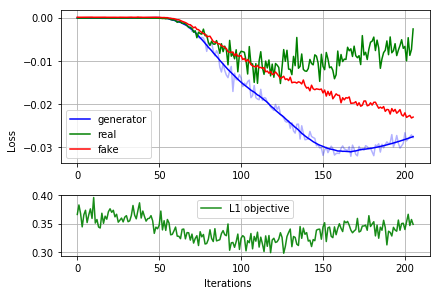

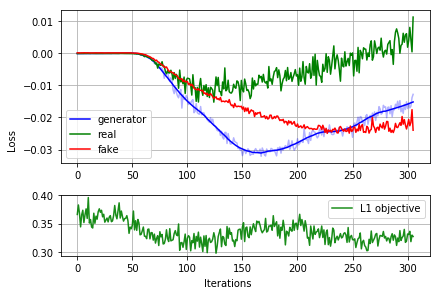

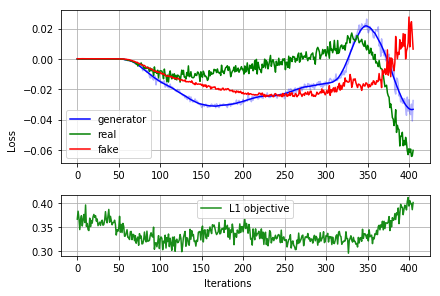

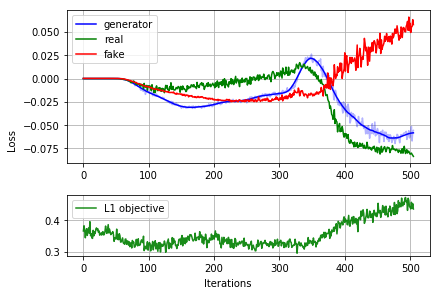

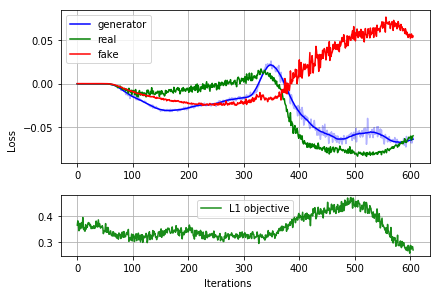

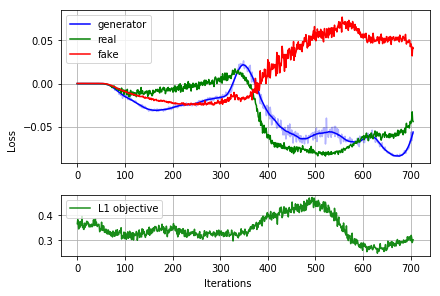

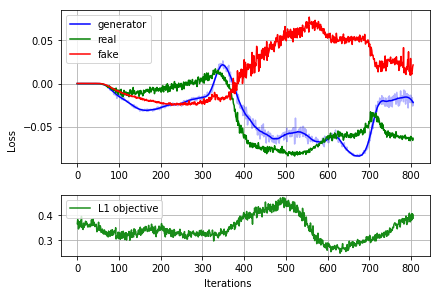

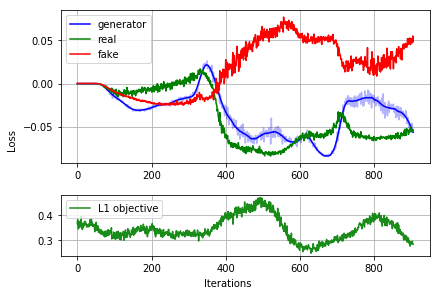

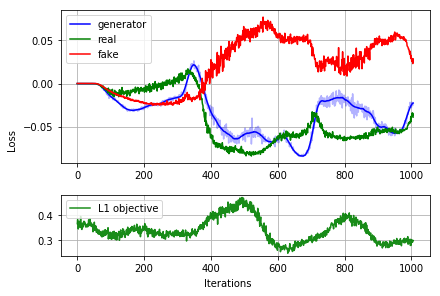

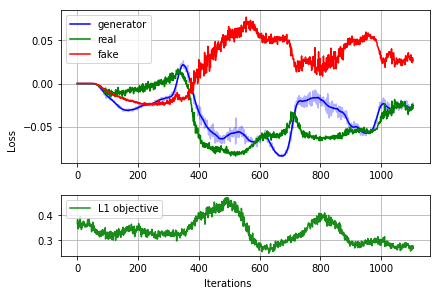

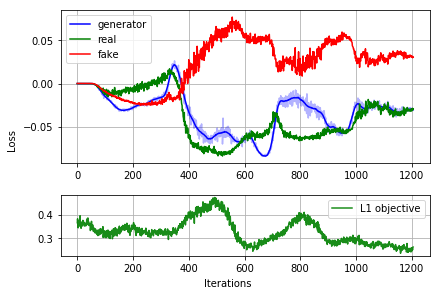

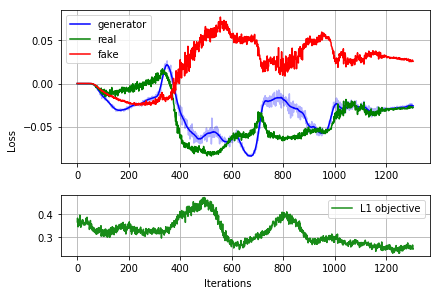

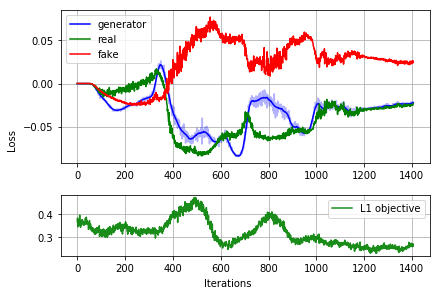

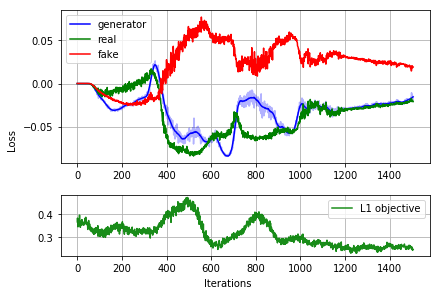

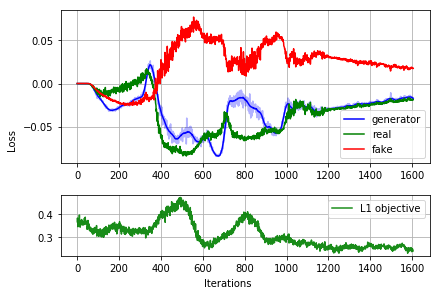

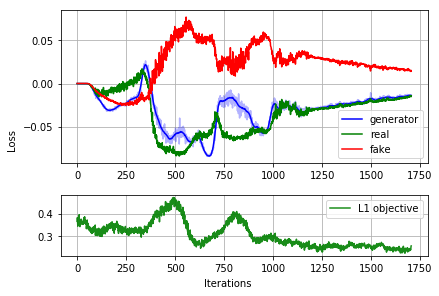

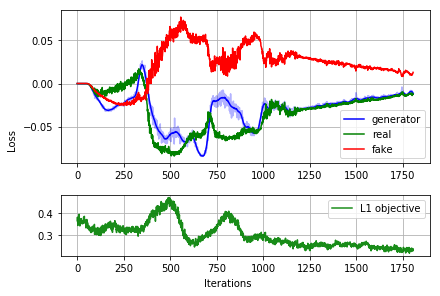

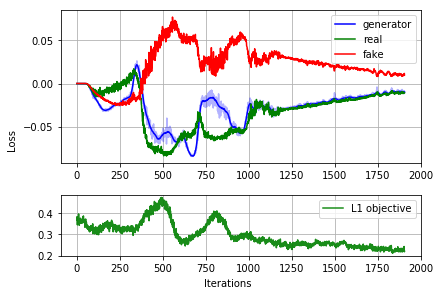

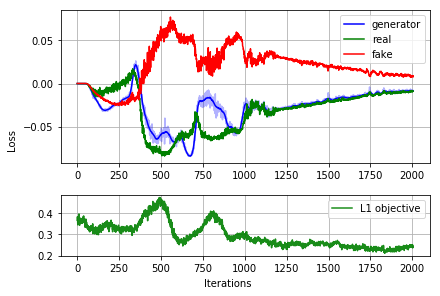

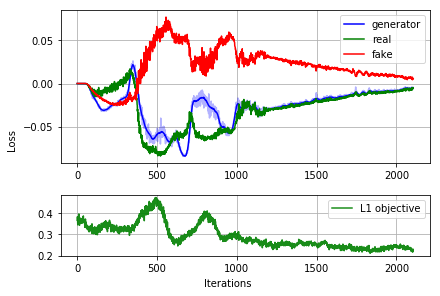

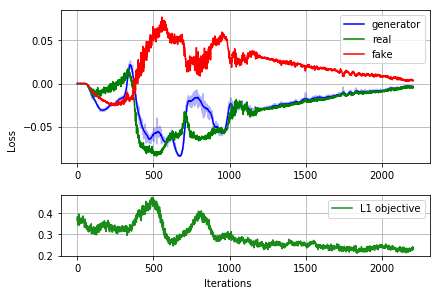

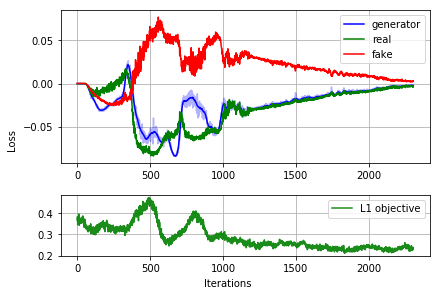

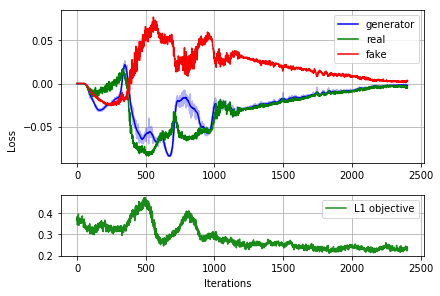

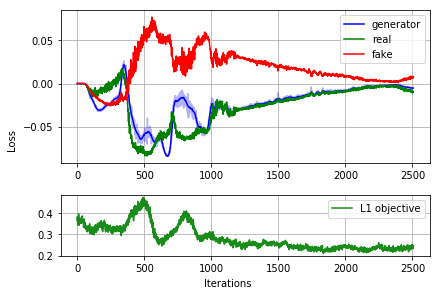

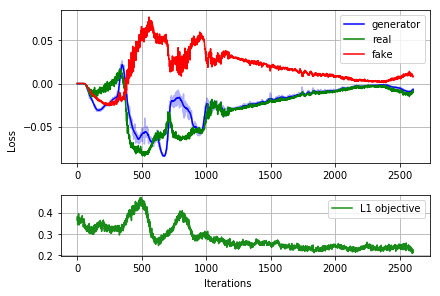

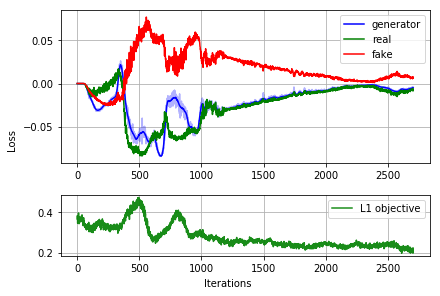

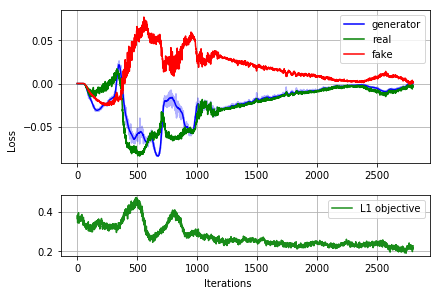

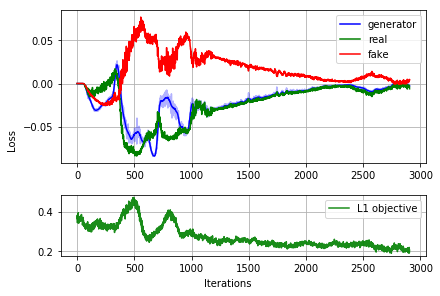

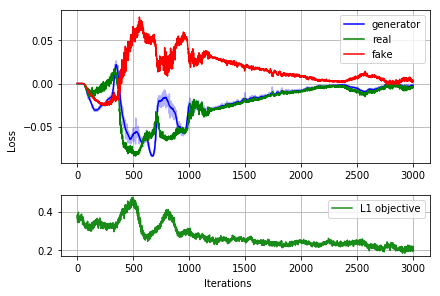

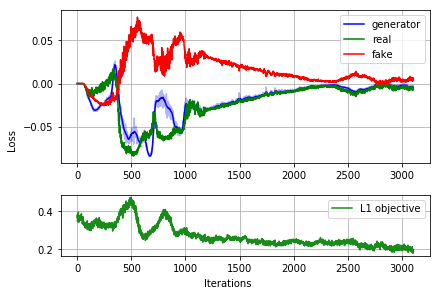

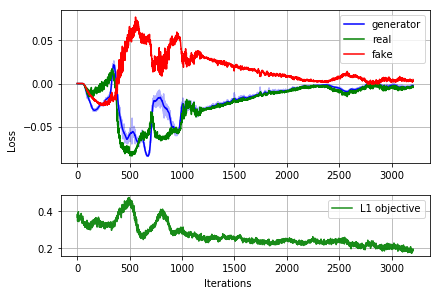

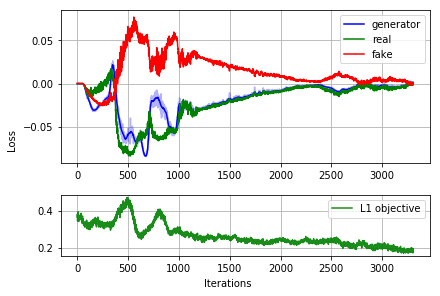

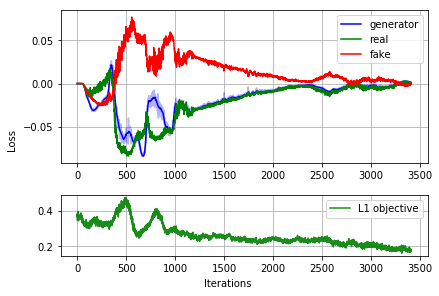

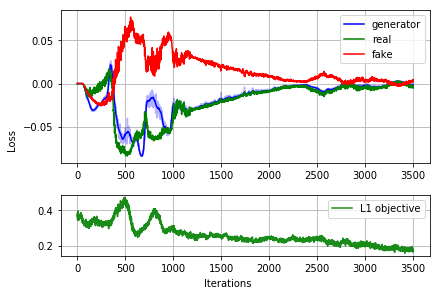

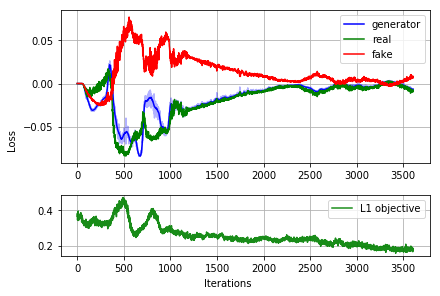

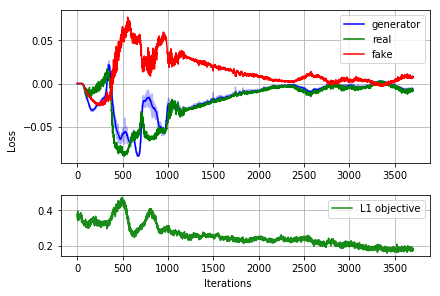

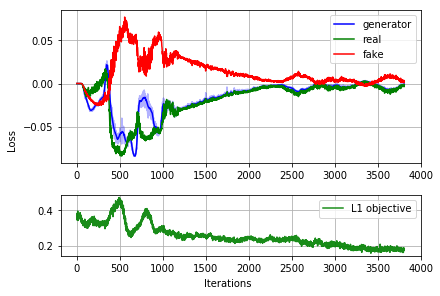

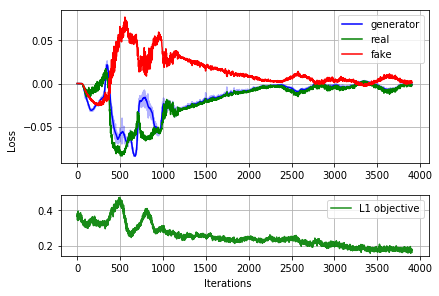

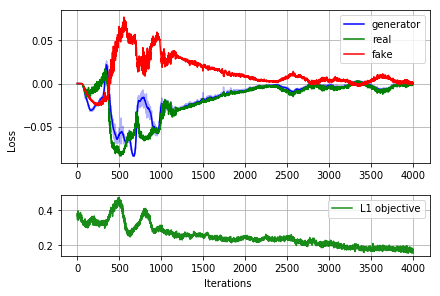

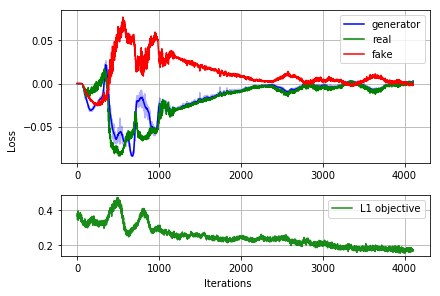

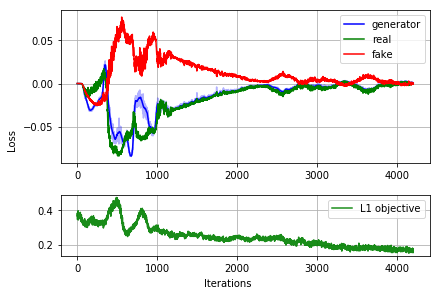

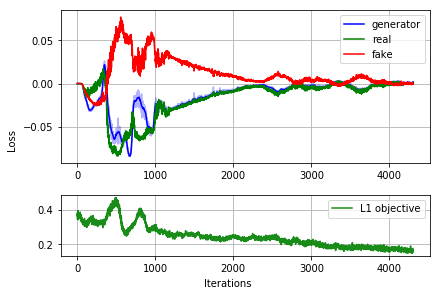

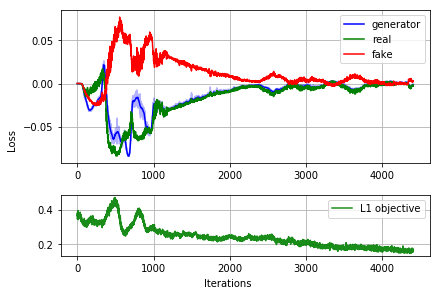

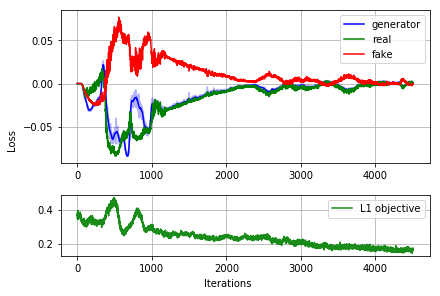

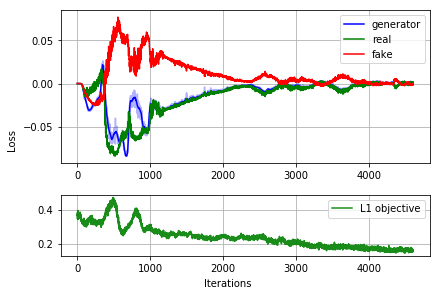

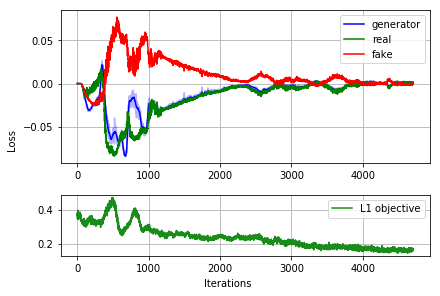

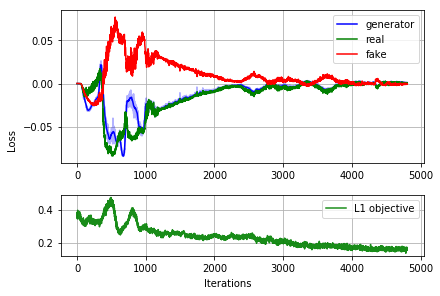

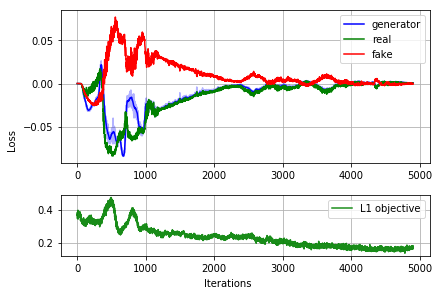

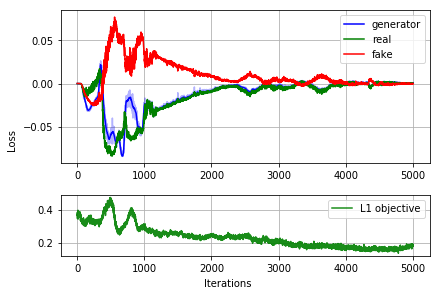

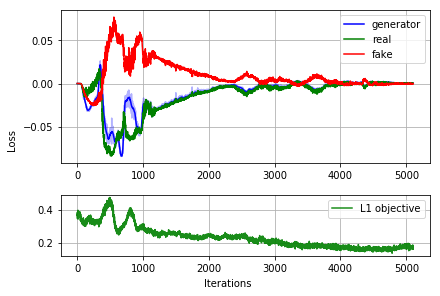

In [16]:
for epoch in range(epochs):
    
    if (epoch % 1000) < 25 or epoch % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 10
    else:
        d_iters = 10
    for d_it in range(d_iters):
        discriminator.trainable = True
        for l in discriminator.layers: l.trainable = True
        idx = np.random.choice(gan_truth.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx]
        
        for l in discriminator.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)
        d_loss_real = discriminator.train_on_batch([training_batch, real_imgs], real)
        generated_imgs = generator.predict(training_batch) 
        d_loss_fake = discriminator.train_on_batch([training_batch, generated_imgs], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator.trainable = False 
    for l in discriminator.layers: l.trainable = False
    
    idx = np.random.choice(gan_truth.shape[0], batch_size, replace=False)
    training_batch = gan_train[idx]
    training_truth = gan_truth[idx]
    
    g_loss = combined.train_on_batch(training_batch, [training_truth, real])
    
    log["g_loss"].append(g_loss) #sum, obj, bce
    log["d_loss"].append(d_loss) #sum
    log["g_metric"].append(g_loss[1])
    #log["d_metric"].append(d_loss[1])
    log["d_loss_real"].append(d_loss_real)
    log["d_loss_fake"].append(d_loss_fake)
    
    print(f"\033[1m {epoch} [D loss: {d_loss}]\033[0m \n"+
          f"\033[1m {epoch} [G loss: {g_loss[0]}, G obj.: {g_loss[1]}, G wgan.: {g_loss[2]}]\033[0m \n"+
          f"\033[1m {epoch} [real loss: {d_loss_real}, fake loss: {d_loss_fake}]\033[0m")
    if (epoch%100 == 0 or epoch == epochs-1) and epoch > 0:
        src.sample_images(epoch, gan_test, gan_test_truth, past, generator)
        plot_training_curves(log, epoch, name, True)

In [15]:
def plot_training_curves(log, epoch, name, wgan=False):
    total_g_loss = np.array(log["g_loss"])[:, 0]
    total_d_loss = np.array(log["d_loss"])[:, 0] if not wgan else np.array(log["d_loss"])
    smoothed_tgl = src.smooth(np.array(log["g_loss"])[:, 0])
    smoothed_tdl = src.smooth(np.array(log["d_loss"])[:, 0]) if not wgan else src.smooth(np.array(log["d_loss"]))
    objective_loss = np.array(log["g_loss"])[:, 1]

    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2]})
    a0.plot(total_g_loss, alpha=0.3, c="b")
    a0.plot(smoothed_tgl, c="b", label="generator")
    a0.grid()
    if wgan:
        a0.plot(np.array(log["d_loss_real"]), c="g", label="real")
        a0.plot(np.array(log["d_loss_fake"]), c="r", label="fake")
    else:
        a0.plot(total_d_loss, alpha=0.3, c="orange")
        a0.plot(smoothed_tdl, c="orange", label="discriminator")
    a0.legend()
    a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
    a1.grid()
    a1.legend()
    f.text(0.5, 0, 'Iterations', ha='center', va='center')
    f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

    f.tight_layout()
    f.savefig(f"Plots/{name}_epoch_{epoch}_curves.png")

## Save features

Save model history

In [ ]:
np.save(name+"_log",log)

Save model weights

In [ ]:
combined.save_weights(name+"_model.h5")

Load model and predict

Predict future frames. Loads a 20 long sequence with 1000 sequence samples.

In [17]:
sequence_test = src.load_datasets(prediction=True)

Test data: (1000, 64, 64, 20)


In [18]:
sequence_test = src.augment_data(sequence_test[:100])

In [19]:
sequence_test.shape

(400, 64, 64, 20)

In [20]:
#test
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]

In [21]:
gen = combined.layers[1]

In [42]:
for t in range(5):
    print(t)
    future = gen.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

0
1
2
3
4


In [44]:
predictions["4"]

array([[[[ 5.26531674e-02],
         [ 4.99422491e-01],
         [ 1.78106532e-01],
         ...,
         [-1.18327871e-01],
         [ 1.26171678e-01],
         [ 1.80030286e-01]],

        [[ 2.47577772e-01],
         [ 4.72110718e-01],
         [ 3.80298123e-02],
         ...,
         [-1.07602999e-01],
         [-1.67626247e-01],
         [-1.47691416e-02]],

        [[ 3.73938948e-01],
         [ 4.99877363e-01],
         [-4.32202101e-01],
         ...,
         [-1.48018360e-01],
         [ 2.36742407e-01],
         [ 2.62952358e-01]],

        ...,

        [[-6.31284267e-02],
         [-3.62759143e-01],
         [-6.67385831e-02],
         ...,
         [ 1.78307191e-01],
         [ 4.35609132e-01],
         [ 2.16337502e-01]],

        [[ 5.86089492e-01],
         [ 5.81621587e-01],
         [-7.31868207e-01],
         ...,
         [ 3.88541043e-01],
         [ 3.25013787e-01],
         [ 1.79981813e-01]],

        [[ 1.68110549e-01],
         [ 3.54325086e-01],
         [

Save example predictions

In [23]:
src.save_examples(name, sequence_test, predictions, past, samples=[33,54]) # 33, 46, 54

Renormalize intensity values


In [47]:
norms = np.load(sys.path[0]+"/5min_norms_compressed.npz")["arr_1"]

# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms[9000:])*4

#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in ['0', '1', '2', '3', "4"]])[:,:,:,:,0]), (1,2,3,0))


Calculate pixel intensities back to dBZ and from there to mm/h. <br>
Sources: <br>
- https://www.dwd.de/DE/leistungen/radolan/radolan_info/radolan_radvor_op_komposit_format_pdf.pdf?__blob=publicationFile&v=11 (page 10)
- <https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates>


In [46]:
I_p.shape

(400, 64, 64, 4)

In [48]:
#dBZ
dBZ_t = renormalized_test*0.5 - 32.5
dBZ_p = renormalized_predictions*0.5 - 32.5
#mm/h
I_t = (0.005*10**(0.1*dBZ_t))**(0.625)
I_p = (0.005*10**(0.1*dBZ_p))**(0.625)

thresholds = [0.5]
scores = {}
for t in range(5): # loop over the predictions (4)
    print(t)
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}"] = src.calculate_skill_scores(I_p[...,t:t+1],
                                                          I_t[...,past+t:past+1+t],
                                                          x=I_t[...,past-1:past],
                                                          threshold=s)

0


C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:878: RuntimeWarning: invalid value encountered in true_divide
  scores["csi"] = hits/(hits+misses+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:880: RuntimeWarning: invalid value encountered in true_divide
  scores["far"] = false_alarms/(hits+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:882: RuntimeWarning: invalid value encountered in true_divide
  scores["pod"] = hits/(hits+misses)


1
2
3
4


In [52]:
np.save(name+"_scores",scores)

In [37]:
s = np.load(name+"_scores.npy")
s

array({'pred_1': {'csi': array([0.        , 0.025     , 0.04255319, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01538462, 0.10852713,
       0.17536534, 0.15909091, 0.03816794, 0.08080808, 0.15217391,
       0.05940594, 0.41623489, 0.07692308, 0.19207317, 0.39087302,
       0.05263158, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ,        nan, 0.        ,
       0.22258065, 0.03333333, 0.36134454, 0.11042945, 0.32931727,
       0.36741768, 0.1       , 0.04347826,        nan, 0.16393443,
       0.0212766 , 0.        , 0.        , 0.        , 0.3054755 ,
       0.01526718, 0.35108959, 0.12295082, 0.        , 0.        ,
       0.27586207,        nan, 0.35501355, 0.55343915, 0.3658147 ,
       0.34782609,        nan,        nan, 0.        , 0.        ,
       0.06896552, 0.        , 0.12698413, 0.07936508, 0.53968254,
       0.26680672, 0.01694915, 0.37423313, 0.02941176, 0.        ,
       0.        , 0.03225806, 0.3673

In [49]:
scores.keys()

dict_keys(['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'])

In [56]:

np.mean(pd.Series(scores["pred_1"]["corr_to_input"]).dropna())

0.18695143962672822

In [54]:
np.mean(pd.Series(scores["pred_4"]["far"]).dropna())

0.9469260527977694